# Introduction

## Installations and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=a4d6a585afd81a1e400dc1e69435679e9f0d0a911e1e36db433ff21c54e195b5
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import glob
import torch
import torchvision
from torch import nn
from torchvision import models
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import json
import glob
import copy
import random

import os
import time
import sys
import shutil
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm
import face_recognition

from google_drive_downloader import GoogleDriveDownloader as gdd

from IPython.display import clear_output

In [ ]:
# create_preprocessed_videos(video_files,'FF_REAL_Face_only_data/')

## Preprocessed Dataset.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/Deepfake/Preprocessed_Dataset/labels.csv', header=None, names=['video', 'label'])

In [ ]:
df.head()

,video,label
0,000.mp4,REAL
1,000_003.mp4,FAKE
2,001.mp4,REAL
3,001_870.mp4,FAKE
4,002.mp4,REAL


In [ ]:
!unzip /content/drive/MyDrive/Project/Deepfake/Preprocessed_Dataset/Celeb_fake_face_only.zip
!unzip /content/drive/MyDrive/Project/Deepfake/Preprocessed_Dataset/Celeb_real_face_only.zip
!unzip /content/drive/MyDrive/Project/Deepfake/Preprocessed_Dataset/DFDC_FAKE_Face_only_data.zip
!unzip /content/drive/MyDrive/Project/Deepfake/Preprocessed_Dataset/DFDC_REAL_Face_only_data.zip
!unzip /content/drive/MyDrive/Project/Deepfake/Preprocessed_Dataset/FF_Face_only_data.zip
clear_output()

In [ ]:
video_data =  glob.glob('/content/Celeb_fake_face_only/*.mp4')
video_data += glob.glob('/content/Celeb_real_face_only/*.mp4')

In [ ]:
print("Total no of Celeb videos :" , len(video_data))

Total no of Celeb videos : 1168


In [ ]:
video_data += glob.glob('/content/DFDC_FAKE_Face_only_data/*.mp4')
video_data += glob.glob('/content/DFDC_REAL_Face_only_data/*.mp4')

In [ ]:
print("Total no of DFDC videos :" , len(glob.glob('/content/DFDC_FAKE_Face_only_data/*.mp4'))+len(glob.glob('/content/DFDC_REAL_Face_only_data/*.mp4')))

Total no of DFDC videos : 3293


In [ ]:
video_data += glob.glob('/content/FF_Face_only_data/*.mp4')

In [ ]:
print("Total no of FF_Face videos :" , len(glob.glob('/content/FF_Face_only_data/*.mp4')))

Total no of FF_Face videos : 1989


In [ ]:
print("Total no of videos :" , len(video_data))

Total no of videos : 6450


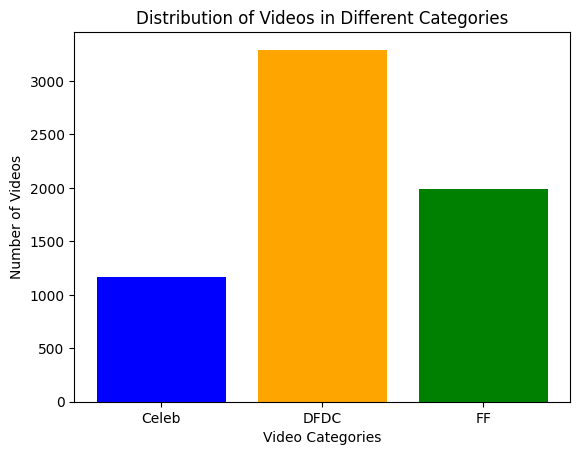

In [ ]:
# Count videos in each category
celeb_count = len(glob.glob('/content/Celeb_fake_face_only/*.mp4')) + len(glob.glob('/content/Celeb_real_face_only/*.mp4'))
dfdc_count = len(glob.glob('/content/DFDC_FAKE_Face_only_data/*.mp4')) + len(glob.glob('/content/DFDC_REAL_Face_only_data/*.mp4'))
ff_count = len(glob.glob('/content/FF_Face_only_data/*.mp4'))

# Total number of videos
total_count = len(video_data)

# Plotting the bar chart
categories = ['Celeb', 'DFDC', 'FF']
counts = [celeb_count, dfdc_count, ff_count]

plt.bar(categories, counts, color=['blue', 'orange', 'green'])
plt.title('Distribution of Videos in Different Categories')
plt.xlabel('Video Categories')
plt.ylabel('Number of Videos')
plt.show()

### Dataset Validation

In [ ]:
# Check if the file is corrupted or not
def validation(vid_path, train_transforms):
    transform = train_transforms
    count = 20
    video_path = vid_path
    frames = []

    # Calculate the step for frame sampling
    step = int(100 / count)

    # Randomly select the starting point within the first 'step' frames
    first_frame = np.random.randint(0, step)

    # Extract frames from the video
    for i, frame in enumerate(frame_extract(video_path)):
        if i % step == first_frame:
            frames.append(transform(frame))

        # Break when the desired number of frames is reached
        if len(frames) == count:
            break

    # Convert the list of frames to a torch tensor
    frames = torch.stack(frames)

    # Ensure the number of frames is exactly 'count'
    frames = frames[:count]

    return frames

In [ ]:
def frame_extract(path):
    # Open the video file
    vidObj = cv2.VideoCapture(path)

    # Continue looping until there are no more frames
    while True:
        # Read the next frame from the video
        success, frame = vidObj.read()

        # Check if reading was successful
        if not success:
            # Break the loop if no more frames are available
            break

        # Yield the current frame
        yield frame

In [ ]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
train_transforms = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((im_size,im_size)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean,std)])

In [ ]:
# this cell will take few mint
count = 0

# Loop through each video file path
for i in video_data:
    try:
        # Increment the count and validate the video
        count += 1
        validation(i, train_transforms)
    except Exception as e:
        # Handle exceptions (assuming you want to catch all exceptions)
        print("Number of videos processed:", count, "Remaining:", len(video_data) - count)
        print("Error processing video:", i)
        print("Error details:", str(e))
        continue

# Print the count of processed videos
print("Total number of videos processed:", count)
print("Number of corrupted videos:", len(video_data) - count)

Total number of videos processed: 6450
Number of corrupted videos: 0


### Dataset Preprocessing

In [ ]:
# Shuffle the list of video files twice for randomness
random.shuffle(video_data)
random.shuffle(video_data)

# List to store frame counts of valid videos
frame_counts = []

# Loop through each video file
for video_file in video_data:
    # Open the video file
    cap = cv2.VideoCapture(video_file)

    # Check if the video has at least 100 frames
    if int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) < 100:
        # Exclude videos with fewer than 100 frames
        video_data.remove(video_file)
        continue

    # Store the frame count of valid videos
    frame_counts.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

# Print information about frame counts
print("Frame counts:", frame_counts)
print("Total number of valid videos:", len(frame_counts))
print('Average frames per video:', np.mean(frame_counts))

Frame counts: [148, 148, 148, 148, 148, 148, 148, 148, 148, 145, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 139, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 105, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 146, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 142, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 137, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 123, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 

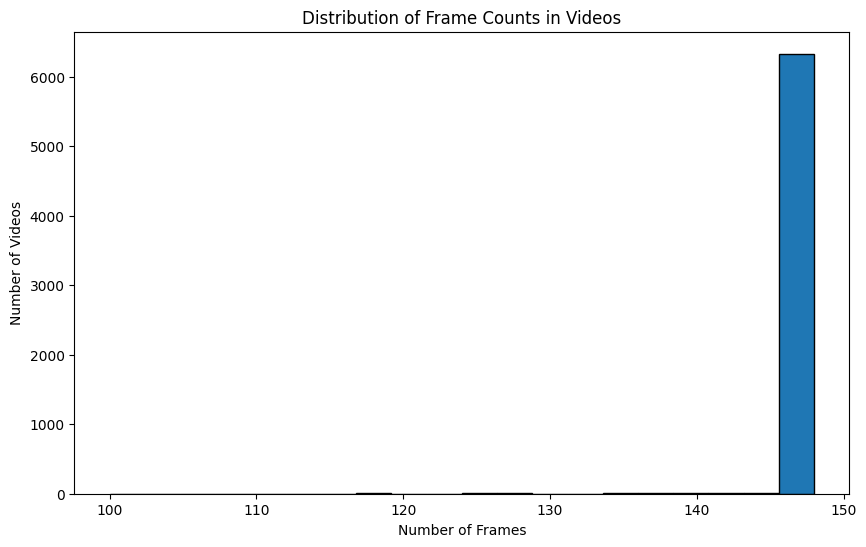

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(frame_counts, bins=20, edgecolor='black')
plt.title('Distribution of Frame Counts in Videos')
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.show()

### Dataset loader

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        # Get video path and label for the current index
        video_path = self.video_names[idx]
        label = self.labels.iloc[(self.labels.loc[self.labels["video"] == video_path.split('/')[-1]].index.values[0]), 1]

        # Map label 'FAKE' to 0 and 'REAL' to 1
        label = 0 if label == 'FAKE' else 1

        # Initialize list to store frames
        frames = []

        # Calculate step for frame sampling
        step = int(100 / self.count)

        # Randomly select the starting point within the first 'step' frames
        first_frame = np.random.randint(0, step)

        # Extract frames from the video
        for i, frame in enumerate(self.frame_extract(video_path)):
            if i % step == first_frame:
                frames.append(self.transform(frame))

            # Break when the desired number of frames is reached
            if len(frames) == self.count:
                break

        # Convert the list of frames to a torch tensor
        frames = torch.stack(frames)

        # Ensure the number of frames is exactly 'count'
        frames = frames[:self.count]

        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

In [ ]:
def real_and_fake_videos(data_list):

    # Read the labels CSV file into a DataFrame
    labels_df = df.copy()

    # Initialize counters for fake and real videos
    fake_count = 0
    real_count = 0

    # Loop through each video path in the provided list
    for video_path in data_list:
        # Extract the video file name from the path
        temp_video = video_path.split('/')[-1]

        # Extract the label for the current video from the DataFrame
        label = labels_df.loc[labels_df["video"] == temp_video, "label"].values[0]

        # Update counters based on the label
        if label == 'FAKE':
            fake_count += 1
        elif label == 'REAL':
            real_count += 1

    # Return the counts of real and fake videos
    return real_count, fake_count

### Data Split (Train-Val)

In [ ]:
# Assuming 'df' is the DataFrame containing video file names and labels
labels = df.copy()

# Split video files into training and validation sets
train_videos = video_data[:int(0.8 * len(video_data))]
valid_videos = video_data[int(0.8 * len(video_data)):]

# Print the number of videos in the training and validation sets
print("Number of training videos:", len(train_videos))
print("Number of validation videos:", len(valid_videos))


Number of training videos: 5141
Number of validation videos: 1286


In [ ]:
# Print the number of real and fake videos in the training set
train_real, train_fake = real_and_fake_videos(train_videos)
print("TRAIN: Real:", train_real, " Fake:", train_fake)

# Print the number of real and fake videos in the validation set
valid_real, valid_fake = real_and_fake_videos(valid_videos)
print("TEST: Real:", valid_real, " Fake:", valid_fake)

TRAIN: Real: 2617  Fake: 2524
TEST: Real: 684  Fake: 602


## Train-Loader, Val-Loader

In [ ]:
# Data transformations for training and testing
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
# Create instances of the video_dataset class for training and validation
train_data = VideoDataset(train_videos, labels, sequence_length=10, transform=train_transforms)
val_data = VideoDataset(valid_videos, labels, sequence_length=10, transform=train_transforms)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
train_loader

In [ ]:
valid_loader

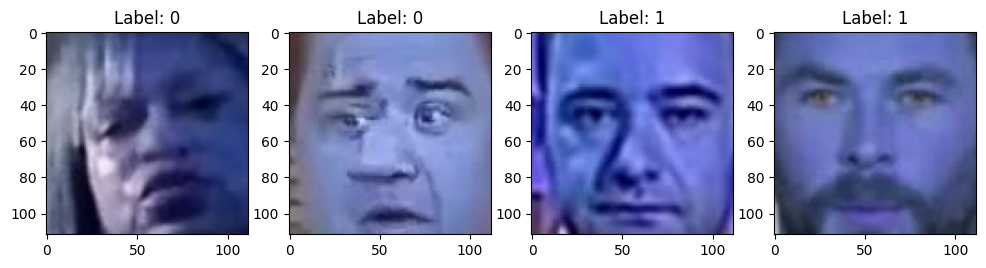

In [ ]:
# Number of random images to display
num_images_to_display = 4

# Create a figure with subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 3))

# Randomly select indices from the training dataset
random_indices = torch.randint(len(train_data), size=(num_images_to_display,))

# Loop through selected indices and display images
for i, idx in enumerate(random_indices):
    image, label = train_data[idx]

    # Denormalize the image tensor to bring pixel values back to the original scale
    image = image[0].numpy().transpose(1, 2, 0)
    mean = np.array(train_transforms.transforms[-1].mean)
    std = np.array(train_transforms.transforms[-1].std)

    # Denormalization: scale and shift
    image = image * std + mean

    # Clip pixel values to the valid range [0, 1]
    image = np.clip(image, 0, 1)

    # Display the image on the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")

# Show the subplots
plt.show()

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()

        # Load ResNeXt model with pretrained weights
        model = models.resnext50_32x4d(pretrained=True)

        # Extract feature layers from ResNeXt, excluding the final two layers
        # self.cnn_layer = CustomCNNLayer(input_channels=3, latent_dim = latent_dim)
        self.resnext_features = nn.Sequential(*list(model.children())[:-2])

        # LSTM layer to capture temporal dependencies
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional, batch_first=True)

        # Activation function
        self.relu = nn.LeakyReLU()

        # Dropout layer to prevent overfitting
        self.dp = nn.Dropout(0.4)

        # Linear layer for classification
        self.linear1 = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

        # Adaptive average pooling layer to reduce spatial dimensions
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape

        # Reshape input for the CNN
        x = x.view(batch_size * seq_length, c, h, w)

        # Apply CNN layer
        # x = self.cnn_layer(x)

        # Pass through the ResNeXt feature layers
        fmap = self.resnext_features(x)

        # Global average pooling to reduce spatial dimensions
        x = self.avgpool(fmap)

        # Reshape for the LSTM
        x = x.view(batch_size, seq_length, -1)

        # Pass through the LSTM
        x_lstm, _ = self.lstm(x)

        # Take the mean across the sequence dimension
        x_mean = torch.mean(x_lstm, dim=1)

        # Apply dropout and pass through the linear layer for classification
        return fmap, self.dp(self.linear1(x_mean))


In [ ]:
# Create an instance of the Model and move it to GPU
model = Model(2, latent_dim=2048).cuda()

# Sample input tensor (batch_size, seq_length, channels, height, width)
sample_input = torch.from_numpy(np.empty((1, 20, 3, 112, 112))).type(torch.cuda.FloatTensor)

# Forward pass through the model
output_fmap, output_classification = model(sample_input)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Display trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

resnext_features.0.weight: torch.Size([64, 3, 7, 7])
resnext_features.1.weight: torch.Size([64])
resnext_features.1.bias: torch.Size([64])
resnext_features.4.0.conv1.weight: torch.Size([128, 64, 1, 1])
resnext_features.4.0.bn1.weight: torch.Size([128])
resnext_features.4.0.bn1.bias: torch.Size([128])
resnext_features.4.0.conv2.weight: torch.Size([128, 4, 3, 3])
resnext_features.4.0.bn2.weight: torch.Size([128])
resnext_features.4.0.bn2.bias: torch.Size([128])
resnext_features.4.0.conv3.weight: torch.Size([256, 128, 1, 1])
resnext_features.4.0.bn3.weight: torch.Size([256])
resnext_features.4.0.bn3.bias: torch.Size([256])
resnext_features.4.0.downsample.0.weight: torch.Size([256, 64, 1, 1])
resnext_features.4.0.downsample.1.weight: torch.Size([256])
resnext_features.4.0.downsample.1.bias: torch.Size([256])
resnext_features.4.1.conv1.weight: torch.Size([128, 256, 1, 1])
resnext_features.4.1.bn1.weight: torch.Size([128])
resnext_features.4.1.bn1.bias: torch.Size([128])
resnext_features.4.1

#### Model Training

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        epoch (int): Current epoch number.
        num_epochs (int): Total number of epochs.
        data_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        model (torch.nn.Module): The neural network model.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        device (torch.device): Device to which data should be moved (e.g., 'cuda' for GPU).

    Returns:
        tuple: Average loss and accuracy for the epoch.
    """
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    # Use tqdm for a progress bar during training
    for i, (inputs, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs}")):
        # Move data to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        _, outputs = model(inputs)

        # Calculate loss and accuracy
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)

        # Update running averages
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch summary
    print(f"\n[Epoch {epoch}/{num_epochs}] [Loss: {losses.avg:.4f}, Acc: {accuracies.avg:.2%}]")

    # Save model state after each epoch
    torch.save(model.state_dict(), f'/content/checkpoint_epoch_{epoch}.pt')

    return losses.avg, accuracies.avg

In [ ]:
def test(epoch, model, data_loader, criterion):
    """
    Evaluate the model on the test dataset.

    Args:
        epoch (int): Current epoch number.
        model (torch.nn.Module): The neural network model.
        data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        criterion (torch.nn.Module): Loss function.

    Returns:
        tuple: True labels, predicted labels, average loss, and accuracy.
    """
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch} Testing")):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()

            # Forward pass
            _, outputs = model(inputs)

            # Calculate loss and accuracy
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))

            # Record true and predicted labels
            true += targets.type(torch.cuda.LongTensor).detach().cpu().numpy().reshape(len(targets)).tolist()
            _, p = torch.max(outputs, 1)
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()

            # Update running averages
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            print(
                "[Batch %d / %d]  [Loss: %.4f, Acc: %.2f%%]"
                % (
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg
                )
            )

        print('\nAccuracy {}'.format(accuracies.avg))

    return true, pred, losses.avg, accuracies.avg


In [ ]:
# Check the current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        """Reset the meter's values to their initial state."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        Update the meter with a new value and count.

        Args:
            val (float): The new value to update the meter with.
            n (int): The count associated with the new value (default is 1).
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
def calculate_accuracy(outputs, targets):
    """
    Calculate the accuracy of model predictions.

    Args:
        outputs (torch.Tensor): Model predictions.
        targets (torch.Tensor): True labels.

    Returns:
        float: Accuracy as a percentage.
    """
    batch_size = targets.size(0)

    # Get the index of the maximum value along the predicted dimension
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()

    # Check if predictions match the true labels
    correct = pred.eq(targets.view(1, -1))

    # Count the number of correct predictions
    n_correct_elems = correct.float().sum().item()

    # Calculate accuracy as a percentage
    accuracy = 100 * n_correct_elems / batch_size

    return accuracy

In [ ]:
# Learning rate
lr = 1e-5

# Number of epochs
num_epochs = 5

# Define the optimizer (Adam) with a learning rate and weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Define the loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss().cuda()

# Lists to store training and testing metrics for each epoch
train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

# Training and testing loop
for epoch in range(1, num_epochs + 1):
    # Train the model for one epoch and record training loss and accuracy
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer, device)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)

    # Test the model on the validation set and record testing loss and accuracy
    true_labels, predicted_labels, test_loss, test_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)


Epoch 1/5: 100%|██████████| 1286/1286 [04:23<00:00,  4.89it/s]



[Epoch 1/5] [Loss: 0.6249, Acc: 6599.88%]
Testing


Epoch 1 Testing:   1%|          | 3/322 [00:00<00:41,  7.71it/s]

[Batch 0 / 322]  [Loss: 0.8941, Acc: 50.00%]
[Batch 1 / 322]  [Loss: 0.9555, Acc: 50.00%]
[Batch 2 / 322]  [Loss: 0.7337, Acc: 66.67%]
[Batch 3 / 322]  [Loss: 0.6103, Acc: 75.00%]


Epoch 1 Testing:   2%|▏         | 7/322 [00:00<00:26, 12.11it/s]

[Batch 4 / 322]  [Loss: 0.6013, Acc: 75.00%]
[Batch 5 / 322]  [Loss: 0.6342, Acc: 66.67%]
[Batch 6 / 322]  [Loss: 0.6653, Acc: 64.29%]
[Batch 7 / 322]  [Loss: 0.6288, Acc: 68.75%]


Epoch 1 Testing:   3%|▎         | 11/322 [00:00<00:21, 14.20it/s]

[Batch 8 / 322]  [Loss: 0.6627, Acc: 66.67%]
[Batch 9 / 322]  [Loss: 0.6152, Acc: 70.00%]
[Batch 10 / 322]  [Loss: 0.5798, Acc: 72.73%]
[Batch 11 / 322]  [Loss: 0.5601, Acc: 75.00%]


Epoch 1 Testing:   5%|▍         | 15/322 [00:01<00:22, 13.86it/s]

[Batch 12 / 322]  [Loss: 0.5772, Acc: 73.08%]
[Batch 13 / 322]  [Loss: 0.5909, Acc: 73.21%]
[Batch 14 / 322]  [Loss: 0.5804, Acc: 75.00%]
[Batch 15 / 322]  [Loss: 0.5704, Acc: 76.56%]


Epoch 1 Testing:   6%|▌         | 19/322 [00:01<00:20, 14.72it/s]

[Batch 16 / 322]  [Loss: 0.5653, Acc: 76.47%]
[Batch 17 / 322]  [Loss: 0.5603, Acc: 77.78%]
[Batch 18 / 322]  [Loss: 0.5540, Acc: 77.63%]
[Batch 19 / 322]  [Loss: 0.5426, Acc: 78.75%]


Epoch 1 Testing:   7%|▋         | 23/322 [00:01<00:19, 15.53it/s]

[Batch 20 / 322]  [Loss: 0.5465, Acc: 78.57%]
[Batch 21 / 322]  [Loss: 0.5431, Acc: 78.41%]
[Batch 22 / 322]  [Loss: 0.5559, Acc: 77.17%]
[Batch 23 / 322]  [Loss: 0.5510, Acc: 78.12%]


Epoch 1 Testing:   8%|▊         | 27/322 [00:02<00:20, 14.23it/s]

[Batch 24 / 322]  [Loss: 0.5412, Acc: 79.00%]
[Batch 25 / 322]  [Loss: 0.5358, Acc: 79.81%]
[Batch 26 / 322]  [Loss: 0.5339, Acc: 79.63%]


Epoch 1 Testing:   9%|▉         | 29/322 [00:02<00:21, 13.81it/s]

[Batch 27 / 322]  [Loss: 0.5250, Acc: 80.36%]
[Batch 28 / 322]  [Loss: 0.5228, Acc: 80.17%]


Epoch 1 Testing:  10%|▉         | 31/322 [00:02<00:23, 12.30it/s]

[Batch 29 / 322]  [Loss: 0.5142, Acc: 80.83%]
[Batch 30 / 322]  [Loss: 0.5094, Acc: 81.45%]
[Batch 31 / 322]  [Loss: 0.5012, Acc: 82.03%]


Epoch 1 Testing:  10%|█         | 33/322 [00:02<00:24, 11.69it/s]

[Batch 32 / 322]  [Loss: 0.4939, Acc: 82.58%]
[Batch 33 / 322]  [Loss: 0.4864, Acc: 83.09%]


Epoch 1 Testing:  11%|█         | 35/322 [00:02<00:27, 10.29it/s]

[Batch 34 / 322]  [Loss: 0.4949, Acc: 82.14%]
[Batch 35 / 322]  [Loss: 0.4879, Acc: 82.64%]


Epoch 1 Testing:  12%|█▏        | 39/322 [00:03<00:28, 10.09it/s]

[Batch 36 / 322]  [Loss: 0.4901, Acc: 82.43%]
[Batch 37 / 322]  [Loss: 0.4916, Acc: 81.58%]
[Batch 38 / 322]  [Loss: 0.4877, Acc: 82.05%]


Epoch 1 Testing:  13%|█▎        | 41/322 [00:03<00:29,  9.60it/s]

[Batch 39 / 322]  [Loss: 0.4824, Acc: 82.50%]
[Batch 40 / 322]  [Loss: 0.4782, Acc: 82.93%]


Epoch 1 Testing:  13%|█▎        | 42/322 [00:03<00:32,  8.59it/s]

[Batch 41 / 322]  [Loss: 0.4857, Acc: 82.14%]
[Batch 42 / 322]  [Loss: 0.4820, Acc: 82.56%]


Epoch 1 Testing:  14%|█▎        | 44/322 [00:03<00:32,  8.46it/s]

[Batch 43 / 322]  [Loss: 0.4792, Acc: 82.95%]
[Batch 44 / 322]  [Loss: 0.4773, Acc: 83.33%]


Epoch 1 Testing:  15%|█▍        | 48/322 [00:04<00:29,  9.15it/s]

[Batch 45 / 322]  [Loss: 0.4814, Acc: 83.15%]
[Batch 46 / 322]  [Loss: 0.4860, Acc: 82.98%]
[Batch 47 / 322]  [Loss: 0.4849, Acc: 82.29%]


Epoch 1 Testing:  16%|█▌        | 50/322 [00:04<00:30,  8.99it/s]

[Batch 48 / 322]  [Loss: 0.4868, Acc: 82.65%]
[Batch 49 / 322]  [Loss: 0.4912, Acc: 82.00%]


Epoch 1 Testing:  16%|█▌        | 52/322 [00:04<00:28,  9.58it/s]

[Batch 50 / 322]  [Loss: 0.4907, Acc: 81.86%]
[Batch 51 / 322]  [Loss: 0.4875, Acc: 81.73%]
[Batch 52 / 322]  [Loss: 0.4853, Acc: 82.08%]


Epoch 1 Testing:  17%|█▋        | 54/322 [00:04<00:27,  9.69it/s]

[Batch 53 / 322]  [Loss: 0.4846, Acc: 82.41%]
[Batch 54 / 322]  [Loss: 0.4812, Acc: 82.73%]


Epoch 1 Testing:  18%|█▊        | 58/322 [00:05<00:25, 10.53it/s]

[Batch 55 / 322]  [Loss: 0.4838, Acc: 82.59%]
[Batch 56 / 322]  [Loss: 0.4835, Acc: 82.89%]
[Batch 57 / 322]  [Loss: 0.4784, Acc: 83.19%]


Epoch 1 Testing:  19%|█▊        | 60/322 [00:05<00:24, 10.75it/s]

[Batch 58 / 322]  [Loss: 0.4747, Acc: 83.47%]
[Batch 59 / 322]  [Loss: 0.4727, Acc: 83.75%]
[Batch 60 / 322]  [Loss: 0.4757, Acc: 83.20%]


Epoch 1 Testing:  19%|█▉        | 62/322 [00:05<00:25, 10.10it/s]

[Batch 61 / 322]  [Loss: 0.4710, Acc: 83.47%]
[Batch 62 / 322]  [Loss: 0.4689, Acc: 83.33%]


Epoch 1 Testing:  20%|█▉        | 64/322 [00:05<00:28,  9.18it/s]

[Batch 63 / 322]  [Loss: 0.4654, Acc: 83.59%]
[Batch 64 / 322]  [Loss: 0.4650, Acc: 83.46%]


Epoch 1 Testing:  20%|██        | 66/322 [00:06<00:29,  8.74it/s]

[Batch 65 / 322]  [Loss: 0.4687, Acc: 83.33%]
[Batch 66 / 322]  [Loss: 0.4655, Acc: 83.58%]


Epoch 1 Testing:  21%|██        | 68/322 [00:06<00:28,  8.82it/s]

[Batch 67 / 322]  [Loss: 0.4667, Acc: 83.46%]
[Batch 68 / 322]  [Loss: 0.4681, Acc: 82.97%]


Epoch 1 Testing:  22%|██▏       | 72/322 [00:06<00:26,  9.36it/s]

[Batch 69 / 322]  [Loss: 0.4695, Acc: 82.50%]
[Batch 70 / 322]  [Loss: 0.4702, Acc: 82.04%]
[Batch 71 / 322]  [Loss: 0.4713, Acc: 81.94%]


Epoch 1 Testing:  23%|██▎       | 74/322 [00:07<00:25,  9.75it/s]

[Batch 72 / 322]  [Loss: 0.4725, Acc: 81.85%]
[Batch 73 / 322]  [Loss: 0.4717, Acc: 81.76%]
[Batch 74 / 322]  [Loss: 0.4768, Acc: 81.00%]


Epoch 1 Testing:  24%|██▍       | 78/322 [00:07<00:25,  9.64it/s]

[Batch 75 / 322]  [Loss: 0.4765, Acc: 80.92%]
[Batch 76 / 322]  [Loss: 0.4746, Acc: 81.17%]
[Batch 77 / 322]  [Loss: 0.4737, Acc: 81.09%]


Epoch 1 Testing:  25%|██▍       | 80/322 [00:07<00:26,  9.26it/s]

[Batch 78 / 322]  [Loss: 0.4761, Acc: 81.01%]
[Batch 79 / 322]  [Loss: 0.4756, Acc: 80.62%]


Epoch 1 Testing:  25%|██▌       | 82/322 [00:07<00:24,  9.66it/s]

[Batch 80 / 322]  [Loss: 0.4750, Acc: 80.56%]
[Batch 81 / 322]  [Loss: 0.4743, Acc: 80.49%]
[Batch 82 / 322]  [Loss: 0.4738, Acc: 80.72%]


Epoch 1 Testing:  27%|██▋       | 86/322 [00:08<00:22, 10.34it/s]

[Batch 83 / 322]  [Loss: 0.4731, Acc: 80.95%]
[Batch 84 / 322]  [Loss: 0.4719, Acc: 81.18%]
[Batch 85 / 322]  [Loss: 0.4700, Acc: 81.40%]


Epoch 1 Testing:  27%|██▋       | 88/322 [00:08<00:24,  9.48it/s]

[Batch 86 / 322]  [Loss: 0.4685, Acc: 81.32%]
[Batch 87 / 322]  [Loss: 0.4680, Acc: 81.53%]


Epoch 1 Testing:  28%|██▊       | 90/322 [00:08<00:22, 10.30it/s]

[Batch 88 / 322]  [Loss: 0.4718, Acc: 81.18%]
[Batch 89 / 322]  [Loss: 0.4694, Acc: 81.39%]
[Batch 90 / 322]  [Loss: 0.4716, Acc: 81.04%]


Epoch 1 Testing:  29%|██▉       | 94/322 [00:09<00:22, 10.19it/s]

[Batch 91 / 322]  [Loss: 0.4692, Acc: 81.25%]
[Batch 92 / 322]  [Loss: 0.4703, Acc: 80.91%]
[Batch 93 / 322]  [Loss: 0.4726, Acc: 80.59%]
[Batch 94 / 322]  [Loss: 0.4700, Acc: 80.79%]


Epoch 1 Testing:  30%|███       | 98/322 [00:09<00:19, 11.68it/s]

[Batch 95 / 322]  [Loss: 0.4736, Acc: 80.47%]
[Batch 96 / 322]  [Loss: 0.4717, Acc: 80.67%]
[Batch 97 / 322]  [Loss: 0.4728, Acc: 80.36%]
[Batch 98 / 322]  [Loss: 0.4720, Acc: 80.30%]


Epoch 1 Testing:  32%|███▏      | 102/322 [00:09<00:16, 13.64it/s]

[Batch 99 / 322]  [Loss: 0.4696, Acc: 80.50%]
[Batch 100 / 322]  [Loss: 0.4679, Acc: 80.69%]
[Batch 101 / 322]  [Loss: 0.4696, Acc: 80.64%]
[Batch 102 / 322]  [Loss: 0.4720, Acc: 80.10%]


Epoch 1 Testing:  33%|███▎      | 106/322 [00:09<00:14, 14.64it/s]

[Batch 103 / 322]  [Loss: 0.4718, Acc: 80.05%]
[Batch 104 / 322]  [Loss: 0.4706, Acc: 80.24%]
[Batch 105 / 322]  [Loss: 0.4706, Acc: 80.42%]
[Batch 106 / 322]  [Loss: 0.4687, Acc: 80.61%]


Epoch 1 Testing:  34%|███▍      | 110/322 [00:10<00:13, 15.43it/s]

[Batch 107 / 322]  [Loss: 0.4673, Acc: 80.79%]
[Batch 108 / 322]  [Loss: 0.4648, Acc: 80.96%]
[Batch 109 / 322]  [Loss: 0.4659, Acc: 80.91%]
[Batch 110 / 322]  [Loss: 0.4681, Acc: 80.86%]


Epoch 1 Testing:  35%|███▌      | 114/322 [00:10<00:14, 14.78it/s]

[Batch 111 / 322]  [Loss: 0.4672, Acc: 81.03%]
[Batch 112 / 322]  [Loss: 0.4690, Acc: 80.97%]
[Batch 113 / 322]  [Loss: 0.4688, Acc: 81.14%]
[Batch 114 / 322]  [Loss: 0.4692, Acc: 81.09%]


Epoch 1 Testing:  37%|███▋      | 118/322 [00:10<00:13, 14.94it/s]

[Batch 115 / 322]  [Loss: 0.4682, Acc: 81.03%]
[Batch 116 / 322]  [Loss: 0.4670, Acc: 81.20%]
[Batch 117 / 322]  [Loss: 0.4672, Acc: 81.14%]
[Batch 118 / 322]  [Loss: 0.4657, Acc: 81.30%]


Epoch 1 Testing:  38%|███▊      | 122/322 [00:10<00:13, 15.10it/s]

[Batch 119 / 322]  [Loss: 0.4646, Acc: 81.46%]
[Batch 120 / 322]  [Loss: 0.4712, Acc: 80.79%]
[Batch 121 / 322]  [Loss: 0.4695, Acc: 80.94%]
[Batch 122 / 322]  [Loss: 0.4682, Acc: 80.89%]


Epoch 1 Testing:  39%|███▉      | 126/322 [00:11<00:13, 14.60it/s]

[Batch 123 / 322]  [Loss: 0.4675, Acc: 81.05%]
[Batch 124 / 322]  [Loss: 0.4687, Acc: 80.80%]
[Batch 125 / 322]  [Loss: 0.4689, Acc: 80.75%]
[Batch 126 / 322]  [Loss: 0.4697, Acc: 80.71%]


Epoch 1 Testing:  40%|████      | 130/322 [00:11<00:11, 16.05it/s]

[Batch 127 / 322]  [Loss: 0.4690, Acc: 80.86%]
[Batch 128 / 322]  [Loss: 0.4661, Acc: 81.01%]
[Batch 129 / 322]  [Loss: 0.4661, Acc: 80.96%]
[Batch 130 / 322]  [Loss: 0.4666, Acc: 80.92%]


Epoch 1 Testing:  42%|████▏     | 134/322 [00:11<00:12, 15.05it/s]

[Batch 131 / 322]  [Loss: 0.4656, Acc: 81.06%]
[Batch 132 / 322]  [Loss: 0.4658, Acc: 81.02%]
[Batch 133 / 322]  [Loss: 0.4660, Acc: 80.78%]
[Batch 134 / 322]  [Loss: 0.4654, Acc: 80.74%]


Epoch 1 Testing:  43%|████▎     | 138/322 [00:11<00:12, 14.71it/s]

[Batch 135 / 322]  [Loss: 0.4643, Acc: 80.88%]
[Batch 136 / 322]  [Loss: 0.4632, Acc: 81.02%]
[Batch 137 / 322]  [Loss: 0.4640, Acc: 80.98%]


Epoch 1 Testing:  44%|████▍     | 142/322 [00:12<00:11, 15.77it/s]

[Batch 138 / 322]  [Loss: 0.4663, Acc: 80.76%]
[Batch 139 / 322]  [Loss: 0.4652, Acc: 80.89%]
[Batch 140 / 322]  [Loss: 0.4651, Acc: 80.85%]
[Batch 141 / 322]  [Loss: 0.4656, Acc: 80.81%]


Epoch 1 Testing:  45%|████▌     | 146/322 [00:12<00:11, 15.88it/s]

[Batch 142 / 322]  [Loss: 0.4649, Acc: 80.77%]
[Batch 143 / 322]  [Loss: 0.4680, Acc: 80.38%]
[Batch 144 / 322]  [Loss: 0.4670, Acc: 80.34%]
[Batch 145 / 322]  [Loss: 0.4660, Acc: 80.48%]


Epoch 1 Testing:  46%|████▌     | 148/322 [00:12<00:11, 14.70it/s]

[Batch 146 / 322]  [Loss: 0.4663, Acc: 80.44%]
[Batch 147 / 322]  [Loss: 0.4669, Acc: 80.24%]
[Batch 148 / 322]  [Loss: 0.4664, Acc: 80.37%]


Epoch 1 Testing:  47%|████▋     | 152/322 [00:12<00:11, 14.88it/s]

[Batch 149 / 322]  [Loss: 0.4648, Acc: 80.50%]
[Batch 150 / 322]  [Loss: 0.4647, Acc: 80.63%]
[Batch 151 / 322]  [Loss: 0.4634, Acc: 80.76%]
[Batch 152 / 322]  [Loss: 0.4639, Acc: 80.72%]


Epoch 1 Testing:  48%|████▊     | 156/322 [00:13<00:11, 14.19it/s]

[Batch 153 / 322]  [Loss: 0.4625, Acc: 80.84%]
[Batch 154 / 322]  [Loss: 0.4614, Acc: 80.97%]
[Batch 155 / 322]  [Loss: 0.4647, Acc: 80.77%]
[Batch 156 / 322]  [Loss: 0.4633, Acc: 80.89%]


Epoch 1 Testing:  50%|████▉     | 160/322 [00:13<00:10, 14.95it/s]

[Batch 157 / 322]  [Loss: 0.4630, Acc: 80.85%]
[Batch 158 / 322]  [Loss: 0.4614, Acc: 80.97%]
[Batch 159 / 322]  [Loss: 0.4625, Acc: 80.78%]
[Batch 160 / 322]  [Loss: 0.4631, Acc: 80.75%]


Epoch 1 Testing:  51%|█████     | 164/322 [00:13<00:10, 15.11it/s]

[Batch 161 / 322]  [Loss: 0.4634, Acc: 80.86%]
[Batch 162 / 322]  [Loss: 0.4632, Acc: 80.83%]
[Batch 163 / 322]  [Loss: 0.4642, Acc: 80.64%]
[Batch 164 / 322]  [Loss: 0.4645, Acc: 80.45%]


Epoch 1 Testing:  52%|█████▏    | 168/322 [00:13<00:10, 14.83it/s]

[Batch 165 / 322]  [Loss: 0.4642, Acc: 80.42%]
[Batch 166 / 322]  [Loss: 0.4634, Acc: 80.39%]
[Batch 167 / 322]  [Loss: 0.4649, Acc: 80.21%]
[Batch 168 / 322]  [Loss: 0.4636, Acc: 80.33%]


Epoch 1 Testing:  53%|█████▎    | 172/322 [00:14<00:10, 14.85it/s]

[Batch 169 / 322]  [Loss: 0.4624, Acc: 80.29%]
[Batch 170 / 322]  [Loss: 0.4612, Acc: 80.41%]
[Batch 171 / 322]  [Loss: 0.4617, Acc: 80.23%]


Epoch 1 Testing:  55%|█████▍    | 176/322 [00:14<00:09, 15.23it/s]

[Batch 172 / 322]  [Loss: 0.4620, Acc: 80.35%]
[Batch 173 / 322]  [Loss: 0.4636, Acc: 80.17%]
[Batch 174 / 322]  [Loss: 0.4643, Acc: 80.14%]
[Batch 175 / 322]  [Loss: 0.4636, Acc: 80.26%]


Epoch 1 Testing:  56%|█████▌    | 180/322 [00:14<00:09, 15.24it/s]

[Batch 176 / 322]  [Loss: 0.4622, Acc: 80.37%]
[Batch 177 / 322]  [Loss: 0.4613, Acc: 80.48%]
[Batch 178 / 322]  [Loss: 0.4597, Acc: 80.59%]
[Batch 179 / 322]  [Loss: 0.4633, Acc: 80.14%]


Epoch 1 Testing:  57%|█████▋    | 184/322 [00:15<00:09, 15.25it/s]

[Batch 180 / 322]  [Loss: 0.4630, Acc: 80.25%]
[Batch 181 / 322]  [Loss: 0.4630, Acc: 80.22%]
[Batch 182 / 322]  [Loss: 0.4624, Acc: 80.19%]
[Batch 183 / 322]  [Loss: 0.4630, Acc: 80.16%]


Epoch 1 Testing:  58%|█████▊    | 188/322 [00:15<00:08, 15.38it/s]

[Batch 184 / 322]  [Loss: 0.4627, Acc: 80.14%]
[Batch 185 / 322]  [Loss: 0.4630, Acc: 80.11%]
[Batch 186 / 322]  [Loss: 0.4646, Acc: 79.95%]
[Batch 187 / 322]  [Loss: 0.4639, Acc: 80.05%]


Epoch 1 Testing:  60%|█████▉    | 192/322 [00:15<00:07, 16.77it/s]

[Batch 188 / 322]  [Loss: 0.4650, Acc: 79.89%]
[Batch 189 / 322]  [Loss: 0.4653, Acc: 79.87%]
[Batch 190 / 322]  [Loss: 0.4664, Acc: 79.71%]
[Batch 191 / 322]  [Loss: 0.4670, Acc: 79.69%]


Epoch 1 Testing:  61%|██████    | 196/322 [00:15<00:07, 16.16it/s]

[Batch 192 / 322]  [Loss: 0.4657, Acc: 79.79%]
[Batch 193 / 322]  [Loss: 0.4653, Acc: 79.90%]
[Batch 194 / 322]  [Loss: 0.4647, Acc: 80.00%]
[Batch 195 / 322]  [Loss: 0.4651, Acc: 80.10%]


Epoch 1 Testing:  61%|██████▏   | 198/322 [00:15<00:08, 15.40it/s]

[Batch 196 / 322]  [Loss: 0.4641, Acc: 80.20%]
[Batch 197 / 322]  [Loss: 0.4642, Acc: 80.05%]
[Batch 198 / 322]  [Loss: 0.4644, Acc: 80.03%]


Epoch 1 Testing:  63%|██████▎   | 202/322 [00:16<00:07, 16.07it/s]

[Batch 199 / 322]  [Loss: 0.4671, Acc: 79.75%]
[Batch 200 / 322]  [Loss: 0.4677, Acc: 79.85%]
[Batch 201 / 322]  [Loss: 0.4696, Acc: 79.70%]
[Batch 202 / 322]  [Loss: 0.4701, Acc: 79.56%]


Epoch 1 Testing:  64%|██████▍   | 206/322 [00:16<00:07, 15.44it/s]

[Batch 203 / 322]  [Loss: 0.4714, Acc: 79.41%]
[Batch 204 / 322]  [Loss: 0.4703, Acc: 79.51%]
[Batch 205 / 322]  [Loss: 0.4695, Acc: 79.61%]
[Batch 206 / 322]  [Loss: 0.4698, Acc: 79.47%]


Epoch 1 Testing:  65%|██████▌   | 210/322 [00:16<00:07, 15.23it/s]

[Batch 207 / 322]  [Loss: 0.4704, Acc: 79.33%]
[Batch 208 / 322]  [Loss: 0.4707, Acc: 79.31%]
[Batch 209 / 322]  [Loss: 0.4733, Acc: 79.05%]
[Batch 210 / 322]  [Loss: 0.4720, Acc: 79.15%]


Epoch 1 Testing:  66%|██████▋   | 214/322 [00:16<00:06, 15.67it/s]

[Batch 211 / 322]  [Loss: 0.4720, Acc: 79.13%]
[Batch 212 / 322]  [Loss: 0.4728, Acc: 79.11%]
[Batch 213 / 322]  [Loss: 0.4732, Acc: 79.09%]
[Batch 214 / 322]  [Loss: 0.4745, Acc: 78.95%]


Epoch 1 Testing:  68%|██████▊   | 218/322 [00:17<00:06, 16.45it/s]

[Batch 215 / 322]  [Loss: 0.4733, Acc: 79.05%]
[Batch 216 / 322]  [Loss: 0.4736, Acc: 79.15%]
[Batch 217 / 322]  [Loss: 0.4733, Acc: 79.13%]
[Batch 218 / 322]  [Loss: 0.4743, Acc: 79.00%]


Epoch 1 Testing:  69%|██████▉   | 222/322 [00:17<00:06, 15.40it/s]

[Batch 219 / 322]  [Loss: 0.4744, Acc: 78.98%]
[Batch 220 / 322]  [Loss: 0.4758, Acc: 78.85%]
[Batch 221 / 322]  [Loss: 0.4749, Acc: 78.94%]


Epoch 1 Testing:  70%|███████   | 226/322 [00:17<00:06, 15.05it/s]

[Batch 222 / 322]  [Loss: 0.4762, Acc: 78.92%]
[Batch 223 / 322]  [Loss: 0.4757, Acc: 78.91%]
[Batch 224 / 322]  [Loss: 0.4756, Acc: 78.89%]
[Batch 225 / 322]  [Loss: 0.4751, Acc: 78.98%]


Epoch 1 Testing:  71%|███████▏  | 230/322 [00:18<00:06, 14.41it/s]

[Batch 226 / 322]  [Loss: 0.4778, Acc: 78.74%]
[Batch 227 / 322]  [Loss: 0.4784, Acc: 78.73%]
[Batch 228 / 322]  [Loss: 0.4785, Acc: 78.71%]
[Batch 229 / 322]  [Loss: 0.4787, Acc: 78.70%]


Epoch 1 Testing:  72%|███████▏  | 232/322 [00:18<00:06, 14.99it/s]

[Batch 230 / 322]  [Loss: 0.4798, Acc: 78.68%]
[Batch 231 / 322]  [Loss: 0.4797, Acc: 78.77%]
[Batch 232 / 322]  [Loss: 0.4796, Acc: 78.76%]


Epoch 1 Testing:  73%|███████▎  | 236/322 [00:18<00:05, 15.07it/s]

[Batch 233 / 322]  [Loss: 0.4789, Acc: 78.85%]
[Batch 234 / 322]  [Loss: 0.4779, Acc: 78.94%]
[Batch 235 / 322]  [Loss: 0.4778, Acc: 78.92%]
[Batch 236 / 322]  [Loss: 0.4787, Acc: 78.90%]


Epoch 1 Testing:  74%|███████▍  | 238/322 [00:18<00:05, 15.13it/s]

[Batch 237 / 322]  [Loss: 0.4799, Acc: 78.68%]
[Batch 238 / 322]  [Loss: 0.4790, Acc: 78.77%]


Epoch 1 Testing:  75%|███████▌  | 242/322 [00:18<00:05, 13.82it/s]

[Batch 239 / 322]  [Loss: 0.4793, Acc: 78.75%]
[Batch 240 / 322]  [Loss: 0.4784, Acc: 78.84%]
[Batch 241 / 322]  [Loss: 0.4775, Acc: 78.93%]
[Batch 242 / 322]  [Loss: 0.4771, Acc: 79.01%]


Epoch 1 Testing:  76%|███████▋  | 246/322 [00:19<00:05, 14.27it/s]

[Batch 243 / 322]  [Loss: 0.4764, Acc: 79.10%]
[Batch 244 / 322]  [Loss: 0.4764, Acc: 79.08%]
[Batch 245 / 322]  [Loss: 0.4759, Acc: 79.07%]
[Batch 246 / 322]  [Loss: 0.4753, Acc: 79.15%]


Epoch 1 Testing:  78%|███████▊  | 250/322 [00:19<00:05, 12.92it/s]

[Batch 247 / 322]  [Loss: 0.4759, Acc: 79.13%]
[Batch 248 / 322]  [Loss: 0.4751, Acc: 79.22%]
[Batch 249 / 322]  [Loss: 0.4744, Acc: 79.30%]
[Batch 250 / 322]  [Loss: 0.4736, Acc: 79.38%]


Epoch 1 Testing:  79%|███████▉  | 254/322 [00:19<00:05, 12.01it/s]

[Batch 251 / 322]  [Loss: 0.4737, Acc: 79.37%]
[Batch 252 / 322]  [Loss: 0.4734, Acc: 79.35%]
[Batch 253 / 322]  [Loss: 0.4768, Acc: 79.13%]


Epoch 1 Testing:  80%|███████▉  | 256/322 [00:20<00:05, 11.60it/s]

[Batch 254 / 322]  [Loss: 0.4759, Acc: 79.12%]
[Batch 255 / 322]  [Loss: 0.4765, Acc: 79.00%]
[Batch 256 / 322]  [Loss: 0.4779, Acc: 78.79%]


Epoch 1 Testing:  80%|████████  | 258/322 [00:20<00:06, 10.40it/s]

[Batch 257 / 322]  [Loss: 0.4772, Acc: 78.78%]
[Batch 258 / 322]  [Loss: 0.4768, Acc: 78.86%]


Epoch 1 Testing:  81%|████████  | 260/322 [00:20<00:06, 10.02it/s]

[Batch 259 / 322]  [Loss: 0.4760, Acc: 78.94%]
[Batch 260 / 322]  [Loss: 0.4755, Acc: 79.02%]


Epoch 1 Testing:  81%|████████▏ | 262/322 [00:20<00:06,  9.87it/s]

[Batch 261 / 322]  [Loss: 0.4748, Acc: 79.10%]
[Batch 262 / 322]  [Loss: 0.4750, Acc: 79.09%]


Epoch 1 Testing:  82%|████████▏ | 264/322 [00:20<00:06,  9.60it/s]

[Batch 263 / 322]  [Loss: 0.4743, Acc: 79.17%]
[Batch 264 / 322]  [Loss: 0.4745, Acc: 79.25%]


Epoch 1 Testing:  83%|████████▎ | 266/322 [00:21<00:06,  9.20it/s]

[Batch 265 / 322]  [Loss: 0.4741, Acc: 79.32%]
[Batch 266 / 322]  [Loss: 0.4743, Acc: 79.21%]


Epoch 1 Testing:  84%|████████▍ | 270/322 [00:21<00:05,  9.44it/s]

[Batch 267 / 322]  [Loss: 0.4742, Acc: 79.29%]
[Batch 268 / 322]  [Loss: 0.4749, Acc: 79.28%]
[Batch 269 / 322]  [Loss: 0.4741, Acc: 79.35%]


Epoch 1 Testing:  84%|████████▍ | 272/322 [00:21<00:05,  8.90it/s]

[Batch 270 / 322]  [Loss: 0.4747, Acc: 79.34%]
[Batch 271 / 322]  [Loss: 0.4738, Acc: 79.41%]


Epoch 1 Testing:  85%|████████▌ | 274/322 [00:22<00:05,  9.32it/s]

[Batch 272 / 322]  [Loss: 0.4733, Acc: 79.49%]
[Batch 273 / 322]  [Loss: 0.4740, Acc: 79.29%]
[Batch 274 / 322]  [Loss: 0.4732, Acc: 79.36%]


Epoch 1 Testing:  86%|████████▋ | 278/322 [00:22<00:04, 10.10it/s]

[Batch 275 / 322]  [Loss: 0.4727, Acc: 79.35%]
[Batch 276 / 322]  [Loss: 0.4733, Acc: 79.33%]
[Batch 277 / 322]  [Loss: 0.4729, Acc: 79.41%]


Epoch 1 Testing:  87%|████████▋ | 280/322 [00:22<00:04, 10.07it/s]

[Batch 278 / 322]  [Loss: 0.4741, Acc: 79.30%]
[Batch 279 / 322]  [Loss: 0.4736, Acc: 79.38%]
[Batch 280 / 322]  [Loss: 0.4729, Acc: 79.45%]


Epoch 1 Testing:  88%|████████▊ | 282/322 [00:22<00:03, 10.09it/s]

[Batch 281 / 322]  [Loss: 0.4724, Acc: 79.43%]
[Batch 282 / 322]  [Loss: 0.4726, Acc: 79.33%]


Epoch 1 Testing:  88%|████████▊ | 284/322 [00:23<00:03,  9.76it/s]

[Batch 283 / 322]  [Loss: 0.4728, Acc: 79.23%]
[Batch 284 / 322]  [Loss: 0.4726, Acc: 79.30%]


Epoch 1 Testing:  89%|████████▉ | 286/322 [00:23<00:03,  9.30it/s]

[Batch 285 / 322]  [Loss: 0.4733, Acc: 79.28%]
[Batch 286 / 322]  [Loss: 0.4734, Acc: 79.27%]
[Batch 287 / 322]  [Loss: 0.4732, Acc: 79.25%]


Epoch 1 Testing:  90%|█████████ | 290/322 [00:23<00:03,  9.61it/s]

[Batch 288 / 322]  [Loss: 0.4730, Acc: 79.24%]
[Batch 289 / 322]  [Loss: 0.4721, Acc: 79.31%]
[Batch 290 / 322]  [Loss: 0.4740, Acc: 79.12%]


Epoch 1 Testing:  91%|█████████ | 292/322 [00:23<00:03,  9.94it/s]

[Batch 291 / 322]  [Loss: 0.4740, Acc: 79.11%]
[Batch 292 / 322]  [Loss: 0.4748, Acc: 79.01%]


Epoch 1 Testing:  92%|█████████▏| 296/322 [00:24<00:02, 11.07it/s]

[Batch 293 / 322]  [Loss: 0.4742, Acc: 79.08%]
[Batch 294 / 322]  [Loss: 0.4741, Acc: 79.07%]
[Batch 295 / 322]  [Loss: 0.4740, Acc: 79.05%]


Epoch 1 Testing:  93%|█████████▎| 298/322 [00:24<00:02, 11.21it/s]

[Batch 296 / 322]  [Loss: 0.4733, Acc: 79.12%]
[Batch 297 / 322]  [Loss: 0.4732, Acc: 79.11%]
[Batch 298 / 322]  [Loss: 0.4723, Acc: 79.18%]

Epoch 1 Testing:  93%|█████████▎| 300/322 [00:24<00:02, 10.84it/s]


[Batch 299 / 322]  [Loss: 0.4720, Acc: 79.25%]
[Batch 300 / 322]  [Loss: 0.4723, Acc: 79.15%]


Epoch 1 Testing:  94%|█████████▍| 302/322 [00:24<00:02,  9.84it/s]

[Batch 301 / 322]  [Loss: 0.4715, Acc: 79.22%]
[Batch 302 / 322]  [Loss: 0.4708, Acc: 79.29%]


Epoch 1 Testing:  94%|█████████▍| 304/322 [00:25<00:01,  9.48it/s]

[Batch 303 / 322]  [Loss: 0.4711, Acc: 79.28%]
[Batch 304 / 322]  [Loss: 0.4718, Acc: 79.26%]


Epoch 1 Testing:  95%|█████████▌| 306/322 [00:25<00:01,  9.36it/s]

[Batch 305 / 322]  [Loss: 0.4712, Acc: 79.33%]
[Batch 306 / 322]  [Loss: 0.4717, Acc: 79.32%]


Epoch 1 Testing:  96%|█████████▌| 308/322 [00:25<00:01,  9.52it/s]

[Batch 307 / 322]  [Loss: 0.4722, Acc: 79.30%]
[Batch 308 / 322]  [Loss: 0.4719, Acc: 79.37%]


Epoch 1 Testing:  96%|█████████▋| 310/322 [00:25<00:01,  9.12it/s]

[Batch 309 / 322]  [Loss: 0.4722, Acc: 79.35%]
[Batch 310 / 322]  [Loss: 0.4713, Acc: 79.42%]


Epoch 1 Testing:  98%|█████████▊| 314/322 [00:26<00:00,  9.59it/s]

[Batch 311 / 322]  [Loss: 0.4716, Acc: 79.41%]
[Batch 312 / 322]  [Loss: 0.4714, Acc: 79.39%]
[Batch 313 / 322]  [Loss: 0.4723, Acc: 79.30%]


Epoch 1 Testing:  98%|█████████▊| 316/322 [00:26<00:00, 10.03it/s]

[Batch 314 / 322]  [Loss: 0.4719, Acc: 79.37%]
[Batch 315 / 322]  [Loss: 0.4718, Acc: 79.35%]
[Batch 316 / 322]  [Loss: 0.4717, Acc: 79.34%]


Epoch 1 Testing:  99%|█████████▉| 320/322 [00:26<00:00, 10.52it/s]

[Batch 317 / 322]  [Loss: 0.4710, Acc: 79.40%]
[Batch 318 / 322]  [Loss: 0.4705, Acc: 79.47%]
[Batch 319 / 322]  [Loss: 0.4705, Acc: 79.45%]


Epoch 1 Testing: 100%|██████████| 322/322 [00:26<00:00, 12.00it/s]


[Batch 320 / 322]  [Loss: 0.4716, Acc: 79.36%]
[Batch 321 / 322]  [Loss: 0.4717, Acc: 79.39%]

Accuracy 79.39346811819595


Epoch 2/5: 100%|██████████| 1286/1286 [04:21<00:00,  4.93it/s]



[Epoch 2/5] [Loss: 0.5190, Acc: 7805.87%]
Testing


Epoch 2 Testing:   1%|          | 3/322 [00:00<00:39,  8.05it/s]

[Batch 0 / 322]  [Loss: 0.4487, Acc: 75.00%]
[Batch 1 / 322]  [Loss: 0.6718, Acc: 75.00%]
[Batch 2 / 322]  [Loss: 0.5184, Acc: 83.33%]
[Batch 3 / 322]  [Loss: 0.5384, Acc: 81.25%]


Epoch 2 Testing:   2%|▏         | 7/322 [00:00<00:24, 12.63it/s]

[Batch 4 / 322]  [Loss: 0.5119, Acc: 85.00%]
[Batch 5 / 322]  [Loss: 0.4579, Acc: 87.50%]
[Batch 6 / 322]  [Loss: 0.4104, Acc: 89.29%]


Epoch 2 Testing:   3%|▎         | 9/322 [00:00<00:25, 12.48it/s]

[Batch 7 / 322]  [Loss: 0.4213, Acc: 87.50%]
[Batch 8 / 322]  [Loss: 0.4694, Acc: 83.33%]
[Batch 9 / 322]  [Loss: 0.4430, Acc: 85.00%]


Epoch 2 Testing:   4%|▍         | 13/322 [00:01<00:24, 12.39it/s]

[Batch 10 / 322]  [Loss: 0.4417, Acc: 84.09%]
[Batch 11 / 322]  [Loss: 0.4214, Acc: 85.42%]
[Batch 12 / 322]  [Loss: 0.4110, Acc: 86.54%]


Epoch 2 Testing:   5%|▍         | 15/322 [00:01<00:23, 13.13it/s]

[Batch 13 / 322]  [Loss: 0.3955, Acc: 87.50%]
[Batch 14 / 322]  [Loss: 0.3915, Acc: 88.33%]
[Batch 15 / 322]  [Loss: 0.3818, Acc: 89.06%]


Epoch 2 Testing:   6%|▌         | 19/322 [00:01<00:22, 13.39it/s]

[Batch 16 / 322]  [Loss: 0.3713, Acc: 89.71%]
[Batch 17 / 322]  [Loss: 0.3829, Acc: 88.89%]
[Batch 18 / 322]  [Loss: 0.3773, Acc: 89.47%]
[Batch 19 / 322]  [Loss: 0.3686, Acc: 90.00%]


Epoch 2 Testing:   7%|▋         | 23/322 [00:01<00:19, 15.32it/s]

[Batch 20 / 322]  [Loss: 0.3651, Acc: 89.29%]
[Batch 21 / 322]  [Loss: 0.3707, Acc: 88.64%]
[Batch 22 / 322]  [Loss: 0.3694, Acc: 88.04%]
[Batch 23 / 322]  [Loss: 0.3686, Acc: 87.50%]


Epoch 2 Testing:   8%|▊         | 27/322 [00:02<00:19, 15.00it/s]

[Batch 24 / 322]  [Loss: 0.3763, Acc: 86.00%]
[Batch 25 / 322]  [Loss: 0.3776, Acc: 85.58%]
[Batch 26 / 322]  [Loss: 0.3795, Acc: 85.19%]


Epoch 2 Testing:  10%|▉         | 31/322 [00:02<00:20, 14.50it/s]

[Batch 27 / 322]  [Loss: 0.3855, Acc: 84.82%]
[Batch 28 / 322]  [Loss: 0.3816, Acc: 85.34%]
[Batch 29 / 322]  [Loss: 0.3744, Acc: 85.83%]
[Batch 30 / 322]  [Loss: 0.3791, Acc: 84.68%]


Epoch 2 Testing:  11%|█         | 35/322 [00:02<00:19, 14.55it/s]

[Batch 31 / 322]  [Loss: 0.3725, Acc: 85.16%]
[Batch 32 / 322]  [Loss: 0.3665, Acc: 85.61%]
[Batch 33 / 322]  [Loss: 0.3616, Acc: 86.03%]
[Batch 34 / 322]  [Loss: 0.3731, Acc: 84.29%]


Epoch 2 Testing:  12%|█▏        | 39/322 [00:02<00:18, 15.42it/s]

[Batch 35 / 322]  [Loss: 0.3742, Acc: 84.72%]
[Batch 36 / 322]  [Loss: 0.3689, Acc: 85.14%]
[Batch 37 / 322]  [Loss: 0.3651, Acc: 85.53%]
[Batch 38 / 322]  [Loss: 0.3597, Acc: 85.90%]


Epoch 2 Testing:  13%|█▎        | 41/322 [00:03<00:18, 14.83it/s]

[Batch 39 / 322]  [Loss: 0.3558, Acc: 86.25%]
[Batch 40 / 322]  [Loss: 0.3552, Acc: 85.98%]
[Batch 41 / 322]  [Loss: 0.3616, Acc: 85.71%]


Epoch 2 Testing:  14%|█▍        | 45/322 [00:03<00:18, 14.64it/s]

[Batch 42 / 322]  [Loss: 0.3632, Acc: 85.47%]
[Batch 43 / 322]  [Loss: 0.3623, Acc: 85.80%]
[Batch 44 / 322]  [Loss: 0.3619, Acc: 86.11%]
[Batch 45 / 322]  [Loss: 0.3654, Acc: 85.87%]


Epoch 2 Testing:  15%|█▌        | 49/322 [00:03<00:17, 15.64it/s]

[Batch 46 / 322]  [Loss: 0.3618, Acc: 86.17%]
[Batch 47 / 322]  [Loss: 0.3599, Acc: 86.46%]
[Batch 48 / 322]  [Loss: 0.3587, Acc: 86.73%]


Epoch 2 Testing:  16%|█▋        | 53/322 [00:03<00:17, 15.01it/s]

[Batch 49 / 322]  [Loss: 0.3659, Acc: 86.00%]
[Batch 50 / 322]  [Loss: 0.3673, Acc: 85.78%]
[Batch 51 / 322]  [Loss: 0.3677, Acc: 86.06%]
[Batch 52 / 322]  [Loss: 0.3730, Acc: 85.38%]


Epoch 2 Testing:  17%|█▋        | 55/322 [00:04<00:18, 14.16it/s]

[Batch 53 / 322]  [Loss: 0.3737, Acc: 85.19%]
[Batch 54 / 322]  [Loss: 0.3767, Acc: 85.00%]
[Batch 55 / 322]  [Loss: 0.3757, Acc: 84.82%]


Epoch 2 Testing:  18%|█▊        | 59/322 [00:04<00:16, 15.51it/s]

[Batch 56 / 322]  [Loss: 0.3730, Acc: 85.09%]
[Batch 57 / 322]  [Loss: 0.3778, Acc: 84.91%]
[Batch 58 / 322]  [Loss: 0.3755, Acc: 85.17%]


Epoch 2 Testing:  20%|█▉        | 63/322 [00:04<00:17, 14.87it/s]

[Batch 59 / 322]  [Loss: 0.3816, Acc: 84.58%]
[Batch 60 / 322]  [Loss: 0.3780, Acc: 84.84%]
[Batch 61 / 322]  [Loss: 0.3839, Acc: 84.68%]
[Batch 62 / 322]  [Loss: 0.3817, Acc: 84.92%]


Epoch 2 Testing:  20%|██        | 65/322 [00:04<00:17, 14.72it/s]

[Batch 63 / 322]  [Loss: 0.3791, Acc: 85.16%]
[Batch 64 / 322]  [Loss: 0.3808, Acc: 85.00%]
[Batch 65 / 322]  [Loss: 0.3768, Acc: 85.23%]


Epoch 2 Testing:  21%|██▏       | 69/322 [00:04<00:17, 14.76it/s]

[Batch 66 / 322]  [Loss: 0.3746, Acc: 85.45%]
[Batch 67 / 322]  [Loss: 0.3737, Acc: 85.66%]
[Batch 68 / 322]  [Loss: 0.3812, Acc: 85.14%]
[Batch 69 / 322]  [Loss: 0.3849, Acc: 85.00%]


Epoch 2 Testing:  23%|██▎       | 73/322 [00:05<00:17, 14.25it/s]

[Batch 70 / 322]  [Loss: 0.3924, Acc: 84.51%]
[Batch 71 / 322]  [Loss: 0.3911, Acc: 84.72%]
[Batch 72 / 322]  [Loss: 0.3886, Acc: 84.93%]


Epoch 2 Testing:  23%|██▎       | 75/322 [00:05<00:18, 13.43it/s]

[Batch 73 / 322]  [Loss: 0.3885, Acc: 84.80%]
[Batch 74 / 322]  [Loss: 0.3887, Acc: 85.00%]
[Batch 75 / 322]  [Loss: 0.3880, Acc: 85.20%]


Epoch 2 Testing:  25%|██▍       | 79/322 [00:05<00:17, 13.70it/s]

[Batch 76 / 322]  [Loss: 0.3879, Acc: 85.06%]
[Batch 77 / 322]  [Loss: 0.3848, Acc: 85.26%]
[Batch 78 / 322]  [Loss: 0.3846, Acc: 85.13%]


Epoch 2 Testing:  25%|██▌       | 81/322 [00:05<00:18, 13.24it/s]

[Batch 79 / 322]  [Loss: 0.3833, Acc: 85.31%]
[Batch 80 / 322]  [Loss: 0.3806, Acc: 85.49%]
[Batch 81 / 322]  [Loss: 0.3780, Acc: 85.67%]


Epoch 2 Testing:  26%|██▋       | 85/322 [00:06<00:16, 13.95it/s]

[Batch 82 / 322]  [Loss: 0.3759, Acc: 85.84%]
[Batch 83 / 322]  [Loss: 0.3752, Acc: 86.01%]
[Batch 84 / 322]  [Loss: 0.3763, Acc: 85.88%]
[Batch 85 / 322]  [Loss: 0.3746, Acc: 86.05%]


Epoch 2 Testing:  28%|██▊       | 89/322 [00:06<00:15, 15.35it/s]

[Batch 86 / 322]  [Loss: 0.3767, Acc: 85.92%]
[Batch 87 / 322]  [Loss: 0.3747, Acc: 86.08%]
[Batch 88 / 322]  [Loss: 0.3744, Acc: 85.96%]
[Batch 89 / 322]  [Loss: 0.3721, Acc: 86.11%]


Epoch 2 Testing:  29%|██▉       | 93/322 [00:06<00:16, 14.08it/s]

[Batch 90 / 322]  [Loss: 0.3720, Acc: 86.26%]
[Batch 91 / 322]  [Loss: 0.3759, Acc: 86.14%]
[Batch 92 / 322]  [Loss: 0.3759, Acc: 86.02%]


Epoch 2 Testing:  30%|███       | 97/322 [00:06<00:14, 15.08it/s]

[Batch 93 / 322]  [Loss: 0.3785, Acc: 85.90%]
[Batch 94 / 322]  [Loss: 0.3782, Acc: 86.05%]
[Batch 95 / 322]  [Loss: 0.3785, Acc: 85.94%]
[Batch 96 / 322]  [Loss: 0.3785, Acc: 85.82%]


Epoch 2 Testing:  31%|███       | 99/322 [00:07<00:19, 11.69it/s]

[Batch 97 / 322]  [Loss: 0.3763, Acc: 85.97%]
[Batch 98 / 322]  [Loss: 0.3765, Acc: 85.86%]


Epoch 2 Testing:  31%|███▏      | 101/322 [00:07<00:18, 11.76it/s]

[Batch 99 / 322]  [Loss: 0.3763, Acc: 85.75%]
[Batch 100 / 322]  [Loss: 0.3783, Acc: 85.40%]
[Batch 101 / 322]  [Loss: 0.3780, Acc: 85.29%]


Epoch 2 Testing:  32%|███▏      | 103/322 [00:07<00:22,  9.66it/s]

[Batch 102 / 322]  [Loss: 0.3795, Acc: 85.19%]
[Batch 103 / 322]  [Loss: 0.3782, Acc: 85.34%]


Epoch 2 Testing:  33%|███▎      | 105/322 [00:07<00:24,  9.02it/s]

[Batch 104 / 322]  [Loss: 0.3799, Acc: 85.24%]
[Batch 105 / 322]  [Loss: 0.3788, Acc: 85.38%]


Epoch 2 Testing:  33%|███▎      | 107/322 [00:08<00:24,  8.73it/s]

[Batch 106 / 322]  [Loss: 0.3819, Acc: 84.81%]
[Batch 107 / 322]  [Loss: 0.3818, Acc: 84.72%]


Epoch 2 Testing:  34%|███▍      | 111/322 [00:08<00:22,  9.52it/s]

[Batch 108 / 322]  [Loss: 0.3813, Acc: 84.86%]
[Batch 109 / 322]  [Loss: 0.3794, Acc: 85.00%]
[Batch 110 / 322]  [Loss: 0.3783, Acc: 85.14%]


Epoch 2 Testing:  35%|███▌      | 113/322 [00:08<00:21,  9.78it/s]

[Batch 111 / 322]  [Loss: 0.3800, Acc: 84.82%]
[Batch 112 / 322]  [Loss: 0.3789, Acc: 84.96%]
[Batch 113 / 322]  [Loss: 0.3784, Acc: 85.09%]


Epoch 2 Testing:  36%|███▌      | 115/322 [00:08<00:20,  9.88it/s]

[Batch 114 / 322]  [Loss: 0.3789, Acc: 85.22%]
[Batch 115 / 322]  [Loss: 0.3778, Acc: 85.34%]


Epoch 2 Testing:  37%|███▋      | 119/322 [00:09<00:21,  9.64it/s]

[Batch 116 / 322]  [Loss: 0.3786, Acc: 85.26%]
[Batch 117 / 322]  [Loss: 0.3771, Acc: 85.38%]
[Batch 118 / 322]  [Loss: 0.3815, Acc: 85.08%]


Epoch 2 Testing:  38%|███▊      | 121/322 [00:09<00:21,  9.43it/s]

[Batch 119 / 322]  [Loss: 0.3811, Acc: 85.00%]
[Batch 120 / 322]  [Loss: 0.3799, Acc: 85.12%]


Epoch 2 Testing:  38%|███▊      | 123/322 [00:09<00:21,  9.26it/s]

[Batch 121 / 322]  [Loss: 0.3787, Acc: 85.25%]
[Batch 122 / 322]  [Loss: 0.3769, Acc: 85.37%]


Epoch 2 Testing:  39%|███▉      | 125/322 [00:10<00:22,  8.73it/s]

[Batch 123 / 322]  [Loss: 0.3778, Acc: 85.28%]
[Batch 124 / 322]  [Loss: 0.3775, Acc: 85.40%]


Epoch 2 Testing:  39%|███▉      | 127/322 [00:10<00:22,  8.59it/s]

[Batch 125 / 322]  [Loss: 0.3767, Acc: 85.52%]
[Batch 126 / 322]  [Loss: 0.3753, Acc: 85.63%]


Epoch 2 Testing:  40%|████      | 129/322 [00:10<00:21,  9.04it/s]

[Batch 127 / 322]  [Loss: 0.3771, Acc: 85.55%]
[Batch 128 / 322]  [Loss: 0.3765, Acc: 85.66%]
[Batch 129 / 322]  [Loss: 0.3755, Acc: 85.77%]


Epoch 2 Testing:  41%|████      | 131/322 [00:10<00:21,  8.69it/s]

[Batch 130 / 322]  [Loss: 0.3759, Acc: 85.69%]
[Batch 131 / 322]  [Loss: 0.3780, Acc: 85.42%]


Epoch 2 Testing:  42%|████▏     | 135/322 [00:11<00:19,  9.41it/s]

[Batch 132 / 322]  [Loss: 0.3789, Acc: 85.34%]
[Batch 133 / 322]  [Loss: 0.3832, Acc: 84.70%]
[Batch 134 / 322]  [Loss: 0.3846, Acc: 84.63%]


Epoch 2 Testing:  43%|████▎     | 137/322 [00:11<00:19,  9.34it/s]

[Batch 135 / 322]  [Loss: 0.3857, Acc: 84.56%]
[Batch 136 / 322]  [Loss: 0.3851, Acc: 84.67%]


Epoch 2 Testing:  43%|████▎     | 139/322 [00:11<00:20,  8.92it/s]

[Batch 137 / 322]  [Loss: 0.3853, Acc: 84.78%]
[Batch 138 / 322]  [Loss: 0.3843, Acc: 84.89%]


Epoch 2 Testing:  44%|████▍     | 141/322 [00:11<00:20,  8.97it/s]

[Batch 139 / 322]  [Loss: 0.3839, Acc: 85.00%]
[Batch 140 / 322]  [Loss: 0.3819, Acc: 85.11%]


Epoch 2 Testing:  44%|████▍     | 143/322 [00:12<00:18,  9.69it/s]

[Batch 141 / 322]  [Loss: 0.3809, Acc: 85.21%]
[Batch 142 / 322]  [Loss: 0.3814, Acc: 85.14%]


Epoch 2 Testing:  45%|████▍     | 144/322 [00:12<00:19,  9.03it/s]

[Batch 143 / 322]  [Loss: 0.3812, Acc: 85.07%]
[Batch 144 / 322]  [Loss: 0.3805, Acc: 85.17%]


Epoch 2 Testing:  46%|████▌     | 147/322 [00:12<00:20,  8.71it/s]

[Batch 145 / 322]  [Loss: 0.3796, Acc: 85.27%]
[Batch 146 / 322]  [Loss: 0.3781, Acc: 85.37%]


Epoch 2 Testing:  46%|████▌     | 148/322 [00:12<00:20,  8.64it/s]

[Batch 147 / 322]  [Loss: 0.3780, Acc: 85.30%]
[Batch 148 / 322]  [Loss: 0.3791, Acc: 85.07%]


Epoch 2 Testing:  47%|████▋     | 150/322 [00:12<00:20,  8.41it/s]

[Batch 149 / 322]  [Loss: 0.3811, Acc: 84.83%]
[Batch 150 / 322]  [Loss: 0.3823, Acc: 84.77%]


Epoch 2 Testing:  47%|████▋     | 152/322 [00:13<00:20,  8.39it/s]

[Batch 151 / 322]  [Loss: 0.3823, Acc: 84.70%]
[Batch 152 / 322]  [Loss: 0.3808, Acc: 84.80%]
[Batch 153 / 322]  [Loss: 0.3803, Acc: 84.90%]


Epoch 2 Testing:  48%|████▊     | 156/322 [00:13<00:17,  9.65it/s]

[Batch 154 / 322]  [Loss: 0.3836, Acc: 84.68%]
[Batch 155 / 322]  [Loss: 0.3835, Acc: 84.62%]


Epoch 2 Testing:  49%|████▉     | 158/322 [00:13<00:17,  9.55it/s]

[Batch 156 / 322]  [Loss: 0.3836, Acc: 84.55%]
[Batch 157 / 322]  [Loss: 0.3833, Acc: 84.65%]


Epoch 2 Testing:  50%|████▉     | 160/322 [00:13<00:18,  8.95it/s]

[Batch 158 / 322]  [Loss: 0.3869, Acc: 84.28%]
[Batch 159 / 322]  [Loss: 0.3873, Acc: 84.22%]


Epoch 2 Testing:  50%|█████     | 162/322 [00:14<00:16,  9.99it/s]

[Batch 160 / 322]  [Loss: 0.3876, Acc: 84.16%]
[Batch 161 / 322]  [Loss: 0.3860, Acc: 84.26%]
[Batch 162 / 322]  [Loss: 0.3877, Acc: 84.05%]


Epoch 2 Testing:  52%|█████▏    | 166/322 [00:14<00:14, 11.08it/s]

[Batch 163 / 322]  [Loss: 0.3864, Acc: 84.15%]
[Batch 164 / 322]  [Loss: 0.3881, Acc: 83.94%]
[Batch 165 / 322]  [Loss: 0.3880, Acc: 83.89%]
[Batch 166 / 322]  [Loss: 0.3874, Acc: 83.98%]


Epoch 2 Testing:  53%|█████▎    | 170/322 [00:14<00:11, 12.92it/s]

[Batch 167 / 322]  [Loss: 0.3877, Acc: 83.93%]
[Batch 168 / 322]  [Loss: 0.3867, Acc: 84.02%]
[Batch 169 / 322]  [Loss: 0.3857, Acc: 84.12%]


Epoch 2 Testing:  54%|█████▍    | 174/322 [00:14<00:10, 14.15it/s]

[Batch 170 / 322]  [Loss: 0.3848, Acc: 84.21%]
[Batch 171 / 322]  [Loss: 0.3853, Acc: 84.16%]
[Batch 172 / 322]  [Loss: 0.3839, Acc: 84.25%]
[Batch 173 / 322]  [Loss: 0.3847, Acc: 84.20%]


Epoch 2 Testing:  55%|█████▌    | 178/322 [00:15<00:09, 15.09it/s]

[Batch 174 / 322]  [Loss: 0.3859, Acc: 84.14%]
[Batch 175 / 322]  [Loss: 0.3861, Acc: 84.23%]
[Batch 176 / 322]  [Loss: 0.3851, Acc: 84.32%]
[Batch 177 / 322]  [Loss: 0.3858, Acc: 84.27%]


Epoch 2 Testing:  56%|█████▌    | 180/322 [00:15<00:09, 15.35it/s]

[Batch 178 / 322]  [Loss: 0.3844, Acc: 84.36%]
[Batch 179 / 322]  [Loss: 0.3839, Acc: 84.31%]
[Batch 180 / 322]  [Loss: 0.3833, Acc: 84.39%]


Epoch 2 Testing:  57%|█████▋    | 184/322 [00:15<00:09, 14.81it/s]

[Batch 181 / 322]  [Loss: 0.3834, Acc: 84.34%]
[Batch 182 / 322]  [Loss: 0.3830, Acc: 84.43%]
[Batch 183 / 322]  [Loss: 0.3829, Acc: 84.51%]
[Batch 184 / 322]  [Loss: 0.3827, Acc: 84.46%]


Epoch 2 Testing:  58%|█████▊    | 188/322 [00:15<00:08, 15.01it/s]

[Batch 185 / 322]  [Loss: 0.3830, Acc: 84.41%]
[Batch 186 / 322]  [Loss: 0.3847, Acc: 84.22%]
[Batch 187 / 322]  [Loss: 0.3850, Acc: 84.18%]
[Batch 188 / 322]  [Loss: 0.3846, Acc: 84.26%]


Epoch 2 Testing:  60%|█████▉    | 192/322 [00:16<00:09, 14.16it/s]

[Batch 189 / 322]  [Loss: 0.3840, Acc: 84.34%]
[Batch 190 / 322]  [Loss: 0.3850, Acc: 84.29%]
[Batch 191 / 322]  [Loss: 0.3842, Acc: 84.38%]


Epoch 2 Testing:  60%|██████    | 194/322 [00:16<00:08, 14.64it/s]

[Batch 192 / 322]  [Loss: 0.3879, Acc: 84.07%]
[Batch 193 / 322]  [Loss: 0.3896, Acc: 83.89%]
[Batch 194 / 322]  [Loss: 0.3885, Acc: 83.97%]


Epoch 2 Testing:  61%|██████▏   | 198/322 [00:16<00:08, 14.32it/s]

[Batch 195 / 322]  [Loss: 0.3875, Acc: 84.06%]
[Batch 196 / 322]  [Loss: 0.3893, Acc: 83.76%]
[Batch 197 / 322]  [Loss: 0.3909, Acc: 83.71%]
[Batch 198 / 322]  [Loss: 0.3903, Acc: 83.79%]


Epoch 2 Testing:  63%|██████▎   | 202/322 [00:16<00:08, 14.79it/s]

[Batch 199 / 322]  [Loss: 0.3894, Acc: 83.88%]
[Batch 200 / 322]  [Loss: 0.3886, Acc: 83.96%]
[Batch 201 / 322]  [Loss: 0.3894, Acc: 83.91%]
[Batch 202 / 322]  [Loss: 0.3912, Acc: 83.87%]


Epoch 2 Testing:  64%|██████▍   | 206/322 [00:17<00:07, 14.73it/s]

[Batch 203 / 322]  [Loss: 0.3929, Acc: 83.82%]
[Batch 204 / 322]  [Loss: 0.3938, Acc: 83.78%]
[Batch 205 / 322]  [Loss: 0.3953, Acc: 83.74%]
[Batch 206 / 322]  [Loss: 0.3951, Acc: 83.82%]


Epoch 2 Testing:  65%|██████▌   | 210/322 [00:17<00:07, 15.22it/s]

[Batch 207 / 322]  [Loss: 0.3951, Acc: 83.77%]
[Batch 208 / 322]  [Loss: 0.3972, Acc: 83.73%]
[Batch 209 / 322]  [Loss: 0.3970, Acc: 83.69%]
[Batch 210 / 322]  [Loss: 0.3981, Acc: 83.65%]


Epoch 2 Testing:  66%|██████▋   | 214/322 [00:17<00:07, 14.95it/s]

[Batch 211 / 322]  [Loss: 0.3973, Acc: 83.73%]
[Batch 212 / 322]  [Loss: 0.3985, Acc: 83.69%]
[Batch 213 / 322]  [Loss: 0.3992, Acc: 83.64%]
[Batch 214 / 322]  [Loss: 0.3998, Acc: 83.60%]

Epoch 2 Testing:  67%|██████▋   | 216/322 [00:17<00:07, 14.85it/s]


[Batch 215 / 322]  [Loss: 0.3984, Acc: 83.68%]
[Batch 216 / 322]  [Loss: 0.3981, Acc: 83.76%]


Epoch 2 Testing:  68%|██████▊   | 220/322 [00:18<00:07, 14.00it/s]

[Batch 217 / 322]  [Loss: 0.3977, Acc: 83.83%]
[Batch 218 / 322]  [Loss: 0.3975, Acc: 83.90%]
[Batch 219 / 322]  [Loss: 0.4006, Acc: 83.75%]


Epoch 2 Testing:  69%|██████▉   | 222/322 [00:18<00:07, 13.62it/s]

[Batch 220 / 322]  [Loss: 0.4009, Acc: 83.71%]
[Batch 221 / 322]  [Loss: 0.4017, Acc: 83.56%]
[Batch 222 / 322]  [Loss: 0.4040, Acc: 83.41%]


Epoch 2 Testing:  70%|███████   | 226/322 [00:18<00:06, 14.16it/s]

[Batch 223 / 322]  [Loss: 0.4069, Acc: 83.15%]
[Batch 224 / 322]  [Loss: 0.4064, Acc: 83.22%]
[Batch 225 / 322]  [Loss: 0.4055, Acc: 83.30%]
[Batch 226 / 322]  [Loss: 0.4055, Acc: 83.26%]


Epoch 2 Testing:  71%|███████▏  | 230/322 [00:18<00:05, 15.89it/s]

[Batch 227 / 322]  [Loss: 0.4061, Acc: 83.22%]
[Batch 228 / 322]  [Loss: 0.4062, Acc: 83.19%]
[Batch 229 / 322]  [Loss: 0.4073, Acc: 83.04%]
[Batch 230 / 322]  [Loss: 0.4074, Acc: 83.01%]


Epoch 2 Testing:  73%|███████▎  | 234/322 [00:19<00:05, 15.85it/s]

[Batch 231 / 322]  [Loss: 0.4064, Acc: 83.08%]
[Batch 232 / 322]  [Loss: 0.4060, Acc: 83.15%]
[Batch 233 / 322]  [Loss: 0.4055, Acc: 83.23%]
[Batch 234 / 322]  [Loss: 0.4049, Acc: 83.30%]


Epoch 2 Testing:  74%|███████▍  | 238/322 [00:19<00:05, 14.76it/s]

[Batch 235 / 322]  [Loss: 0.4063, Acc: 83.16%]
[Batch 236 / 322]  [Loss: 0.4056, Acc: 83.23%]
[Batch 237 / 322]  [Loss: 0.4056, Acc: 83.30%]


Epoch 2 Testing:  75%|███████▌  | 242/322 [00:19<00:05, 15.12it/s]

[Batch 238 / 322]  [Loss: 0.4055, Acc: 83.26%]
[Batch 239 / 322]  [Loss: 0.4045, Acc: 83.33%]
[Batch 240 / 322]  [Loss: 0.4032, Acc: 83.40%]
[Batch 241 / 322]  [Loss: 0.4035, Acc: 83.37%]


Epoch 2 Testing:  76%|███████▋  | 246/322 [00:19<00:05, 14.94it/s]

[Batch 242 / 322]  [Loss: 0.4029, Acc: 83.44%]
[Batch 243 / 322]  [Loss: 0.4037, Acc: 83.40%]
[Batch 244 / 322]  [Loss: 0.4038, Acc: 83.37%]
[Batch 245 / 322]  [Loss: 0.4038, Acc: 83.33%]


Epoch 2 Testing:  78%|███████▊  | 250/322 [00:20<00:04, 15.15it/s]

[Batch 246 / 322]  [Loss: 0.4029, Acc: 83.40%]
[Batch 247 / 322]  [Loss: 0.4039, Acc: 83.27%]
[Batch 248 / 322]  [Loss: 0.4062, Acc: 83.03%]
[Batch 249 / 322]  [Loss: 0.4052, Acc: 83.10%]


Epoch 2 Testing:  78%|███████▊  | 252/322 [00:20<00:04, 14.27it/s]

[Batch 250 / 322]  [Loss: 0.4055, Acc: 82.97%]
[Batch 251 / 322]  [Loss: 0.4060, Acc: 82.94%]
[Batch 252 / 322]  [Loss: 0.4050, Acc: 83.00%]


Epoch 2 Testing:  80%|███████▉  | 256/322 [00:20<00:04, 14.46it/s]

[Batch 253 / 322]  [Loss: 0.4045, Acc: 83.07%]
[Batch 254 / 322]  [Loss: 0.4035, Acc: 83.14%]
[Batch 255 / 322]  [Loss: 0.4035, Acc: 83.11%]


Epoch 2 Testing:  81%|████████  | 260/322 [00:20<00:04, 14.29it/s]

[Batch 256 / 322]  [Loss: 0.4034, Acc: 83.07%]
[Batch 257 / 322]  [Loss: 0.4029, Acc: 83.14%]
[Batch 258 / 322]  [Loss: 0.4026, Acc: 83.20%]
[Batch 259 / 322]  [Loss: 0.4037, Acc: 83.08%]


Epoch 2 Testing:  82%|████████▏ | 264/322 [00:21<00:04, 14.44it/s]

[Batch 260 / 322]  [Loss: 0.4031, Acc: 83.14%]
[Batch 261 / 322]  [Loss: 0.4048, Acc: 83.02%]
[Batch 262 / 322]  [Loss: 0.4052, Acc: 82.89%]
[Batch 263 / 322]  [Loss: 0.4048, Acc: 82.95%]


Epoch 2 Testing:  83%|████████▎ | 266/322 [00:21<00:03, 14.03it/s]

[Batch 264 / 322]  [Loss: 0.4038, Acc: 83.02%]
[Batch 265 / 322]  [Loss: 0.4033, Acc: 83.08%]
[Batch 266 / 322]  [Loss: 0.4044, Acc: 82.96%]


Epoch 2 Testing:  84%|████████▍ | 270/322 [00:21<00:03, 13.76it/s]

[Batch 267 / 322]  [Loss: 0.4049, Acc: 82.84%]
[Batch 268 / 322]  [Loss: 0.4038, Acc: 82.90%]
[Batch 269 / 322]  [Loss: 0.4031, Acc: 82.96%]


Epoch 2 Testing:  85%|████████▌ | 274/322 [00:21<00:03, 14.22it/s]

[Batch 270 / 322]  [Loss: 0.4039, Acc: 82.93%]
[Batch 271 / 322]  [Loss: 0.4044, Acc: 82.90%]
[Batch 272 / 322]  [Loss: 0.4046, Acc: 82.88%]
[Batch 273 / 322]  [Loss: 0.4047, Acc: 82.85%]


Epoch 2 Testing:  86%|████████▋ | 278/322 [00:22<00:02, 14.79it/s]

[Batch 274 / 322]  [Loss: 0.4049, Acc: 82.82%]
[Batch 275 / 322]  [Loss: 0.4045, Acc: 82.88%]
[Batch 276 / 322]  [Loss: 0.4034, Acc: 82.94%]
[Batch 277 / 322]  [Loss: 0.4038, Acc: 82.91%]


Epoch 2 Testing:  88%|████████▊ | 282/322 [00:22<00:02, 15.06it/s]

[Batch 278 / 322]  [Loss: 0.4030, Acc: 82.97%]
[Batch 279 / 322]  [Loss: 0.4029, Acc: 82.95%]
[Batch 280 / 322]  [Loss: 0.4027, Acc: 82.92%]
[Batch 281 / 322]  [Loss: 0.4032, Acc: 82.80%]


Epoch 2 Testing:  88%|████████▊ | 284/322 [00:22<00:02, 15.15it/s]

[Batch 282 / 322]  [Loss: 0.4050, Acc: 82.69%]
[Batch 283 / 322]  [Loss: 0.4040, Acc: 82.75%]
[Batch 284 / 322]  [Loss: 0.4036, Acc: 82.81%]
[Batch 285 / 322]  [Loss: 0.4031, Acc: 82.87%]

Epoch 2 Testing:  89%|████████▉ | 288/322 [00:22<00:02, 14.19it/s]


[Batch 286 / 322]  [Loss: 0.4030, Acc: 82.84%]
[Batch 287 / 322]  [Loss: 0.4024, Acc: 82.90%]


Epoch 2 Testing:  91%|█████████ | 292/322 [00:23<00:02, 14.49it/s]

[Batch 288 / 322]  [Loss: 0.4016, Acc: 82.96%]
[Batch 289 / 322]  [Loss: 0.4010, Acc: 83.02%]
[Batch 290 / 322]  [Loss: 0.4009, Acc: 83.08%]
[Batch 291 / 322]  [Loss: 0.4008, Acc: 83.05%]


Epoch 2 Testing:  91%|█████████▏| 294/322 [00:23<00:02, 13.99it/s]

[Batch 292 / 322]  [Loss: 0.4022, Acc: 82.94%]
[Batch 293 / 322]  [Loss: 0.4021, Acc: 82.91%]
[Batch 294 / 322]  [Loss: 0.4016, Acc: 82.97%]


Epoch 2 Testing:  93%|█████████▎| 298/322 [00:23<00:01, 13.53it/s]

[Batch 295 / 322]  [Loss: 0.4009, Acc: 83.02%]
[Batch 296 / 322]  [Loss: 0.4016, Acc: 83.00%]
[Batch 297 / 322]  [Loss: 0.4022, Acc: 82.89%]
[Batch 298 / 322]  [Loss: 0.4024, Acc: 82.86%]


Epoch 2 Testing:  94%|█████████▍| 302/322 [00:23<00:01, 14.13it/s]

[Batch 299 / 322]  [Loss: 0.4029, Acc: 82.83%]
[Batch 300 / 322]  [Loss: 0.4025, Acc: 82.89%]
[Batch 301 / 322]  [Loss: 0.4031, Acc: 82.86%]
[Batch 302 / 322]  [Loss: 0.4025, Acc: 82.92%]


Epoch 2 Testing:  95%|█████████▌| 306/322 [00:24<00:01, 13.92it/s]

[Batch 303 / 322]  [Loss: 0.4033, Acc: 82.81%]
[Batch 304 / 322]  [Loss: 0.4031, Acc: 82.87%]
[Batch 305 / 322]  [Loss: 0.4030, Acc: 82.84%]


Epoch 2 Testing:  96%|█████████▌| 308/322 [00:24<00:00, 14.19it/s]

[Batch 306 / 322]  [Loss: 0.4021, Acc: 82.90%]
[Batch 307 / 322]  [Loss: 0.4023, Acc: 82.79%]
[Batch 308 / 322]  [Loss: 0.4032, Acc: 82.77%]


Epoch 2 Testing:  96%|█████████▋| 310/322 [00:24<00:00, 13.11it/s]

[Batch 309 / 322]  [Loss: 0.4045, Acc: 82.74%]
[Batch 310 / 322]  [Loss: 0.4044, Acc: 82.80%]


Epoch 2 Testing:  97%|█████████▋| 312/322 [00:24<00:00, 11.70it/s]

[Batch 311 / 322]  [Loss: 0.4060, Acc: 82.69%]
[Batch 312 / 322]  [Loss: 0.4066, Acc: 82.67%]


Epoch 2 Testing:  98%|█████████▊| 314/322 [00:24<00:00, 10.73it/s]

[Batch 313 / 322]  [Loss: 0.4061, Acc: 82.72%]
[Batch 314 / 322]  [Loss: 0.4061, Acc: 82.70%]


Epoch 2 Testing:  98%|█████████▊| 316/322 [00:25<00:00,  9.81it/s]

[Batch 315 / 322]  [Loss: 0.4068, Acc: 82.67%]


Epoch 2 Testing:  99%|█████████▉| 319/322 [00:25<00:00,  8.58it/s]

[Batch 316 / 322]  [Loss: 0.4068, Acc: 82.73%]
[Batch 317 / 322]  [Loss: 0.4063, Acc: 82.78%]
[Batch 318 / 322]  [Loss: 0.4076, Acc: 82.68%]


Epoch 2 Testing: 100%|█████████▉| 321/322 [00:25<00:00, 10.04it/s]

[Batch 319 / 322]  [Loss: 0.4072, Acc: 82.73%]
[Batch 320 / 322]  [Loss: 0.4070, Acc: 82.71%]
[Batch 321 / 322]  [Loss: 0.4067, Acc: 82.74%]


Epoch 2 Testing: 100%|██████████| 322/322 [00:25<00:00, 12.47it/s]



Accuracy 82.73716951788491


Epoch 3/5: 100%|██████████| 1286/1286 [04:20<00:00,  4.93it/s]



[Epoch 3/5] [Loss: 0.4704, Acc: 8072.36%]
Testing


Epoch 3 Testing:   1%|          | 3/322 [00:00<00:39,  8.15it/s]

[Batch 0 / 322]  [Loss: 0.1896, Acc: 100.00%]
[Batch 1 / 322]  [Loss: 0.1619, Acc: 100.00%]
[Batch 2 / 322]  [Loss: 0.1566, Acc: 100.00%]
[Batch 3 / 322]  [Loss: 0.1903, Acc: 93.75%]


Epoch 3 Testing:   2%|▏         | 7/322 [00:00<00:24, 12.81it/s]

[Batch 4 / 322]  [Loss: 0.1912, Acc: 95.00%]
[Batch 5 / 322]  [Loss: 0.2699, Acc: 91.67%]
[Batch 6 / 322]  [Loss: 0.2978, Acc: 89.29%]
[Batch 7 / 322]  [Loss: 0.2752, Acc: 90.62%]


Epoch 3 Testing:   3%|▎         | 11/322 [00:00<00:22, 13.86it/s]

[Batch 8 / 322]  [Loss: 0.2944, Acc: 88.89%]
[Batch 9 / 322]  [Loss: 0.2858, Acc: 90.00%]
[Batch 10 / 322]  [Loss: 0.3321, Acc: 86.36%]


Epoch 3 Testing:   4%|▍         | 13/322 [00:01<00:21, 14.47it/s]

[Batch 11 / 322]  [Loss: 0.3535, Acc: 85.42%]
[Batch 12 / 322]  [Loss: 0.3406, Acc: 86.54%]
[Batch 13 / 322]  [Loss: 0.3332, Acc: 87.50%]


Epoch 3 Testing:   5%|▌         | 17/322 [00:01<00:22, 13.73it/s]

[Batch 14 / 322]  [Loss: 0.3721, Acc: 85.00%]
[Batch 15 / 322]  [Loss: 0.3625, Acc: 85.94%]
[Batch 16 / 322]  [Loss: 0.3612, Acc: 85.29%]


Epoch 3 Testing:   7%|▋         | 21/322 [00:01<00:18, 16.00it/s]

[Batch 17 / 322]  [Loss: 0.3443, Acc: 86.11%]
[Batch 18 / 322]  [Loss: 0.3655, Acc: 85.53%]
[Batch 19 / 322]  [Loss: 0.3534, Acc: 86.25%]
[Batch 20 / 322]  [Loss: 0.3848, Acc: 84.52%]


Epoch 3 Testing:   7%|▋         | 23/322 [00:01<00:19, 15.72it/s]

[Batch 21 / 322]  [Loss: 0.3984, Acc: 82.95%]
[Batch 22 / 322]  [Loss: 0.4067, Acc: 82.61%]
[Batch 23 / 322]  [Loss: 0.4064, Acc: 82.29%]


Epoch 3 Testing:   8%|▊         | 27/322 [00:01<00:19, 14.76it/s]

[Batch 24 / 322]  [Loss: 0.3921, Acc: 83.00%]
[Batch 25 / 322]  [Loss: 0.3937, Acc: 82.69%]
[Batch 26 / 322]  [Loss: 0.3872, Acc: 83.33%]


Epoch 3 Testing:  10%|▉         | 31/322 [00:02<00:18, 15.85it/s]

[Batch 27 / 322]  [Loss: 0.3779, Acc: 83.93%]
[Batch 28 / 322]  [Loss: 0.3716, Acc: 84.48%]
[Batch 29 / 322]  [Loss: 0.3806, Acc: 84.17%]
[Batch 30 / 322]  [Loss: 0.3704, Acc: 84.68%]


Epoch 3 Testing:  10%|█         | 33/322 [00:02<00:18, 15.74it/s]

[Batch 31 / 322]  [Loss: 0.3676, Acc: 85.16%]
[Batch 32 / 322]  [Loss: 0.3683, Acc: 84.85%]
[Batch 33 / 322]  [Loss: 0.3635, Acc: 85.29%]


Epoch 3 Testing:  11%|█▏        | 37/322 [00:02<00:18, 15.59it/s]

[Batch 34 / 322]  [Loss: 0.3568, Acc: 85.71%]
[Batch 35 / 322]  [Loss: 0.3509, Acc: 86.11%]
[Batch 36 / 322]  [Loss: 0.3430, Acc: 86.49%]
[Batch 37 / 322]  [Loss: 0.3380, Acc: 86.84%]


Epoch 3 Testing:  13%|█▎        | 41/322 [00:02<00:19, 14.40it/s]

[Batch 38 / 322]  [Loss: 0.3328, Acc: 87.18%]
[Batch 39 / 322]  [Loss: 0.3367, Acc: 86.88%]
[Batch 40 / 322]  [Loss: 0.3334, Acc: 87.20%]


Epoch 3 Testing:  13%|█▎        | 43/322 [00:03<00:19, 14.54it/s]

[Batch 41 / 322]  [Loss: 0.3488, Acc: 86.90%]
[Batch 42 / 322]  [Loss: 0.3504, Acc: 86.63%]
[Batch 43 / 322]  [Loss: 0.3450, Acc: 86.93%]


Epoch 3 Testing:  14%|█▍        | 45/322 [00:03<00:21, 12.76it/s]

[Batch 44 / 322]  [Loss: 0.3498, Acc: 86.67%]
[Batch 45 / 322]  [Loss: 0.3433, Acc: 86.96%]


Epoch 3 Testing:  15%|█▍        | 47/322 [00:03<00:24, 11.21it/s]

[Batch 46 / 322]  [Loss: 0.3455, Acc: 86.17%]
[Batch 47 / 322]  [Loss: 0.3456, Acc: 85.94%]


Epoch 3 Testing:  15%|█▌        | 49/322 [00:03<00:26, 10.47it/s]

[Batch 48 / 322]  [Loss: 0.3418, Acc: 86.22%]
[Batch 49 / 322]  [Loss: 0.3384, Acc: 86.50%]


Epoch 3 Testing:  16%|█▌        | 51/322 [00:03<00:28,  9.52it/s]

[Batch 50 / 322]  [Loss: 0.3340, Acc: 86.76%]
[Batch 51 / 322]  [Loss: 0.3454, Acc: 86.06%]


Epoch 3 Testing:  16%|█▋        | 53/322 [00:04<00:29,  9.08it/s]

[Batch 52 / 322]  [Loss: 0.3518, Acc: 85.38%]
[Batch 53 / 322]  [Loss: 0.3485, Acc: 85.65%]


Epoch 3 Testing:  17%|█▋        | 55/322 [00:04<00:29,  9.00it/s]

[Batch 54 / 322]  [Loss: 0.3446, Acc: 85.91%]
[Batch 55 / 322]  [Loss: 0.3508, Acc: 85.71%]


Epoch 3 Testing:  18%|█▊        | 59/322 [00:04<00:28,  9.30it/s]

[Batch 56 / 322]  [Loss: 0.3502, Acc: 85.53%]
[Batch 57 / 322]  [Loss: 0.3467, Acc: 85.78%]
[Batch 58 / 322]  [Loss: 0.3436, Acc: 86.02%]


Epoch 3 Testing:  19%|█▉        | 61/322 [00:05<00:28,  9.00it/s]

[Batch 59 / 322]  [Loss: 0.3455, Acc: 85.83%]
[Batch 60 / 322]  [Loss: 0.3421, Acc: 86.07%]
[Batch 61 / 322]  [Loss: 0.3389, Acc: 86.29%]


Epoch 3 Testing:  20%|█▉        | 64/322 [00:05<00:30,  8.48it/s]

[Batch 62 / 322]  [Loss: 0.3432, Acc: 85.71%]
[Batch 63 / 322]  [Loss: 0.3410, Acc: 85.94%]
[Batch 64 / 322]  [Loss: 0.3438, Acc: 85.77%]


Epoch 3 Testing:  21%|██        | 68/322 [00:05<00:23, 10.75it/s]

[Batch 65 / 322]  [Loss: 0.3444, Acc: 85.61%]
[Batch 66 / 322]  [Loss: 0.3446, Acc: 85.45%]
[Batch 67 / 322]  [Loss: 0.3442, Acc: 85.66%]


Epoch 3 Testing:  22%|██▏       | 70/322 [00:05<00:21, 11.96it/s]

[Batch 68 / 322]  [Loss: 0.3472, Acc: 85.14%]
[Batch 69 / 322]  [Loss: 0.3439, Acc: 85.36%]
[Batch 70 / 322]  [Loss: 0.3430, Acc: 85.56%]


Epoch 3 Testing:  23%|██▎       | 74/322 [00:06<00:22, 10.93it/s]

[Batch 71 / 322]  [Loss: 0.3405, Acc: 85.76%]
[Batch 72 / 322]  [Loss: 0.3415, Acc: 85.62%]
[Batch 73 / 322]  [Loss: 0.3390, Acc: 85.81%]


Epoch 3 Testing:  24%|██▎       | 76/322 [00:06<00:21, 11.37it/s]

[Batch 74 / 322]  [Loss: 0.3368, Acc: 86.00%]
[Batch 75 / 322]  [Loss: 0.3350, Acc: 86.18%]
[Batch 76 / 322]  [Loss: 0.3330, Acc: 86.36%]


Epoch 3 Testing:  24%|██▍       | 78/322 [00:06<00:23, 10.17it/s]

[Batch 77 / 322]  [Loss: 0.3354, Acc: 86.22%]
[Batch 78 / 322]  [Loss: 0.3361, Acc: 86.08%]


Epoch 3 Testing:  25%|██▌       | 82/322 [00:07<00:24,  9.72it/s]

[Batch 79 / 322]  [Loss: 0.3332, Acc: 86.25%]
[Batch 80 / 322]  [Loss: 0.3313, Acc: 86.42%]
[Batch 81 / 322]  [Loss: 0.3307, Acc: 86.28%]


Epoch 3 Testing:  26%|██▌       | 84/322 [00:07<00:26,  8.99it/s]

[Batch 82 / 322]  [Loss: 0.3316, Acc: 86.14%]
[Batch 83 / 322]  [Loss: 0.3329, Acc: 86.01%]


Epoch 3 Testing:  27%|██▋       | 86/322 [00:07<00:25,  9.18it/s]

[Batch 84 / 322]  [Loss: 0.3296, Acc: 86.18%]
[Batch 85 / 322]  [Loss: 0.3285, Acc: 86.34%]
[Batch 86 / 322]  [Loss: 0.3305, Acc: 86.21%]


Epoch 3 Testing:  28%|██▊       | 90/322 [00:08<00:25,  9.21it/s]

[Batch 87 / 322]  [Loss: 0.3329, Acc: 86.08%]
[Batch 88 / 322]  [Loss: 0.3322, Acc: 85.96%]
[Batch 89 / 322]  [Loss: 0.3352, Acc: 85.56%]


Epoch 3 Testing:  29%|██▊       | 92/322 [00:08<00:22, 10.33it/s]

[Batch 90 / 322]  [Loss: 0.3339, Acc: 85.71%]
[Batch 91 / 322]  [Loss: 0.3337, Acc: 85.60%]
[Batch 92 / 322]  [Loss: 0.3322, Acc: 85.75%]


Epoch 3 Testing:  30%|██▉       | 96/322 [00:08<00:20, 10.78it/s]

[Batch 93 / 322]  [Loss: 0.3337, Acc: 85.64%]
[Batch 94 / 322]  [Loss: 0.3369, Acc: 85.26%]
[Batch 95 / 322]  [Loss: 0.3361, Acc: 85.42%]


Epoch 3 Testing:  30%|███       | 98/322 [00:08<00:21, 10.30it/s]

[Batch 96 / 322]  [Loss: 0.3334, Acc: 85.57%]
[Batch 97 / 322]  [Loss: 0.3315, Acc: 85.71%]
[Batch 98 / 322]  [Loss: 0.3294, Acc: 85.86%]


Epoch 3 Testing:  32%|███▏      | 102/322 [00:09<00:18, 11.66it/s]

[Batch 99 / 322]  [Loss: 0.3305, Acc: 85.75%]
[Batch 100 / 322]  [Loss: 0.3301, Acc: 85.64%]
[Batch 101 / 322]  [Loss: 0.3288, Acc: 85.78%]


Epoch 3 Testing:  33%|███▎      | 106/322 [00:09<00:16, 13.37it/s]

[Batch 102 / 322]  [Loss: 0.3302, Acc: 85.68%]
[Batch 103 / 322]  [Loss: 0.3284, Acc: 85.82%]
[Batch 104 / 322]  [Loss: 0.3336, Acc: 85.48%]
[Batch 105 / 322]  [Loss: 0.3343, Acc: 85.38%]


Epoch 3 Testing:  34%|███▎      | 108/322 [00:09<00:15, 13.77it/s]

[Batch 106 / 322]  [Loss: 0.3318, Acc: 85.51%]
[Batch 107 / 322]  [Loss: 0.3330, Acc: 85.42%]
[Batch 108 / 322]  [Loss: 0.3309, Acc: 85.55%]


Epoch 3 Testing:  35%|███▍      | 112/322 [00:09<00:15, 13.96it/s]

[Batch 109 / 322]  [Loss: 0.3334, Acc: 85.45%]
[Batch 110 / 322]  [Loss: 0.3331, Acc: 85.36%]
[Batch 111 / 322]  [Loss: 0.3312, Acc: 85.49%]


Epoch 3 Testing:  36%|███▌      | 116/322 [00:10<00:14, 14.19it/s]

[Batch 112 / 322]  [Loss: 0.3311, Acc: 85.40%]
[Batch 113 / 322]  [Loss: 0.3342, Acc: 85.09%]
[Batch 114 / 322]  [Loss: 0.3331, Acc: 85.22%]
[Batch 115 / 322]  [Loss: 0.3316, Acc: 85.34%]


Epoch 3 Testing:  37%|███▋      | 118/322 [00:10<00:14, 13.86it/s]

[Batch 116 / 322]  [Loss: 0.3321, Acc: 85.26%]
[Batch 117 / 322]  [Loss: 0.3314, Acc: 85.17%]
[Batch 118 / 322]  [Loss: 0.3303, Acc: 85.29%]
[Batch 119 / 322]  [Loss: 0.3362, Acc: 85.00%]

Epoch 3 Testing:  38%|███▊      | 122/322 [00:10<00:14, 13.93it/s]


[Batch 120 / 322]  [Loss: 0.3395, Acc: 84.71%]
[Batch 121 / 322]  [Loss: 0.3374, Acc: 84.84%]


Epoch 3 Testing:  39%|███▊      | 124/322 [00:10<00:14, 13.56it/s]

[Batch 122 / 322]  [Loss: 0.3372, Acc: 84.76%]
[Batch 123 / 322]  [Loss: 0.3386, Acc: 84.48%]
[Batch 124 / 322]  [Loss: 0.3377, Acc: 84.60%]


Epoch 3 Testing:  39%|███▉      | 126/322 [00:10<00:14, 13.17it/s]

[Batch 125 / 322]  [Loss: 0.3357, Acc: 84.72%]
[Batch 126 / 322]  [Loss: 0.3343, Acc: 84.84%]


Epoch 3 Testing:  40%|████      | 130/322 [00:11<00:16, 11.55it/s]

[Batch 127 / 322]  [Loss: 0.3322, Acc: 84.96%]
[Batch 128 / 322]  [Loss: 0.3382, Acc: 84.69%]
[Batch 129 / 322]  [Loss: 0.3413, Acc: 84.62%]


Epoch 3 Testing:  41%|████      | 132/322 [00:11<00:18, 10.32it/s]

[Batch 130 / 322]  [Loss: 0.3403, Acc: 84.73%]
[Batch 131 / 322]  [Loss: 0.3396, Acc: 84.85%]
[Batch 132 / 322]  [Loss: 0.3374, Acc: 84.96%]


Epoch 3 Testing:  42%|████▏     | 134/322 [00:11<00:18, 10.09it/s]

[Batch 133 / 322]  [Loss: 0.3381, Acc: 84.89%]
[Batch 134 / 322]  [Loss: 0.3362, Acc: 85.00%]


Epoch 3 Testing:  43%|████▎     | 137/322 [00:12<00:22,  8.28it/s]

[Batch 135 / 322]  [Loss: 0.3348, Acc: 85.11%]
[Batch 136 / 322]  [Loss: 0.3353, Acc: 85.04%]


Epoch 3 Testing:  43%|████▎     | 139/322 [00:12<00:23,  7.65it/s]

[Batch 137 / 322]  [Loss: 0.3369, Acc: 84.96%]
[Batch 138 / 322]  [Loss: 0.3413, Acc: 84.71%]
[Batch 139 / 322]  [Loss: 0.3422, Acc: 84.64%]
[Batch 140 / 322]  [Loss: 0.3460, Acc: 84.57%]


Epoch 3 Testing:  44%|████▍     | 143/322 [00:12<00:22,  7.98it/s]

[Batch 141 / 322]  [Loss: 0.3474, Acc: 84.51%]
[Batch 142 / 322]  [Loss: 0.3474, Acc: 84.44%]


Epoch 3 Testing:  45%|████▌     | 145/322 [00:13<00:21,  8.28it/s]

[Batch 143 / 322]  [Loss: 0.3452, Acc: 84.55%]
[Batch 144 / 322]  [Loss: 0.3432, Acc: 84.66%]


Epoch 3 Testing:  46%|████▌     | 147/322 [00:13<00:21,  8.33it/s]

[Batch 145 / 322]  [Loss: 0.3455, Acc: 84.59%]
[Batch 146 / 322]  [Loss: 0.3464, Acc: 84.52%]


Epoch 3 Testing:  46%|████▋     | 149/322 [00:13<00:18,  9.17it/s]

[Batch 147 / 322]  [Loss: 0.3455, Acc: 84.63%]
[Batch 148 / 322]  [Loss: 0.3464, Acc: 84.56%]
[Batch 149 / 322]  [Loss: 0.3485, Acc: 84.50%]


Epoch 3 Testing:  47%|████▋     | 151/322 [00:13<00:19,  8.56it/s]

[Batch 150 / 322]  [Loss: 0.3468, Acc: 84.60%]
[Batch 151 / 322]  [Loss: 0.3493, Acc: 84.21%]


Epoch 3 Testing:  48%|████▊     | 153/322 [00:14<00:20,  8.14it/s]

[Batch 152 / 322]  [Loss: 0.3500, Acc: 84.15%]
[Batch 153 / 322]  [Loss: 0.3502, Acc: 84.25%]


Epoch 3 Testing:  48%|████▊     | 155/322 [00:14<00:21,  7.68it/s]

[Batch 154 / 322]  [Loss: 0.3499, Acc: 84.35%]
[Batch 155 / 322]  [Loss: 0.3515, Acc: 84.29%]


Epoch 3 Testing:  49%|████▉     | 157/322 [00:14<00:21,  7.69it/s]

[Batch 156 / 322]  [Loss: 0.3498, Acc: 84.39%]
[Batch 157 / 322]  [Loss: 0.3497, Acc: 84.49%]


Epoch 3 Testing:  49%|████▉     | 159/322 [00:14<00:19,  8.18it/s]

[Batch 158 / 322]  [Loss: 0.3486, Acc: 84.59%]
[Batch 159 / 322]  [Loss: 0.3470, Acc: 84.69%]


Epoch 3 Testing:  50%|█████     | 161/322 [00:15<00:19,  8.23it/s]

[Batch 160 / 322]  [Loss: 0.3456, Acc: 84.78%]
[Batch 161 / 322]  [Loss: 0.3446, Acc: 84.88%]


Epoch 3 Testing:  51%|█████     | 165/322 [00:15<00:17,  8.79it/s]

[Batch 162 / 322]  [Loss: 0.3434, Acc: 84.97%]
[Batch 163 / 322]  [Loss: 0.3426, Acc: 85.06%]
[Batch 164 / 322]  [Loss: 0.3428, Acc: 85.00%]


Epoch 3 Testing:  52%|█████▏    | 169/322 [00:15<00:13, 11.12it/s]

[Batch 165 / 322]  [Loss: 0.3474, Acc: 84.94%]
[Batch 166 / 322]  [Loss: 0.3482, Acc: 84.88%]
[Batch 167 / 322]  [Loss: 0.3516, Acc: 84.67%]
[Batch 168 / 322]  [Loss: 0.3502, Acc: 84.76%]


Epoch 3 Testing:  54%|█████▎    | 173/322 [00:15<00:11, 13.14it/s]

[Batch 169 / 322]  [Loss: 0.3525, Acc: 84.71%]
[Batch 170 / 322]  [Loss: 0.3534, Acc: 84.65%]
[Batch 171 / 322]  [Loss: 0.3545, Acc: 84.59%]
[Batch 172 / 322]  [Loss: 0.3531, Acc: 84.68%]


Epoch 3 Testing:  54%|█████▍    | 175/322 [00:16<00:10, 13.87it/s]

[Batch 173 / 322]  [Loss: 0.3537, Acc: 84.63%]
[Batch 174 / 322]  [Loss: 0.3537, Acc: 84.71%]
[Batch 175 / 322]  [Loss: 0.3526, Acc: 84.80%]
[Batch 176 / 322]  [Loss: 0.3543, Acc: 84.75%]

Epoch 3 Testing:  56%|█████▌    | 179/322 [00:16<00:10, 14.19it/s]


[Batch 177 / 322]  [Loss: 0.3528, Acc: 84.83%]
[Batch 178 / 322]  [Loss: 0.3550, Acc: 84.78%]
[Batch 179 / 322]  [Loss: 0.3542, Acc: 84.86%]


Epoch 3 Testing:  57%|█████▋    | 183/322 [00:16<00:09, 14.81it/s]

[Batch 180 / 322]  [Loss: 0.3535, Acc: 84.81%]
[Batch 181 / 322]  [Loss: 0.3540, Acc: 84.75%]
[Batch 182 / 322]  [Loss: 0.3525, Acc: 84.84%]


Epoch 3 Testing:  57%|█████▋    | 185/322 [00:16<00:09, 14.64it/s]

[Batch 183 / 322]  [Loss: 0.3535, Acc: 84.78%]
[Batch 184 / 322]  [Loss: 0.3524, Acc: 84.86%]
[Batch 185 / 322]  [Loss: 0.3538, Acc: 84.68%]


Epoch 3 Testing:  59%|█████▊    | 189/322 [00:17<00:08, 14.96it/s]

[Batch 186 / 322]  [Loss: 0.3524, Acc: 84.76%]
[Batch 187 / 322]  [Loss: 0.3536, Acc: 84.71%]
[Batch 188 / 322]  [Loss: 0.3549, Acc: 84.52%]


Epoch 3 Testing:  59%|█████▉    | 191/322 [00:17<00:09, 14.36it/s]

[Batch 189 / 322]  [Loss: 0.3555, Acc: 84.47%]
[Batch 190 / 322]  [Loss: 0.3557, Acc: 84.42%]
[Batch 191 / 322]  [Loss: 0.3582, Acc: 84.24%]


Epoch 3 Testing:  61%|██████    | 195/322 [00:17<00:08, 14.42it/s]

[Batch 192 / 322]  [Loss: 0.3578, Acc: 84.33%]
[Batch 193 / 322]  [Loss: 0.3572, Acc: 84.41%]
[Batch 194 / 322]  [Loss: 0.3573, Acc: 84.36%]


Epoch 3 Testing:  61%|██████    | 197/322 [00:17<00:09, 13.85it/s]

[Batch 195 / 322]  [Loss: 0.3573, Acc: 84.31%]
[Batch 196 / 322]  [Loss: 0.3557, Acc: 84.39%]
[Batch 197 / 322]  [Loss: 0.3568, Acc: 84.34%]


Epoch 3 Testing:  62%|██████▏   | 201/322 [00:17<00:08, 14.35it/s]

[Batch 198 / 322]  [Loss: 0.3569, Acc: 84.42%]
[Batch 199 / 322]  [Loss: 0.3563, Acc: 84.50%]
[Batch 200 / 322]  [Loss: 0.3549, Acc: 84.58%]
[Batch 201 / 322]  [Loss: 0.3543, Acc: 84.65%]


Epoch 3 Testing:  64%|██████▎   | 205/322 [00:18<00:07, 14.79it/s]

[Batch 202 / 322]  [Loss: 0.3530, Acc: 84.73%]
[Batch 203 / 322]  [Loss: 0.3516, Acc: 84.80%]
[Batch 204 / 322]  [Loss: 0.3551, Acc: 84.76%]


Epoch 3 Testing:  65%|██████▍   | 209/322 [00:18<00:07, 14.27it/s]

[Batch 205 / 322]  [Loss: 0.3568, Acc: 84.59%]
[Batch 206 / 322]  [Loss: 0.3580, Acc: 84.54%]
[Batch 207 / 322]  [Loss: 0.3579, Acc: 84.62%]
[Batch 208 / 322]  [Loss: 0.3587, Acc: 84.57%]


Epoch 3 Testing:  66%|██████▌   | 213/322 [00:18<00:07, 13.81it/s]

[Batch 209 / 322]  [Loss: 0.3580, Acc: 84.64%]
[Batch 210 / 322]  [Loss: 0.3595, Acc: 84.60%]
[Batch 211 / 322]  [Loss: 0.3585, Acc: 84.67%]
[Batch 212 / 322]  [Loss: 0.3577, Acc: 84.74%]


Epoch 3 Testing:  67%|██████▋   | 215/322 [00:18<00:07, 13.71it/s]

[Batch 213 / 322]  [Loss: 0.3579, Acc: 84.70%]
[Batch 214 / 322]  [Loss: 0.3572, Acc: 84.77%]
[Batch 215 / 322]  [Loss: 0.3562, Acc: 84.84%]


Epoch 3 Testing:  67%|██████▋   | 217/322 [00:19<00:07, 13.20it/s]

[Batch 216 / 322]  [Loss: 0.3551, Acc: 84.91%]
[Batch 217 / 322]  [Loss: 0.3538, Acc: 84.98%]


Epoch 3 Testing:  69%|██████▊   | 221/322 [00:19<00:08, 11.38it/s]

[Batch 218 / 322]  [Loss: 0.3545, Acc: 84.82%]
[Batch 219 / 322]  [Loss: 0.3535, Acc: 84.89%]
[Batch 220 / 322]  [Loss: 0.3534, Acc: 84.95%]


Epoch 3 Testing:  69%|██████▉   | 223/322 [00:19<00:08, 11.09it/s]

[Batch 221 / 322]  [Loss: 0.3524, Acc: 85.02%]
[Batch 222 / 322]  [Loss: 0.3515, Acc: 85.09%]


Epoch 3 Testing:  70%|██████▉   | 225/322 [00:19<00:09,  9.90it/s]

[Batch 223 / 322]  [Loss: 0.3532, Acc: 84.93%]
[Batch 224 / 322]  [Loss: 0.3540, Acc: 84.89%]


Epoch 3 Testing:  70%|███████   | 227/322 [00:20<00:09,  9.50it/s]

[Batch 225 / 322]  [Loss: 0.3535, Acc: 84.96%]
[Batch 226 / 322]  [Loss: 0.3527, Acc: 85.02%]


Epoch 3 Testing:  71%|███████   | 228/322 [00:20<00:10,  8.62it/s]

[Batch 227 / 322]  [Loss: 0.3519, Acc: 85.09%]
[Batch 228 / 322]  [Loss: 0.3537, Acc: 84.93%]


Epoch 3 Testing:  71%|███████▏  | 230/322 [00:20<00:10,  8.71it/s]

[Batch 229 / 322]  [Loss: 0.3527, Acc: 85.00%]
[Batch 230 / 322]  [Loss: 0.3517, Acc: 85.06%]


Epoch 3 Testing:  72%|███████▏  | 232/322 [00:20<00:10,  8.89it/s]

[Batch 231 / 322]  [Loss: 0.3520, Acc: 85.02%]
[Batch 232 / 322]  [Loss: 0.3515, Acc: 85.09%]


Epoch 3 Testing:  73%|███████▎  | 234/322 [00:20<00:09,  8.88it/s]

[Batch 233 / 322]  [Loss: 0.3506, Acc: 85.15%]
[Batch 234 / 322]  [Loss: 0.3528, Acc: 85.00%]


Epoch 3 Testing:  74%|███████▍  | 238/322 [00:21<00:09,  9.25it/s]

[Batch 235 / 322]  [Loss: 0.3517, Acc: 85.06%]
[Batch 236 / 322]  [Loss: 0.3513, Acc: 85.13%]
[Batch 237 / 322]  [Loss: 0.3529, Acc: 84.98%]


Epoch 3 Testing:  75%|███████▍  | 240/322 [00:21<00:08,  9.57it/s]

[Batch 238 / 322]  [Loss: 0.3521, Acc: 85.04%]
[Batch 239 / 322]  [Loss: 0.3514, Acc: 85.10%]
[Batch 240 / 322]  [Loss: 0.3516, Acc: 85.06%]

Epoch 3 Testing:  75%|███████▌  | 242/322 [00:21<00:08,  9.86it/s]


[Batch 241 / 322]  [Loss: 0.3509, Acc: 85.12%]
[Batch 242 / 322]  [Loss: 0.3502, Acc: 85.19%]


Epoch 3 Testing:  76%|███████▋  | 246/322 [00:22<00:07, 10.15it/s]

[Batch 243 / 322]  [Loss: 0.3499, Acc: 85.14%]
[Batch 244 / 322]  [Loss: 0.3503, Acc: 85.10%]
[Batch 245 / 322]  [Loss: 0.3498, Acc: 85.16%]


Epoch 3 Testing:  77%|███████▋  | 248/322 [00:22<00:07, 10.10it/s]

[Batch 246 / 322]  [Loss: 0.3485, Acc: 85.22%]
[Batch 247 / 322]  [Loss: 0.3475, Acc: 85.28%]
[Batch 248 / 322]  [Loss: 0.3462, Acc: 85.34%]


Epoch 3 Testing:  78%|███████▊  | 250/322 [00:22<00:06, 10.50it/s]

[Batch 249 / 322]  [Loss: 0.3457, Acc: 85.40%]
[Batch 250 / 322]  [Loss: 0.3476, Acc: 85.26%]


Epoch 3 Testing:  79%|███████▉  | 254/322 [00:23<00:07,  9.69it/s]

[Batch 251 / 322]  [Loss: 0.3467, Acc: 85.32%]
[Batch 252 / 322]  [Loss: 0.3460, Acc: 85.38%]
[Batch 253 / 322]  [Loss: 0.3456, Acc: 85.43%]


Epoch 3 Testing:  80%|███████▉  | 256/322 [00:23<00:06,  9.67it/s]

[Batch 254 / 322]  [Loss: 0.3485, Acc: 85.39%]
[Batch 255 / 322]  [Loss: 0.3496, Acc: 85.35%]
[Batch 256 / 322]  [Loss: 0.3532, Acc: 85.12%]


Epoch 3 Testing:  80%|████████  | 258/322 [00:23<00:06,  9.16it/s]

[Batch 257 / 322]  [Loss: 0.3528, Acc: 85.08%]
[Batch 258 / 322]  [Loss: 0.3521, Acc: 85.14%]


Epoch 3 Testing:  81%|████████  | 261/322 [00:23<00:06,  8.84it/s]

[Batch 259 / 322]  [Loss: 0.3524, Acc: 85.10%]
[Batch 260 / 322]  [Loss: 0.3539, Acc: 84.87%]


Epoch 3 Testing:  81%|████████▏ | 262/322 [00:23<00:06,  9.03it/s]

[Batch 261 / 322]  [Loss: 0.3552, Acc: 84.83%]
[Batch 262 / 322]  [Loss: 0.3547, Acc: 84.89%]


Epoch 3 Testing:  83%|████████▎ | 266/322 [00:24<00:05, 10.00it/s]

[Batch 263 / 322]  [Loss: 0.3574, Acc: 84.66%]
[Batch 264 / 322]  [Loss: 0.3571, Acc: 84.62%]
[Batch 265 / 322]  [Loss: 0.3560, Acc: 84.68%]
[Batch 266 / 322]  [Loss: 0.3567, Acc: 84.64%]


Epoch 3 Testing:  83%|████████▎ | 268/322 [00:24<00:05,  9.98it/s]

[Batch 267 / 322]  [Loss: 0.3558, Acc: 84.70%]
[Batch 268 / 322]  [Loss: 0.3546, Acc: 84.76%]


Epoch 3 Testing:  84%|████████▍ | 272/322 [00:24<00:04, 10.16it/s]

[Batch 269 / 322]  [Loss: 0.3544, Acc: 84.81%]
[Batch 270 / 322]  [Loss: 0.3535, Acc: 84.87%]
[Batch 271 / 322]  [Loss: 0.3527, Acc: 84.93%]


Epoch 3 Testing:  85%|████████▌ | 274/322 [00:25<00:04, 11.15it/s]

[Batch 272 / 322]  [Loss: 0.3515, Acc: 84.98%]
[Batch 273 / 322]  [Loss: 0.3511, Acc: 85.04%]
[Batch 274 / 322]  [Loss: 0.3506, Acc: 85.09%]


Epoch 3 Testing:  86%|████████▋ | 278/322 [00:25<00:03, 13.05it/s]

[Batch 275 / 322]  [Loss: 0.3498, Acc: 85.14%]
[Batch 276 / 322]  [Loss: 0.3513, Acc: 85.11%]
[Batch 277 / 322]  [Loss: 0.3504, Acc: 85.16%]
[Batch 278 / 322]  [Loss: 0.3497, Acc: 85.22%]


Epoch 3 Testing:  88%|████████▊ | 282/322 [00:25<00:02, 13.81it/s]

[Batch 279 / 322]  [Loss: 0.3494, Acc: 85.18%]
[Batch 280 / 322]  [Loss: 0.3502, Acc: 85.14%]
[Batch 281 / 322]  [Loss: 0.3502, Acc: 85.20%]
[Batch 282 / 322]  [Loss: 0.3496, Acc: 85.25%]


Epoch 3 Testing:  89%|████████▉ | 286/322 [00:25<00:02, 13.76it/s]

[Batch 283 / 322]  [Loss: 0.3509, Acc: 85.12%]
[Batch 284 / 322]  [Loss: 0.3522, Acc: 85.00%]
[Batch 285 / 322]  [Loss: 0.3515, Acc: 85.05%]
[Batch 286 / 322]  [Loss: 0.3507, Acc: 85.10%]


Epoch 3 Testing:  90%|█████████ | 290/322 [00:26<00:02, 13.88it/s]

[Batch 287 / 322]  [Loss: 0.3526, Acc: 84.98%]
[Batch 288 / 322]  [Loss: 0.3519, Acc: 85.03%]
[Batch 289 / 322]  [Loss: 0.3518, Acc: 85.00%]


Epoch 3 Testing:  91%|█████████▏| 294/322 [00:26<00:01, 15.06it/s]

[Batch 290 / 322]  [Loss: 0.3525, Acc: 84.97%]
[Batch 291 / 322]  [Loss: 0.3526, Acc: 84.93%]
[Batch 292 / 322]  [Loss: 0.3517, Acc: 84.98%]
[Batch 293 / 322]  [Loss: 0.3509, Acc: 85.03%]


Epoch 3 Testing:  92%|█████████▏| 296/322 [00:26<00:01, 14.88it/s]

[Batch 294 / 322]  [Loss: 0.3533, Acc: 84.92%]
[Batch 295 / 322]  [Loss: 0.3536, Acc: 84.88%]
[Batch 296 / 322]  [Loss: 0.3532, Acc: 84.93%]


Epoch 3 Testing:  93%|█████████▎| 300/322 [00:26<00:01, 14.29it/s]

[Batch 297 / 322]  [Loss: 0.3528, Acc: 84.98%]
[Batch 298 / 322]  [Loss: 0.3525, Acc: 85.03%]
[Batch 299 / 322]  [Loss: 0.3516, Acc: 85.08%]


Epoch 3 Testing:  94%|█████████▍| 304/322 [00:27<00:01, 15.11it/s]

[Batch 300 / 322]  [Loss: 0.3508, Acc: 85.13%]
[Batch 301 / 322]  [Loss: 0.3500, Acc: 85.18%]
[Batch 302 / 322]  [Loss: 0.3492, Acc: 85.23%]
[Batch 303 / 322]  [Loss: 0.3484, Acc: 85.28%]


Epoch 3 Testing:  95%|█████████▌| 306/322 [00:27<00:01, 14.84it/s]

[Batch 304 / 322]  [Loss: 0.3482, Acc: 85.25%]
[Batch 305 / 322]  [Loss: 0.3476, Acc: 85.29%]
[Batch 306 / 322]  [Loss: 0.3470, Acc: 85.34%]


Epoch 3 Testing:  96%|█████████▋| 310/322 [00:27<00:00, 14.07it/s]

[Batch 307 / 322]  [Loss: 0.3464, Acc: 85.39%]
[Batch 308 / 322]  [Loss: 0.3458, Acc: 85.44%]
[Batch 309 / 322]  [Loss: 0.3464, Acc: 85.32%]


Epoch 3 Testing:  97%|█████████▋| 312/322 [00:27<00:00, 13.99it/s]

[Batch 310 / 322]  [Loss: 0.3455, Acc: 85.37%]
[Batch 311 / 322]  [Loss: 0.3448, Acc: 85.42%]
[Batch 312 / 322]  [Loss: 0.3441, Acc: 85.46%]


Epoch 3 Testing:  98%|█████████▊| 316/322 [00:27<00:00, 15.08it/s]

[Batch 313 / 322]  [Loss: 0.3436, Acc: 85.51%]
[Batch 314 / 322]  [Loss: 0.3429, Acc: 85.56%]
[Batch 315 / 322]  [Loss: 0.3435, Acc: 85.52%]
[Batch 316 / 322]  [Loss: 0.3436, Acc: 85.49%]


Epoch 3 Testing:  99%|█████████▉| 320/322 [00:28<00:00, 15.19it/s]

[Batch 317 / 322]  [Loss: 0.3441, Acc: 85.46%]
[Batch 318 / 322]  [Loss: 0.3457, Acc: 85.34%]
[Batch 319 / 322]  [Loss: 0.3474, Acc: 85.31%]
[Batch 320 / 322]  [Loss: 0.3467, Acc: 85.36%]


Epoch 3 Testing: 100%|██████████| 322/322 [00:28<00:00, 11.36it/s]


[Batch 321 / 322]  [Loss: 0.3463, Acc: 85.38%]

Accuracy 85.38102643856921


Epoch 4/5: 100%|██████████| 1286/1286 [04:20<00:00,  4.93it/s]



[Epoch 4/5] [Loss: 0.4336, Acc: 8389.42%]
Testing


Epoch 4 Testing:   1%|          | 3/322 [00:00<00:39,  8.06it/s]

[Batch 0 / 322]  [Loss: 0.0624, Acc: 100.00%]
[Batch 1 / 322]  [Loss: 0.0781, Acc: 100.00%]
[Batch 2 / 322]  [Loss: 0.1958, Acc: 91.67%]
[Batch 3 / 322]  [Loss: 0.1717, Acc: 93.75%]


Epoch 4 Testing:   2%|▏         | 7/322 [00:00<00:25, 12.60it/s]

[Batch 4 / 322]  [Loss: 0.1628, Acc: 95.00%]
[Batch 5 / 322]  [Loss: 0.1641, Acc: 95.83%]
[Batch 6 / 322]  [Loss: 0.2169, Acc: 89.29%]
[Batch 7 / 322]  [Loss: 0.1974, Acc: 90.62%]


Epoch 4 Testing:   3%|▎         | 11/322 [00:00<00:22, 13.99it/s]

[Batch 8 / 322]  [Loss: 0.1975, Acc: 91.67%]
[Batch 9 / 322]  [Loss: 0.2114, Acc: 92.50%]
[Batch 10 / 322]  [Loss: 0.1968, Acc: 93.18%]


Epoch 4 Testing:   4%|▍         | 13/322 [00:01<00:23, 13.01it/s]

[Batch 11 / 322]  [Loss: 0.2346, Acc: 87.50%]
[Batch 12 / 322]  [Loss: 0.2521, Acc: 86.54%]
[Batch 13 / 322]  [Loss: 0.2474, Acc: 87.50%]


Epoch 4 Testing:   5%|▌         | 17/322 [00:01<00:21, 14.11it/s]

[Batch 14 / 322]  [Loss: 0.2315, Acc: 88.33%]
[Batch 15 / 322]  [Loss: 0.2232, Acc: 89.06%]
[Batch 16 / 322]  [Loss: 0.2201, Acc: 89.71%]


Epoch 4 Testing:   7%|▋         | 21/322 [00:01<00:20, 14.46it/s]

[Batch 17 / 322]  [Loss: 0.2560, Acc: 88.89%]
[Batch 18 / 322]  [Loss: 0.2483, Acc: 89.47%]
[Batch 19 / 322]  [Loss: 0.2479, Acc: 88.75%]
[Batch 20 / 322]  [Loss: 0.2465, Acc: 89.29%]


Epoch 4 Testing:   8%|▊         | 25/322 [00:01<00:18, 15.90it/s]

[Batch 21 / 322]  [Loss: 0.2414, Acc: 89.77%]
[Batch 22 / 322]  [Loss: 0.2316, Acc: 90.22%]
[Batch 23 / 322]  [Loss: 0.2266, Acc: 90.62%]
[Batch 24 / 322]  [Loss: 0.2264, Acc: 91.00%]


Epoch 4 Testing:   9%|▉         | 29/322 [00:02<00:19, 15.30it/s]

[Batch 25 / 322]  [Loss: 0.2363, Acc: 90.38%]
[Batch 26 / 322]  [Loss: 0.2341, Acc: 90.74%]
[Batch 27 / 322]  [Loss: 0.2420, Acc: 90.18%]
[Batch 28 / 322]  [Loss: 0.2527, Acc: 88.79%]


Epoch 4 Testing:  10%|█         | 33/322 [00:02<00:19, 14.89it/s]

[Batch 29 / 322]  [Loss: 0.2461, Acc: 89.17%]
[Batch 30 / 322]  [Loss: 0.2491, Acc: 89.52%]
[Batch 31 / 322]  [Loss: 0.2454, Acc: 89.84%]
[Batch 32 / 322]  [Loss: 0.2389, Acc: 90.15%]


Epoch 4 Testing:  11%|█▏        | 37/322 [00:02<00:19, 14.92it/s]

[Batch 33 / 322]  [Loss: 0.2331, Acc: 90.44%]
[Batch 34 / 322]  [Loss: 0.2566, Acc: 88.57%]
[Batch 35 / 322]  [Loss: 0.2656, Acc: 88.19%]
[Batch 36 / 322]  [Loss: 0.2675, Acc: 87.84%]


Epoch 4 Testing:  12%|█▏        | 39/322 [00:02<00:18, 15.27it/s]

[Batch 37 / 322]  [Loss: 0.2620, Acc: 88.16%]
[Batch 38 / 322]  [Loss: 0.2584, Acc: 88.46%]
[Batch 39 / 322]  [Loss: 0.2558, Acc: 88.75%]


Epoch 4 Testing:  13%|█▎        | 43/322 [00:03<00:19, 14.56it/s]

[Batch 40 / 322]  [Loss: 0.2577, Acc: 88.41%]
[Batch 41 / 322]  [Loss: 0.2528, Acc: 88.69%]
[Batch 42 / 322]  [Loss: 0.2482, Acc: 88.95%]
[Batch 43 / 322]  [Loss: 0.2550, Acc: 88.64%]


Epoch 4 Testing:  15%|█▍        | 47/322 [00:03<00:17, 15.43it/s]

[Batch 44 / 322]  [Loss: 0.2623, Acc: 88.33%]
[Batch 45 / 322]  [Loss: 0.2712, Acc: 87.50%]
[Batch 46 / 322]  [Loss: 0.2706, Acc: 87.23%]
[Batch 47 / 322]  [Loss: 0.2693, Acc: 87.50%]


Epoch 4 Testing:  16%|█▌        | 51/322 [00:03<00:16, 16.45it/s]

[Batch 48 / 322]  [Loss: 0.2646, Acc: 87.76%]
[Batch 49 / 322]  [Loss: 0.2608, Acc: 88.00%]
[Batch 50 / 322]  [Loss: 0.2571, Acc: 88.24%]
[Batch 51 / 322]  [Loss: 0.2576, Acc: 88.46%]


Epoch 4 Testing:  17%|█▋        | 55/322 [00:03<00:17, 15.44it/s]

[Batch 52 / 322]  [Loss: 0.2557, Acc: 88.68%]
[Batch 53 / 322]  [Loss: 0.2518, Acc: 88.89%]
[Batch 54 / 322]  [Loss: 0.2477, Acc: 89.09%]
[Batch 55 / 322]  [Loss: 0.2442, Acc: 89.29%]


Epoch 4 Testing:  18%|█▊        | 59/322 [00:04<00:18, 14.58it/s]

[Batch 56 / 322]  [Loss: 0.2415, Acc: 89.47%]
[Batch 57 / 322]  [Loss: 0.2374, Acc: 89.66%]
[Batch 58 / 322]  [Loss: 0.2439, Acc: 88.98%]


Epoch 4 Testing:  19%|█▉        | 61/322 [00:04<00:18, 14.04it/s]

[Batch 59 / 322]  [Loss: 0.2496, Acc: 88.75%]
[Batch 60 / 322]  [Loss: 0.2467, Acc: 88.93%]
[Batch 61 / 322]  [Loss: 0.2566, Acc: 88.71%]


Epoch 4 Testing:  20%|██        | 65/322 [00:04<00:18, 14.11it/s]

[Batch 62 / 322]  [Loss: 0.2527, Acc: 88.89%]
[Batch 63 / 322]  [Loss: 0.2543, Acc: 88.67%]
[Batch 64 / 322]  [Loss: 0.2585, Acc: 88.08%]


Epoch 4 Testing:  21%|██▏       | 69/322 [00:04<00:16, 15.31it/s]

[Batch 65 / 322]  [Loss: 0.2552, Acc: 88.26%]
[Batch 66 / 322]  [Loss: 0.2549, Acc: 88.43%]
[Batch 67 / 322]  [Loss: 0.2524, Acc: 88.60%]
[Batch 68 / 322]  [Loss: 0.2489, Acc: 88.77%]


Epoch 4 Testing:  23%|██▎       | 73/322 [00:05<00:15, 15.87it/s]

[Batch 69 / 322]  [Loss: 0.2516, Acc: 88.57%]
[Batch 70 / 322]  [Loss: 0.2549, Acc: 88.03%]
[Batch 71 / 322]  [Loss: 0.2567, Acc: 87.85%]
[Batch 72 / 322]  [Loss: 0.2546, Acc: 88.01%]


Epoch 4 Testing:  24%|██▍       | 77/322 [00:05<00:16, 15.31it/s]

[Batch 73 / 322]  [Loss: 0.2552, Acc: 88.18%]
[Batch 74 / 322]  [Loss: 0.2590, Acc: 87.67%]
[Batch 75 / 322]  [Loss: 0.2560, Acc: 87.83%]
[Batch 76 / 322]  [Loss: 0.2661, Acc: 87.66%]


Epoch 4 Testing:  25%|██▌       | 81/322 [00:05<00:16, 14.79it/s]

[Batch 77 / 322]  [Loss: 0.2634, Acc: 87.82%]
[Batch 78 / 322]  [Loss: 0.2618, Acc: 87.97%]
[Batch 79 / 322]  [Loss: 0.2620, Acc: 87.81%]
[Batch 80 / 322]  [Loss: 0.2620, Acc: 87.65%]


Epoch 4 Testing:  26%|██▌       | 83/322 [00:05<00:15, 15.10it/s]

[Batch 81 / 322]  [Loss: 0.2604, Acc: 87.80%]
[Batch 82 / 322]  [Loss: 0.2597, Acc: 87.95%]
[Batch 83 / 322]  [Loss: 0.2757, Acc: 87.20%]


Epoch 4 Testing:  27%|██▋       | 87/322 [00:06<00:16, 14.44it/s]

[Batch 84 / 322]  [Loss: 0.2728, Acc: 87.35%]
[Batch 85 / 322]  [Loss: 0.2727, Acc: 87.50%]
[Batch 86 / 322]  [Loss: 0.2742, Acc: 87.36%]
[Batch 87 / 322]  [Loss: 0.2746, Acc: 87.50%]

Epoch 4 Testing:  28%|██▊       | 89/322 [00:06<00:17, 13.61it/s]


[Batch 88 / 322]  [Loss: 0.2761, Acc: 87.36%]
[Batch 89 / 322]  [Loss: 0.2738, Acc: 87.50%]


Epoch 4 Testing:  29%|██▉       | 93/322 [00:06<00:14, 15.59it/s]

[Batch 90 / 322]  [Loss: 0.2718, Acc: 87.64%]
[Batch 91 / 322]  [Loss: 0.2690, Acc: 87.77%]
[Batch 92 / 322]  [Loss: 0.2674, Acc: 87.90%]
[Batch 93 / 322]  [Loss: 0.2703, Acc: 87.50%]


Epoch 4 Testing:  30%|███       | 97/322 [00:06<00:15, 14.86it/s]

[Batch 94 / 322]  [Loss: 0.2684, Acc: 87.63%]
[Batch 95 / 322]  [Loss: 0.2667, Acc: 87.76%]
[Batch 96 / 322]  [Loss: 0.2674, Acc: 87.89%]


Epoch 4 Testing:  31%|███       | 99/322 [00:06<00:15, 14.13it/s]

[Batch 97 / 322]  [Loss: 0.2675, Acc: 87.76%]
[Batch 98 / 322]  [Loss: 0.2703, Acc: 87.63%]
[Batch 99 / 322]  [Loss: 0.2738, Acc: 87.50%]


Epoch 4 Testing:  32%|███▏      | 103/322 [00:07<00:15, 14.13it/s]

[Batch 100 / 322]  [Loss: 0.2741, Acc: 87.38%]
[Batch 101 / 322]  [Loss: 0.2748, Acc: 87.25%]
[Batch 102 / 322]  [Loss: 0.2729, Acc: 87.38%]


Epoch 4 Testing:  33%|███▎      | 105/322 [00:07<00:16, 13.34it/s]

[Batch 103 / 322]  [Loss: 0.2755, Acc: 87.26%]
[Batch 104 / 322]  [Loss: 0.2751, Acc: 87.38%]
[Batch 105 / 322]  [Loss: 0.2809, Acc: 87.26%]


Epoch 4 Testing:  34%|███▍      | 109/322 [00:07<00:15, 13.38it/s]

[Batch 106 / 322]  [Loss: 0.2828, Acc: 87.15%]
[Batch 107 / 322]  [Loss: 0.2829, Acc: 87.27%]
[Batch 108 / 322]  [Loss: 0.2817, Acc: 87.39%]


Epoch 4 Testing:  35%|███▌      | 113/322 [00:07<00:14, 14.68it/s]

[Batch 109 / 322]  [Loss: 0.2823, Acc: 87.27%]
[Batch 110 / 322]  [Loss: 0.2885, Acc: 86.94%]
[Batch 111 / 322]  [Loss: 0.2932, Acc: 86.83%]
[Batch 112 / 322]  [Loss: 0.2965, Acc: 86.73%]


Epoch 4 Testing:  36%|███▌      | 115/322 [00:08<00:13, 15.41it/s]

[Batch 113 / 322]  [Loss: 0.2991, Acc: 86.62%]
[Batch 114 / 322]  [Loss: 0.3002, Acc: 86.52%]
[Batch 115 / 322]  [Loss: 0.2998, Acc: 86.64%]


Epoch 4 Testing:  37%|███▋      | 119/322 [00:08<00:14, 14.42it/s]

[Batch 116 / 322]  [Loss: 0.2980, Acc: 86.75%]
[Batch 117 / 322]  [Loss: 0.2967, Acc: 86.86%]
[Batch 118 / 322]  [Loss: 0.2943, Acc: 86.97%]


Epoch 4 Testing:  38%|███▊      | 123/322 [00:08<00:12, 15.36it/s]

[Batch 119 / 322]  [Loss: 0.2942, Acc: 86.88%]
[Batch 120 / 322]  [Loss: 0.2927, Acc: 86.98%]
[Batch 121 / 322]  [Loss: 0.2943, Acc: 86.89%]
[Batch 122 / 322]  [Loss: 0.2932, Acc: 86.99%]


Epoch 4 Testing:  39%|███▉      | 127/322 [00:08<00:13, 14.39it/s]

[Batch 123 / 322]  [Loss: 0.2919, Acc: 87.10%]
[Batch 124 / 322]  [Loss: 0.2930, Acc: 87.00%]
[Batch 125 / 322]  [Loss: 0.2972, Acc: 86.90%]
[Batch 126 / 322]  [Loss: 0.3009, Acc: 86.81%]


Epoch 4 Testing:  41%|████      | 131/322 [00:09<00:13, 14.42it/s]

[Batch 127 / 322]  [Loss: 0.3012, Acc: 86.72%]
[Batch 128 / 322]  [Loss: 0.3033, Acc: 86.43%]
[Batch 129 / 322]  [Loss: 0.3027, Acc: 86.54%]
[Batch 130 / 322]  [Loss: 0.3049, Acc: 86.45%]


Epoch 4 Testing:  42%|████▏     | 135/322 [00:09<00:13, 14.35it/s]

[Batch 131 / 322]  [Loss: 0.3043, Acc: 86.55%]
[Batch 132 / 322]  [Loss: 0.3023, Acc: 86.65%]
[Batch 133 / 322]  [Loss: 0.3009, Acc: 86.75%]
[Batch 134 / 322]  [Loss: 0.3001, Acc: 86.85%]


Epoch 4 Testing:  43%|████▎     | 139/322 [00:09<00:12, 15.15it/s]

[Batch 135 / 322]  [Loss: 0.2987, Acc: 86.95%]
[Batch 136 / 322]  [Loss: 0.2970, Acc: 87.04%]
[Batch 137 / 322]  [Loss: 0.2972, Acc: 86.96%]
[Batch 138 / 322]  [Loss: 0.2969, Acc: 87.05%]


Epoch 4 Testing:  44%|████▍     | 141/322 [00:09<00:12, 14.74it/s]

[Batch 139 / 322]  [Loss: 0.2948, Acc: 87.14%]
[Batch 140 / 322]  [Loss: 0.2949, Acc: 87.06%]
[Batch 141 / 322]  [Loss: 0.2950, Acc: 86.97%]


Epoch 4 Testing:  45%|████▌     | 145/322 [00:10<00:12, 14.04it/s]

[Batch 142 / 322]  [Loss: 0.2963, Acc: 86.71%]
[Batch 143 / 322]  [Loss: 0.2944, Acc: 86.81%]
[Batch 144 / 322]  [Loss: 0.2949, Acc: 86.90%]


Epoch 4 Testing:  46%|████▌     | 147/322 [00:10<00:13, 12.55it/s]

[Batch 145 / 322]  [Loss: 0.2935, Acc: 86.99%]
[Batch 146 / 322]  [Loss: 0.2941, Acc: 86.90%]
[Batch 147 / 322]  [Loss: 0.2937, Acc: 86.82%]


Epoch 4 Testing:  47%|████▋     | 151/322 [00:10<00:14, 11.69it/s]

[Batch 148 / 322]  [Loss: 0.2934, Acc: 86.74%]
[Batch 149 / 322]  [Loss: 0.2940, Acc: 86.67%]
[Batch 150 / 322]  [Loss: 0.2944, Acc: 86.59%]
[Batch 151 / 322]  [Loss: 0.2928, Acc: 86.68%]


Epoch 4 Testing:  48%|████▊     | 153/322 [00:10<00:14, 11.50it/s]

[Batch 152 / 322]  [Loss: 0.2916, Acc: 86.76%]
[Batch 153 / 322]  [Loss: 0.2899, Acc: 86.85%]


Epoch 4 Testing:  48%|████▊     | 155/322 [00:11<00:16,  9.95it/s]

[Batch 154 / 322]  [Loss: 0.2914, Acc: 86.77%]
[Batch 155 / 322]  [Loss: 0.2929, Acc: 86.70%]


Epoch 4 Testing:  49%|████▉     | 159/322 [00:11<00:15, 10.70it/s]

[Batch 156 / 322]  [Loss: 0.2913, Acc: 86.78%]
[Batch 157 / 322]  [Loss: 0.2916, Acc: 86.71%]
[Batch 158 / 322]  [Loss: 0.2901, Acc: 86.79%]


Epoch 4 Testing:  50%|█████     | 161/322 [00:11<00:15, 10.27it/s]

[Batch 159 / 322]  [Loss: 0.2894, Acc: 86.88%]
[Batch 160 / 322]  [Loss: 0.2917, Acc: 86.80%]
[Batch 161 / 322]  [Loss: 0.2956, Acc: 86.57%]


Epoch 4 Testing:  51%|█████     | 163/322 [00:11<00:16,  9.46it/s]

[Batch 162 / 322]  [Loss: 0.2945, Acc: 86.66%]


Epoch 4 Testing:  51%|█████     | 165/322 [00:12<00:16,  9.37it/s]

[Batch 163 / 322]  [Loss: 0.2973, Acc: 86.59%]
[Batch 164 / 322]  [Loss: 0.2962, Acc: 86.67%]


Epoch 4 Testing:  52%|█████▏    | 168/322 [00:12<00:16,  9.33it/s]

[Batch 165 / 322]  [Loss: 0.2946, Acc: 86.75%]
[Batch 166 / 322]  [Loss: 0.2934, Acc: 86.83%]
[Batch 167 / 322]  [Loss: 0.2922, Acc: 86.90%]


Epoch 4 Testing:  53%|█████▎    | 170/322 [00:12<00:16,  9.09it/s]

[Batch 168 / 322]  [Loss: 0.2933, Acc: 86.83%]
[Batch 169 / 322]  [Loss: 0.2921, Acc: 86.91%]


Epoch 4 Testing:  53%|█████▎    | 171/322 [00:12<00:17,  8.74it/s]

[Batch 170 / 322]  [Loss: 0.2924, Acc: 86.99%]
[Batch 171 / 322]  [Loss: 0.2912, Acc: 87.06%]


Epoch 4 Testing:  54%|█████▎    | 173/322 [00:13<00:16,  8.87it/s]

[Batch 172 / 322]  [Loss: 0.2910, Acc: 86.99%]
[Batch 173 / 322]  [Loss: 0.2956, Acc: 86.93%]


Epoch 4 Testing:  54%|█████▍    | 175/322 [00:13<00:17,  8.52it/s]

[Batch 174 / 322]  [Loss: 0.2946, Acc: 87.00%]
[Batch 175 / 322]  [Loss: 0.2933, Acc: 87.07%]


Epoch 4 Testing:  55%|█████▍    | 177/322 [00:13<00:17,  8.47it/s]

[Batch 176 / 322]  [Loss: 0.2942, Acc: 87.01%]
[Batch 177 / 322]  [Loss: 0.2927, Acc: 87.08%]


Epoch 4 Testing:  56%|█████▌    | 181/322 [00:14<00:15,  9.17it/s]

[Batch 178 / 322]  [Loss: 0.2944, Acc: 86.87%]
[Batch 179 / 322]  [Loss: 0.2931, Acc: 86.94%]
[Batch 180 / 322]  [Loss: 0.2930, Acc: 86.88%]


Epoch 4 Testing:  57%|█████▋    | 183/322 [00:14<00:14,  9.49it/s]

[Batch 181 / 322]  [Loss: 0.2925, Acc: 86.95%]
[Batch 182 / 322]  [Loss: 0.2910, Acc: 87.02%]
[Batch 183 / 322]  [Loss: 0.2947, Acc: 86.68%]


Epoch 4 Testing:  57%|█████▋    | 185/322 [00:14<00:14,  9.33it/s]

[Batch 184 / 322]  [Loss: 0.2940, Acc: 86.76%]
[Batch 185 / 322]  [Loss: 0.2926, Acc: 86.83%]


Epoch 4 Testing:  59%|█████▊    | 189/322 [00:14<00:14,  9.36it/s]

[Batch 186 / 322]  [Loss: 0.2918, Acc: 86.90%]
[Batch 187 / 322]  [Loss: 0.2908, Acc: 86.97%]
[Batch 188 / 322]  [Loss: 0.2904, Acc: 87.04%]


Epoch 4 Testing:  59%|█████▉    | 191/322 [00:15<00:14,  9.10it/s]

[Batch 189 / 322]  [Loss: 0.2909, Acc: 86.97%]
[Batch 190 / 322]  [Loss: 0.2900, Acc: 87.04%]


Epoch 4 Testing:  60%|█████▉    | 193/322 [00:15<00:13,  9.42it/s]

[Batch 191 / 322]  [Loss: 0.2910, Acc: 86.98%]
[Batch 192 / 322]  [Loss: 0.2899, Acc: 87.05%]
[Batch 193 / 322]  [Loss: 0.2903, Acc: 86.98%]


Epoch 4 Testing:  61%|██████    | 195/322 [00:15<00:12,  9.78it/s]

[Batch 194 / 322]  [Loss: 0.2893, Acc: 87.05%]
[Batch 195 / 322]  [Loss: 0.2902, Acc: 86.99%]


Epoch 4 Testing:  61%|██████    | 197/322 [00:15<00:13,  9.59it/s]

[Batch 196 / 322]  [Loss: 0.2895, Acc: 87.06%]
[Batch 197 / 322]  [Loss: 0.2884, Acc: 87.12%]


Epoch 4 Testing:  62%|██████▏   | 201/322 [00:16<00:11, 10.57it/s]

[Batch 198 / 322]  [Loss: 0.2872, Acc: 87.19%]
[Batch 199 / 322]  [Loss: 0.2898, Acc: 87.12%]
[Batch 200 / 322]  [Loss: 0.2898, Acc: 87.06%]


Epoch 4 Testing:  63%|██████▎   | 203/322 [00:16<00:12,  9.89it/s]

[Batch 201 / 322]  [Loss: 0.2924, Acc: 87.00%]
[Batch 202 / 322]  [Loss: 0.2932, Acc: 86.95%]


Epoch 4 Testing:  64%|██████▎   | 205/322 [00:16<00:10, 10.96it/s]

[Batch 203 / 322]  [Loss: 0.2920, Acc: 87.01%]
[Batch 204 / 322]  [Loss: 0.2910, Acc: 87.07%]
[Batch 205 / 322]  [Loss: 0.2922, Acc: 87.01%]


Epoch 4 Testing:  65%|██████▍   | 209/322 [00:16<00:08, 12.74it/s]

[Batch 206 / 322]  [Loss: 0.2928, Acc: 86.96%]
[Batch 207 / 322]  [Loss: 0.2916, Acc: 87.02%]
[Batch 208 / 322]  [Loss: 0.2921, Acc: 86.96%]
[Batch 209 / 322]  [Loss: 0.2912, Acc: 87.02%]


Epoch 4 Testing:  66%|██████▌   | 213/322 [00:16<00:07, 14.13it/s]

[Batch 210 / 322]  [Loss: 0.2902, Acc: 87.09%]
[Batch 211 / 322]  [Loss: 0.2892, Acc: 87.15%]
[Batch 212 / 322]  [Loss: 0.2916, Acc: 86.97%]
[Batch 213 / 322]  [Loss: 0.2954, Acc: 86.80%]


Epoch 4 Testing:  67%|██████▋   | 217/322 [00:17<00:07, 13.93it/s]

[Batch 214 / 322]  [Loss: 0.2953, Acc: 86.86%]
[Batch 215 / 322]  [Loss: 0.2941, Acc: 86.92%]
[Batch 216 / 322]  [Loss: 0.2934, Acc: 86.98%]
[Batch 217 / 322]  [Loss: 0.2929, Acc: 87.04%]


Epoch 4 Testing:  69%|██████▊   | 221/322 [00:17<00:06, 14.85it/s]

[Batch 218 / 322]  [Loss: 0.2935, Acc: 86.99%]
[Batch 219 / 322]  [Loss: 0.2954, Acc: 86.82%]
[Batch 220 / 322]  [Loss: 0.2961, Acc: 86.88%]
[Batch 221 / 322]  [Loss: 0.2959, Acc: 86.94%]


Epoch 4 Testing:  70%|██████▉   | 225/322 [00:17<00:06, 14.73it/s]

[Batch 222 / 322]  [Loss: 0.2962, Acc: 86.88%]
[Batch 223 / 322]  [Loss: 0.2970, Acc: 86.83%]
[Batch 224 / 322]  [Loss: 0.2961, Acc: 86.89%]
[Batch 225 / 322]  [Loss: 0.2965, Acc: 86.84%]


Epoch 4 Testing:  71%|███████   | 229/322 [00:18<00:06, 15.23it/s]

[Batch 226 / 322]  [Loss: 0.2957, Acc: 86.89%]
[Batch 227 / 322]  [Loss: 0.2946, Acc: 86.95%]
[Batch 228 / 322]  [Loss: 0.2972, Acc: 86.79%]


Epoch 4 Testing:  72%|███████▏  | 233/322 [00:18<00:06, 14.71it/s]

[Batch 229 / 322]  [Loss: 0.2961, Acc: 86.85%]
[Batch 230 / 322]  [Loss: 0.2960, Acc: 86.80%]
[Batch 231 / 322]  [Loss: 0.2972, Acc: 86.75%]
[Batch 232 / 322]  [Loss: 0.2978, Acc: 86.70%]


Epoch 4 Testing:  73%|███████▎  | 235/322 [00:18<00:05, 14.53it/s]

[Batch 233 / 322]  [Loss: 0.2969, Acc: 86.75%]
[Batch 234 / 322]  [Loss: 0.2959, Acc: 86.81%]
[Batch 235 / 322]  [Loss: 0.2961, Acc: 86.76%]


Epoch 4 Testing:  74%|███████▍  | 239/322 [00:18<00:06, 13.83it/s]

[Batch 236 / 322]  [Loss: 0.2959, Acc: 86.71%]
[Batch 237 / 322]  [Loss: 0.2956, Acc: 86.76%]
[Batch 238 / 322]  [Loss: 0.2999, Acc: 86.61%]


Epoch 4 Testing:  75%|███████▍  | 241/322 [00:18<00:05, 13.91it/s]

[Batch 239 / 322]  [Loss: 0.3027, Acc: 86.56%]
[Batch 240 / 322]  [Loss: 0.3024, Acc: 86.62%]
[Batch 241 / 322]  [Loss: 0.3030, Acc: 86.57%]


Epoch 4 Testing:  76%|███████▌  | 245/322 [00:19<00:05, 13.72it/s]

[Batch 242 / 322]  [Loss: 0.3040, Acc: 86.52%]
[Batch 243 / 322]  [Loss: 0.3030, Acc: 86.58%]
[Batch 244 / 322]  [Loss: 0.3066, Acc: 86.43%]


Epoch 4 Testing:  77%|███████▋  | 247/322 [00:19<00:05, 14.32it/s]

[Batch 245 / 322]  [Loss: 0.3074, Acc: 86.38%]
[Batch 246 / 322]  [Loss: 0.3063, Acc: 86.44%]
[Batch 247 / 322]  [Loss: 0.3055, Acc: 86.49%]


Epoch 4 Testing:  78%|███████▊  | 251/322 [00:19<00:04, 14.36it/s]

[Batch 248 / 322]  [Loss: 0.3052, Acc: 86.45%]
[Batch 249 / 322]  [Loss: 0.3046, Acc: 86.50%]
[Batch 250 / 322]  [Loss: 0.3035, Acc: 86.55%]
[Batch 251 / 322]  [Loss: 0.3036, Acc: 86.51%]


Epoch 4 Testing:  79%|███████▉  | 255/322 [00:19<00:04, 14.92it/s]

[Batch 252 / 322]  [Loss: 0.3031, Acc: 86.56%]
[Batch 253 / 322]  [Loss: 0.3049, Acc: 86.42%]
[Batch 254 / 322]  [Loss: 0.3048, Acc: 86.47%]
[Batch 255 / 322]  [Loss: 0.3058, Acc: 86.43%]


Epoch 4 Testing:  80%|████████  | 259/322 [00:20<00:03, 15.98it/s]

[Batch 256 / 322]  [Loss: 0.3048, Acc: 86.48%]
[Batch 257 / 322]  [Loss: 0.3041, Acc: 86.53%]
[Batch 258 / 322]  [Loss: 0.3031, Acc: 86.58%]
[Batch 259 / 322]  [Loss: 0.3035, Acc: 86.54%]


Epoch 4 Testing:  82%|████████▏ | 263/322 [00:20<00:03, 15.81it/s]

[Batch 260 / 322]  [Loss: 0.3026, Acc: 86.59%]
[Batch 261 / 322]  [Loss: 0.3024, Acc: 86.64%]
[Batch 262 / 322]  [Loss: 0.3021, Acc: 86.60%]


Epoch 4 Testing:  82%|████████▏ | 265/322 [00:20<00:03, 14.45it/s]

[Batch 263 / 322]  [Loss: 0.3039, Acc: 86.46%]
[Batch 264 / 322]  [Loss: 0.3042, Acc: 86.42%]
[Batch 265 / 322]  [Loss: 0.3036, Acc: 86.47%]


Epoch 4 Testing:  84%|████████▎ | 269/322 [00:20<00:03, 14.64it/s]

[Batch 266 / 322]  [Loss: 0.3033, Acc: 86.52%]
[Batch 267 / 322]  [Loss: 0.3065, Acc: 86.47%]
[Batch 268 / 322]  [Loss: 0.3054, Acc: 86.52%]


Epoch 4 Testing:  85%|████████▍ | 273/322 [00:21<00:03, 14.72it/s]

[Batch 269 / 322]  [Loss: 0.3043, Acc: 86.57%]
[Batch 270 / 322]  [Loss: 0.3035, Acc: 86.62%]
[Batch 271 / 322]  [Loss: 0.3034, Acc: 86.67%]
[Batch 272 / 322]  [Loss: 0.3036, Acc: 86.63%]


Epoch 4 Testing:  86%|████████▌ | 277/322 [00:21<00:03, 13.40it/s]

[Batch 273 / 322]  [Loss: 0.3034, Acc: 86.68%]
[Batch 274 / 322]  [Loss: 0.3029, Acc: 86.73%]
[Batch 275 / 322]  [Loss: 0.3019, Acc: 86.78%]
[Batch 276 / 322]  [Loss: 0.3034, Acc: 86.73%]


Epoch 4 Testing:  87%|████████▋ | 281/322 [00:21<00:03, 13.45it/s]

[Batch 277 / 322]  [Loss: 0.3025, Acc: 86.78%]
[Batch 278 / 322]  [Loss: 0.3049, Acc: 86.65%]
[Batch 279 / 322]  [Loss: 0.3044, Acc: 86.70%]
[Batch 280 / 322]  [Loss: 0.3043, Acc: 86.65%]


Epoch 4 Testing:  89%|████████▊ | 285/322 [00:21<00:02, 14.64it/s]

[Batch 281 / 322]  [Loss: 0.3041, Acc: 86.61%]
[Batch 282 / 322]  [Loss: 0.3032, Acc: 86.66%]
[Batch 283 / 322]  [Loss: 0.3024, Acc: 86.71%]
[Batch 284 / 322]  [Loss: 0.3030, Acc: 86.67%]


Epoch 4 Testing:  89%|████████▉ | 287/322 [00:22<00:02, 14.63it/s]

[Batch 285 / 322]  [Loss: 0.3021, Acc: 86.71%]
[Batch 286 / 322]  [Loss: 0.3020, Acc: 86.76%]
[Batch 287 / 322]  [Loss: 0.3039, Acc: 86.63%]


Epoch 4 Testing:  90%|█████████ | 291/322 [00:22<00:02, 13.91it/s]

[Batch 288 / 322]  [Loss: 0.3052, Acc: 86.51%]
[Batch 289 / 322]  [Loss: 0.3048, Acc: 86.55%]
[Batch 290 / 322]  [Loss: 0.3041, Acc: 86.60%]


Epoch 4 Testing:  92%|█████████▏| 295/322 [00:22<00:01, 14.54it/s]

[Batch 291 / 322]  [Loss: 0.3033, Acc: 86.64%]
[Batch 292 / 322]  [Loss: 0.3027, Acc: 86.69%]
[Batch 293 / 322]  [Loss: 0.3021, Acc: 86.73%]
[Batch 294 / 322]  [Loss: 0.3023, Acc: 86.69%]


Epoch 4 Testing:  93%|█████████▎| 299/322 [00:22<00:01, 15.08it/s]

[Batch 295 / 322]  [Loss: 0.3014, Acc: 86.74%]
[Batch 296 / 322]  [Loss: 0.3006, Acc: 86.78%]
[Batch 297 / 322]  [Loss: 0.3019, Acc: 86.74%]
[Batch 298 / 322]  [Loss: 0.3013, Acc: 86.79%]


Epoch 4 Testing:  94%|█████████▍| 303/322 [00:23<00:01, 15.58it/s]

[Batch 299 / 322]  [Loss: 0.3005, Acc: 86.83%]
[Batch 300 / 322]  [Loss: 0.3002, Acc: 86.88%]
[Batch 301 / 322]  [Loss: 0.3000, Acc: 86.92%]
[Batch 302 / 322]  [Loss: 0.2993, Acc: 86.96%]


Epoch 4 Testing:  95%|█████████▍| 305/322 [00:23<00:01, 14.56it/s]

[Batch 303 / 322]  [Loss: 0.3000, Acc: 86.84%]
[Batch 304 / 322]  [Loss: 0.2996, Acc: 86.89%]
[Batch 305 / 322]  [Loss: 0.2992, Acc: 86.93%]


Epoch 4 Testing:  96%|█████████▌| 309/322 [00:23<00:00, 14.25it/s]

[Batch 306 / 322]  [Loss: 0.2993, Acc: 86.89%]
[Batch 307 / 322]  [Loss: 0.3016, Acc: 86.85%]
[Batch 308 / 322]  [Loss: 0.3021, Acc: 86.73%]
[Batch 309 / 322]  [Loss: 0.3015, Acc: 86.77%]


Epoch 4 Testing:  97%|█████████▋| 313/322 [00:23<00:00, 14.78it/s]

[Batch 310 / 322]  [Loss: 0.3013, Acc: 86.74%]
[Batch 311 / 322]  [Loss: 0.3006, Acc: 86.78%]
[Batch 312 / 322]  [Loss: 0.3007, Acc: 86.74%]


Epoch 4 Testing:  98%|█████████▊| 317/322 [00:24<00:00, 15.03it/s]

[Batch 313 / 322]  [Loss: 0.3002, Acc: 86.78%]
[Batch 314 / 322]  [Loss: 0.3007, Acc: 86.75%]
[Batch 315 / 322]  [Loss: 0.3008, Acc: 86.79%]
[Batch 316 / 322]  [Loss: 0.3008, Acc: 86.75%]


Epoch 4 Testing: 100%|██████████| 322/322 [00:24<00:00, 17.56it/s]

[Batch 317 / 322]  [Loss: 0.3022, Acc: 86.64%]
[Batch 318 / 322]  [Loss: 0.3037, Acc: 86.60%]
[Batch 319 / 322]  [Loss: 0.3028, Acc: 86.64%]
[Batch 320 / 322]  [Loss: 0.3023, Acc: 86.68%]
[Batch 321 / 322]  [Loss: 0.3020, Acc: 86.70%]


Epoch 4 Testing: 100%|██████████| 322/322 [00:24<00:00, 13.15it/s]



Accuracy 86.70295489891136


Epoch 5/5: 100%|██████████| 1286/1286 [04:20<00:00,  4.94it/s]



[Epoch 5/5] [Loss: 0.4176, Acc: 8482.79%]
Testing


Epoch 5 Testing:   1%|          | 2/322 [00:00<01:17,  4.11it/s]

[Batch 0 / 322]  [Loss: 0.1374, Acc: 100.00%]
[Batch 1 / 322]  [Loss: 0.1745, Acc: 100.00%]


Epoch 5 Testing:   1%|          | 4/322 [00:00<00:50,  6.29it/s]

[Batch 2 / 322]  [Loss: 0.1376, Acc: 100.00%]
[Batch 3 / 322]  [Loss: 0.2470, Acc: 93.75%]


Epoch 5 Testing:   2%|▏         | 6/322 [00:01<00:43,  7.26it/s]

[Batch 4 / 322]  [Loss: 0.2597, Acc: 95.00%]
[Batch 5 / 322]  [Loss: 0.2521, Acc: 95.83%]


Epoch 5 Testing:   2%|▏         | 8/322 [00:01<00:35,  8.81it/s]

[Batch 6 / 322]  [Loss: 0.2330, Acc: 96.43%]
[Batch 7 / 322]  [Loss: 0.2533, Acc: 93.75%]


Epoch 5 Testing:   3%|▎         | 9/322 [00:01<00:37,  8.35it/s]

[Batch 8 / 322]  [Loss: 0.2583, Acc: 91.67%]
[Batch 9 / 322]  [Loss: 0.2544, Acc: 92.50%]


Epoch 5 Testing:   4%|▍         | 13/322 [00:01<00:32,  9.41it/s]

[Batch 10 / 322]  [Loss: 0.2805, Acc: 90.91%]
[Batch 11 / 322]  [Loss: 0.2713, Acc: 91.67%]
[Batch 12 / 322]  [Loss: 0.2777, Acc: 90.38%]


Epoch 5 Testing:   5%|▍         | 15/322 [00:01<00:31,  9.65it/s]

[Batch 13 / 322]  [Loss: 0.2675, Acc: 91.07%]
[Batch 14 / 322]  [Loss: 0.2676, Acc: 91.67%]
[Batch 15 / 322]  [Loss: 0.3003, Acc: 90.62%]


Epoch 5 Testing:   6%|▌         | 18/322 [00:02<00:32,  9.22it/s]

[Batch 16 / 322]  [Loss: 0.2886, Acc: 91.18%]
[Batch 17 / 322]  [Loss: 0.2821, Acc: 91.67%]


Epoch 5 Testing:   7%|▋         | 21/322 [00:02<00:28, 10.70it/s]

[Batch 18 / 322]  [Loss: 0.2699, Acc: 92.11%]
[Batch 19 / 322]  [Loss: 0.2646, Acc: 92.50%]
[Batch 20 / 322]  [Loss: 0.2675, Acc: 91.67%]


Epoch 5 Testing:   7%|▋         | 23/322 [00:02<00:27, 10.85it/s]

[Batch 21 / 322]  [Loss: 0.2631, Acc: 92.05%]
[Batch 22 / 322]  [Loss: 0.2543, Acc: 92.39%]
[Batch 23 / 322]  [Loss: 0.2471, Acc: 92.71%]


Epoch 5 Testing:   8%|▊         | 27/322 [00:03<00:24, 12.11it/s]

[Batch 24 / 322]  [Loss: 0.2530, Acc: 92.00%]
[Batch 25 / 322]  [Loss: 0.2550, Acc: 92.31%]
[Batch 26 / 322]  [Loss: 0.2471, Acc: 92.59%]


Epoch 5 Testing:  10%|▉         | 31/322 [00:03<00:21, 13.53it/s]

[Batch 27 / 322]  [Loss: 0.2637, Acc: 91.07%]
[Batch 28 / 322]  [Loss: 0.2697, Acc: 90.52%]
[Batch 29 / 322]  [Loss: 0.2676, Acc: 90.83%]
[Batch 30 / 322]  [Loss: 0.2848, Acc: 90.32%]


Epoch 5 Testing:  10%|█         | 33/322 [00:03<00:20, 13.84it/s]

[Batch 31 / 322]  [Loss: 0.2799, Acc: 90.62%]
[Batch 32 / 322]  [Loss: 0.2730, Acc: 90.91%]
[Batch 33 / 322]  [Loss: 0.2796, Acc: 90.44%]


Epoch 5 Testing:  11%|█▏        | 37/322 [00:03<00:19, 14.42it/s]

[Batch 34 / 322]  [Loss: 0.2809, Acc: 90.00%]
[Batch 35 / 322]  [Loss: 0.2821, Acc: 89.58%]
[Batch 36 / 322]  [Loss: 0.2772, Acc: 89.86%]
[Batch 37 / 322]  [Loss: 0.2750, Acc: 90.13%]


Epoch 5 Testing:  13%|█▎        | 41/322 [00:03<00:19, 14.16it/s]

[Batch 38 / 322]  [Loss: 0.2693, Acc: 90.38%]
[Batch 39 / 322]  [Loss: 0.2750, Acc: 89.38%]
[Batch 40 / 322]  [Loss: 0.2689, Acc: 89.63%]
[Batch 41 / 322]  [Loss: 0.2668, Acc: 89.88%]


Epoch 5 Testing:  14%|█▍        | 45/322 [00:04<00:19, 14.20it/s]

[Batch 42 / 322]  [Loss: 0.2730, Acc: 89.53%]
[Batch 43 / 322]  [Loss: 0.2739, Acc: 89.77%]
[Batch 44 / 322]  [Loss: 0.2694, Acc: 90.00%]


Epoch 5 Testing:  15%|█▌        | 49/322 [00:04<00:18, 14.52it/s]

[Batch 45 / 322]  [Loss: 0.2653, Acc: 90.22%]
[Batch 46 / 322]  [Loss: 0.2624, Acc: 90.43%]
[Batch 47 / 322]  [Loss: 0.2676, Acc: 90.10%]
[Batch 48 / 322]  [Loss: 0.2690, Acc: 89.80%]


Epoch 5 Testing:  16%|█▋        | 53/322 [00:04<00:17, 15.21it/s]

[Batch 49 / 322]  [Loss: 0.2690, Acc: 89.50%]
[Batch 50 / 322]  [Loss: 0.2722, Acc: 89.22%]
[Batch 51 / 322]  [Loss: 0.2691, Acc: 89.42%]
[Batch 52 / 322]  [Loss: 0.2660, Acc: 89.62%]


Epoch 5 Testing:  18%|█▊        | 57/322 [00:05<00:16, 15.84it/s]

[Batch 53 / 322]  [Loss: 0.2640, Acc: 89.81%]
[Batch 54 / 322]  [Loss: 0.2641, Acc: 90.00%]
[Batch 55 / 322]  [Loss: 0.2611, Acc: 90.18%]
[Batch 56 / 322]  [Loss: 0.2596, Acc: 90.35%]


Epoch 5 Testing:  18%|█▊        | 59/322 [00:05<00:18, 14.12it/s]

[Batch 57 / 322]  [Loss: 0.2558, Acc: 90.52%]
[Batch 58 / 322]  [Loss: 0.2537, Acc: 90.68%]
[Batch 59 / 322]  [Loss: 0.2570, Acc: 90.42%]


Epoch 5 Testing:  20%|█▉        | 63/322 [00:05<00:17, 14.39it/s]

[Batch 60 / 322]  [Loss: 0.2546, Acc: 90.57%]
[Batch 61 / 322]  [Loss: 0.2564, Acc: 90.32%]
[Batch 62 / 322]  [Loss: 0.2542, Acc: 90.48%]
[Batch 63 / 322]  [Loss: 0.2519, Acc: 90.62%]


Epoch 5 Testing:  21%|██        | 67/322 [00:05<00:16, 15.29it/s]

[Batch 64 / 322]  [Loss: 0.2485, Acc: 90.77%]
[Batch 65 / 322]  [Loss: 0.2493, Acc: 90.53%]
[Batch 66 / 322]  [Loss: 0.2460, Acc: 90.67%]


Epoch 5 Testing:  22%|██▏       | 71/322 [00:06<00:17, 14.23it/s]

[Batch 67 / 322]  [Loss: 0.2555, Acc: 89.71%]
[Batch 68 / 322]  [Loss: 0.2634, Acc: 89.13%]
[Batch 69 / 322]  [Loss: 0.2660, Acc: 88.57%]
[Batch 70 / 322]  [Loss: 0.2629, Acc: 88.73%]


Epoch 5 Testing:  23%|██▎       | 75/322 [00:06<00:16, 15.23it/s]

[Batch 71 / 322]  [Loss: 0.2615, Acc: 88.89%]
[Batch 72 / 322]  [Loss: 0.2584, Acc: 89.04%]
[Batch 73 / 322]  [Loss: 0.2616, Acc: 88.85%]
[Batch 74 / 322]  [Loss: 0.2630, Acc: 88.67%]


Epoch 5 Testing:  24%|██▍       | 77/322 [00:06<00:16, 14.96it/s]

[Batch 75 / 322]  [Loss: 0.2654, Acc: 88.49%]
[Batch 76 / 322]  [Loss: 0.2678, Acc: 88.31%]
[Batch 77 / 322]  [Loss: 0.2693, Acc: 88.14%]


Epoch 5 Testing:  25%|██▌       | 81/322 [00:06<00:17, 13.89it/s]

[Batch 78 / 322]  [Loss: 0.2701, Acc: 87.97%]
[Batch 79 / 322]  [Loss: 0.2742, Acc: 87.50%]
[Batch 80 / 322]  [Loss: 0.2718, Acc: 87.65%]


Epoch 5 Testing:  26%|██▋       | 85/322 [00:06<00:15, 15.06it/s]

[Batch 81 / 322]  [Loss: 0.2695, Acc: 87.80%]
[Batch 82 / 322]  [Loss: 0.2664, Acc: 87.95%]
[Batch 83 / 322]  [Loss: 0.2702, Acc: 87.80%]
[Batch 84 / 322]  [Loss: 0.2687, Acc: 87.94%]


Epoch 5 Testing:  28%|██▊       | 89/322 [00:07<00:14, 15.66it/s]

[Batch 85 / 322]  [Loss: 0.2664, Acc: 88.08%]
[Batch 86 / 322]  [Loss: 0.2708, Acc: 87.93%]
[Batch 87 / 322]  [Loss: 0.2722, Acc: 87.78%]
[Batch 88 / 322]  [Loss: 0.2821, Acc: 87.36%]


Epoch 5 Testing:  28%|██▊       | 91/322 [00:07<00:15, 14.55it/s]

[Batch 89 / 322]  [Loss: 0.2807, Acc: 87.50%]
[Batch 90 / 322]  [Loss: 0.2803, Acc: 87.64%]
[Batch 91 / 322]  [Loss: 0.2799, Acc: 87.77%]


Epoch 5 Testing:  30%|██▉       | 95/322 [00:07<00:15, 14.20it/s]

[Batch 92 / 322]  [Loss: 0.2774, Acc: 87.90%]
[Batch 93 / 322]  [Loss: 0.2865, Acc: 87.50%]
[Batch 94 / 322]  [Loss: 0.2857, Acc: 87.63%]


Epoch 5 Testing:  30%|███       | 97/322 [00:07<00:15, 14.13it/s]

[Batch 95 / 322]  [Loss: 0.2830, Acc: 87.76%]
[Batch 96 / 322]  [Loss: 0.2823, Acc: 87.89%]
[Batch 97 / 322]  [Loss: 0.2800, Acc: 88.01%]


Epoch 5 Testing:  31%|███▏      | 101/322 [00:08<00:15, 14.47it/s]

[Batch 98 / 322]  [Loss: 0.2798, Acc: 88.13%]
[Batch 99 / 322]  [Loss: 0.2789, Acc: 88.25%]
[Batch 100 / 322]  [Loss: 0.2781, Acc: 88.37%]


Epoch 5 Testing:  32%|███▏      | 103/322 [00:08<00:15, 14.26it/s]

[Batch 101 / 322]  [Loss: 0.2759, Acc: 88.48%]
[Batch 102 / 322]  [Loss: 0.2785, Acc: 88.35%]
[Batch 103 / 322]  [Loss: 0.2770, Acc: 88.46%]


Epoch 5 Testing:  33%|███▎      | 107/322 [00:08<00:14, 14.42it/s]

[Batch 104 / 322]  [Loss: 0.2755, Acc: 88.57%]
[Batch 105 / 322]  [Loss: 0.2767, Acc: 88.68%]
[Batch 106 / 322]  [Loss: 0.2757, Acc: 88.79%]


Epoch 5 Testing:  34%|███▍      | 111/322 [00:08<00:13, 15.12it/s]

[Batch 107 / 322]  [Loss: 0.2759, Acc: 88.66%]
[Batch 108 / 322]  [Loss: 0.2773, Acc: 88.53%]
[Batch 109 / 322]  [Loss: 0.2758, Acc: 88.64%]
[Batch 110 / 322]  [Loss: 0.2752, Acc: 88.74%]


Epoch 5 Testing:  36%|███▌      | 115/322 [00:08<00:13, 15.79it/s]

[Batch 111 / 322]  [Loss: 0.2747, Acc: 88.84%]
[Batch 112 / 322]  [Loss: 0.2776, Acc: 88.50%]
[Batch 113 / 322]  [Loss: 0.2779, Acc: 88.38%]
[Batch 114 / 322]  [Loss: 0.2789, Acc: 88.26%]


Epoch 5 Testing:  36%|███▋      | 117/322 [00:09<00:14, 14.57it/s]

[Batch 115 / 322]  [Loss: 0.2805, Acc: 87.93%]
[Batch 116 / 322]  [Loss: 0.2784, Acc: 88.03%]
[Batch 117 / 322]  [Loss: 0.2831, Acc: 87.71%]


Epoch 5 Testing:  38%|███▊      | 121/322 [00:09<00:13, 14.53it/s]

[Batch 118 / 322]  [Loss: 0.2831, Acc: 87.82%]
[Batch 119 / 322]  [Loss: 0.2858, Acc: 87.71%]
[Batch 120 / 322]  [Loss: 0.2838, Acc: 87.81%]


Epoch 5 Testing:  39%|███▉      | 125/322 [00:09<00:13, 14.72it/s]

[Batch 121 / 322]  [Loss: 0.2827, Acc: 87.91%]
[Batch 122 / 322]  [Loss: 0.2862, Acc: 87.60%]
[Batch 123 / 322]  [Loss: 0.2869, Acc: 87.50%]
[Batch 124 / 322]  [Loss: 0.2879, Acc: 87.40%]


Epoch 5 Testing:  40%|████      | 129/322 [00:10<00:14, 13.74it/s]

[Batch 125 / 322]  [Loss: 0.2907, Acc: 87.30%]
[Batch 126 / 322]  [Loss: 0.2895, Acc: 87.40%]
[Batch 127 / 322]  [Loss: 0.2901, Acc: 87.30%]
[Batch 128 / 322]  [Loss: 0.2952, Acc: 87.02%]


Epoch 5 Testing:  41%|████▏     | 133/322 [00:10<00:12, 14.83it/s]

[Batch 129 / 322]  [Loss: 0.2949, Acc: 87.12%]
[Batch 130 / 322]  [Loss: 0.2974, Acc: 87.02%]
[Batch 131 / 322]  [Loss: 0.2964, Acc: 87.12%]
[Batch 132 / 322]  [Loss: 0.2959, Acc: 87.22%]


Epoch 5 Testing:  43%|████▎     | 137/322 [00:10<00:12, 14.34it/s]

[Batch 133 / 322]  [Loss: 0.2984, Acc: 87.13%]
[Batch 134 / 322]  [Loss: 0.2987, Acc: 87.04%]
[Batch 135 / 322]  [Loss: 0.2983, Acc: 86.95%]
[Batch 136 / 322]  [Loss: 0.3035, Acc: 86.68%]


Epoch 5 Testing:  43%|████▎     | 139/322 [00:10<00:13, 13.95it/s]

[Batch 137 / 322]  [Loss: 0.3023, Acc: 86.78%]
[Batch 138 / 322]  [Loss: 0.3006, Acc: 86.87%]
[Batch 139 / 322]  [Loss: 0.3017, Acc: 86.79%]


Epoch 5 Testing:  44%|████▍     | 143/322 [00:11<00:13, 13.68it/s]

[Batch 140 / 322]  [Loss: 0.3046, Acc: 86.70%]
[Batch 141 / 322]  [Loss: 0.3031, Acc: 86.80%]
[Batch 142 / 322]  [Loss: 0.3028, Acc: 86.89%]
[Batch 143 / 322]  [Loss: 0.3020, Acc: 86.98%]


Epoch 5 Testing:  46%|████▌     | 147/322 [00:11<00:12, 13.79it/s]

[Batch 144 / 322]  [Loss: 0.3019, Acc: 86.90%]
[Batch 145 / 322]  [Loss: 0.3023, Acc: 86.82%]
[Batch 146 / 322]  [Loss: 0.3027, Acc: 86.73%]


Epoch 5 Testing:  46%|████▋     | 149/322 [00:11<00:12, 13.75it/s]

[Batch 147 / 322]  [Loss: 0.3025, Acc: 86.82%]
[Batch 148 / 322]  [Loss: 0.3012, Acc: 86.91%]
[Batch 149 / 322]  [Loss: 0.3002, Acc: 87.00%]


Epoch 5 Testing:  48%|████▊     | 153/322 [00:11<00:11, 14.10it/s]

[Batch 150 / 322]  [Loss: 0.2999, Acc: 87.09%]
[Batch 151 / 322]  [Loss: 0.3017, Acc: 87.01%]
[Batch 152 / 322]  [Loss: 0.3034, Acc: 86.93%]


Epoch 5 Testing:  49%|████▉     | 157/322 [00:11<00:11, 14.84it/s]

[Batch 153 / 322]  [Loss: 0.3040, Acc: 86.85%]
[Batch 154 / 322]  [Loss: 0.3028, Acc: 86.94%]
[Batch 155 / 322]  [Loss: 0.3014, Acc: 87.02%]
[Batch 156 / 322]  [Loss: 0.3014, Acc: 87.10%]


Epoch 5 Testing:  50%|█████     | 161/322 [00:12<00:10, 15.32it/s]

[Batch 157 / 322]  [Loss: 0.3021, Acc: 87.03%]
[Batch 158 / 322]  [Loss: 0.3071, Acc: 86.79%]
[Batch 159 / 322]  [Loss: 0.3060, Acc: 86.88%]
[Batch 160 / 322]  [Loss: 0.3055, Acc: 86.80%]


Epoch 5 Testing:  51%|█████     | 163/322 [00:12<00:10, 15.28it/s]

[Batch 161 / 322]  [Loss: 0.3058, Acc: 86.73%]
[Batch 162 / 322]  [Loss: 0.3050, Acc: 86.81%]
[Batch 163 / 322]  [Loss: 0.3048, Acc: 86.89%]


Epoch 5 Testing:  51%|█████     | 165/322 [00:12<00:10, 14.88it/s]

[Batch 164 / 322]  [Loss: 0.3039, Acc: 86.97%]
[Batch 165 / 322]  [Loss: 0.3044, Acc: 86.90%]


Epoch 5 Testing:  52%|█████▏    | 169/322 [00:12<00:12, 11.84it/s]

[Batch 166 / 322]  [Loss: 0.3036, Acc: 86.98%]
[Batch 167 / 322]  [Loss: 0.3032, Acc: 87.05%]
[Batch 168 / 322]  [Loss: 0.3024, Acc: 87.13%]


Epoch 5 Testing:  53%|█████▎    | 171/322 [00:13<00:14, 10.15it/s]

[Batch 169 / 322]  [Loss: 0.3018, Acc: 87.21%]
[Batch 170 / 322]  [Loss: 0.3027, Acc: 87.13%]
[Batch 171 / 322]  [Loss: 0.3014, Acc: 87.21%]


Epoch 5 Testing:  54%|█████▍    | 175/322 [00:13<00:14,  9.96it/s]

[Batch 172 / 322]  [Loss: 0.3018, Acc: 87.14%]
[Batch 173 / 322]  [Loss: 0.3004, Acc: 87.21%]
[Batch 174 / 322]  [Loss: 0.2996, Acc: 87.29%]


Epoch 5 Testing:  55%|█████▍    | 177/322 [00:13<00:14,  9.78it/s]

[Batch 175 / 322]  [Loss: 0.2995, Acc: 87.22%]
[Batch 176 / 322]  [Loss: 0.3003, Acc: 87.15%]
[Batch 177 / 322]  [Loss: 0.3036, Acc: 87.08%]


Epoch 5 Testing:  56%|█████▌    | 181/322 [00:14<00:15,  9.04it/s]

[Batch 178 / 322]  [Loss: 0.3039, Acc: 87.01%]
[Batch 179 / 322]  [Loss: 0.3025, Acc: 87.08%]
[Batch 180 / 322]  [Loss: 0.3015, Acc: 87.15%]


Epoch 5 Testing:  57%|█████▋    | 183/322 [00:14<00:14,  9.65it/s]

[Batch 181 / 322]  [Loss: 0.3002, Acc: 87.23%]
[Batch 182 / 322]  [Loss: 0.3015, Acc: 87.16%]
[Batch 183 / 322]  [Loss: 0.3031, Acc: 87.09%]


Epoch 5 Testing:  58%|█████▊    | 186/322 [00:14<00:14,  9.23it/s]

[Batch 184 / 322]  [Loss: 0.3021, Acc: 87.16%]
[Batch 185 / 322]  [Loss: 0.3008, Acc: 87.23%]


Epoch 5 Testing:  58%|█████▊    | 188/322 [00:15<00:15,  8.73it/s]

[Batch 186 / 322]  [Loss: 0.3028, Acc: 87.17%]
[Batch 187 / 322]  [Loss: 0.3024, Acc: 87.23%]


Epoch 5 Testing:  59%|█████▉    | 190/322 [00:15<00:15,  8.58it/s]

[Batch 188 / 322]  [Loss: 0.3035, Acc: 87.17%]
[Batch 189 / 322]  [Loss: 0.3060, Acc: 87.11%]
[Batch 190 / 322]  [Loss: 0.3057, Acc: 87.17%]


Epoch 5 Testing:  60%|█████▉    | 192/322 [00:15<00:13,  9.72it/s]

[Batch 191 / 322]  [Loss: 0.3088, Acc: 86.98%]
[Batch 192 / 322]  [Loss: 0.3106, Acc: 86.79%]


Epoch 5 Testing:  61%|██████    | 196/322 [00:15<00:11, 10.74it/s]

[Batch 193 / 322]  [Loss: 0.3100, Acc: 86.86%]
[Batch 194 / 322]  [Loss: 0.3099, Acc: 86.79%]
[Batch 195 / 322]  [Loss: 0.3087, Acc: 86.86%]


Epoch 5 Testing:  61%|██████▏   | 198/322 [00:16<00:13,  9.50it/s]

[Batch 196 / 322]  [Loss: 0.3097, Acc: 86.80%]
[Batch 197 / 322]  [Loss: 0.3100, Acc: 86.87%]


Epoch 5 Testing:  62%|██████▏   | 200/322 [00:16<00:11, 10.29it/s]

[Batch 198 / 322]  [Loss: 0.3134, Acc: 86.81%]
[Batch 199 / 322]  [Loss: 0.3123, Acc: 86.88%]
[Batch 200 / 322]  [Loss: 0.3145, Acc: 86.82%]


Epoch 5 Testing:  63%|██████▎   | 202/322 [00:16<00:11, 10.90it/s]

[Batch 201 / 322]  [Loss: 0.3136, Acc: 86.88%]
[Batch 202 / 322]  [Loss: 0.3139, Acc: 86.82%]


Epoch 5 Testing:  63%|██████▎   | 204/322 [00:16<00:11,  9.97it/s]

[Batch 203 / 322]  [Loss: 0.3168, Acc: 86.76%]
[Batch 204 / 322]  [Loss: 0.3155, Acc: 86.83%]


Epoch 5 Testing:  64%|██████▍   | 206/322 [00:16<00:12,  9.23it/s]

[Batch 205 / 322]  [Loss: 0.3144, Acc: 86.89%]
[Batch 206 / 322]  [Loss: 0.3136, Acc: 86.96%]


Epoch 5 Testing:  65%|██████▍   | 208/322 [00:17<00:12,  8.95it/s]

[Batch 207 / 322]  [Loss: 0.3126, Acc: 87.02%]
[Batch 208 / 322]  [Loss: 0.3129, Acc: 86.96%]


Epoch 5 Testing:  66%|██████▌   | 212/322 [00:17<00:11,  9.69it/s]

[Batch 209 / 322]  [Loss: 0.3158, Acc: 86.90%]
[Batch 210 / 322]  [Loss: 0.3162, Acc: 86.85%]
[Batch 211 / 322]  [Loss: 0.3150, Acc: 86.91%]


Epoch 5 Testing:  66%|██████▋   | 214/322 [00:17<00:11,  9.62it/s]

[Batch 212 / 322]  [Loss: 0.3138, Acc: 86.97%]
[Batch 213 / 322]  [Loss: 0.3132, Acc: 87.03%]


Epoch 5 Testing:  67%|██████▋   | 216/322 [00:18<00:11,  9.35it/s]

[Batch 214 / 322]  [Loss: 0.3143, Acc: 86.98%]
[Batch 215 / 322]  [Loss: 0.3137, Acc: 87.04%]


Epoch 5 Testing:  68%|██████▊   | 218/322 [00:18<00:10, 10.01it/s]

[Batch 216 / 322]  [Loss: 0.3130, Acc: 87.10%]
[Batch 217 / 322]  [Loss: 0.3139, Acc: 87.04%]
[Batch 218 / 322]  [Loss: 0.3143, Acc: 86.99%]


Epoch 5 Testing:  68%|██████▊   | 220/322 [00:18<00:09, 10.33it/s]

[Batch 219 / 322]  [Loss: 0.3135, Acc: 87.05%]
[Batch 220 / 322]  [Loss: 0.3129, Acc: 87.10%]


Epoch 5 Testing:  70%|██████▉   | 224/322 [00:18<00:09, 10.78it/s]

[Batch 221 / 322]  [Loss: 0.3123, Acc: 87.16%]
[Batch 222 / 322]  [Loss: 0.3125, Acc: 87.22%]
[Batch 223 / 322]  [Loss: 0.3116, Acc: 87.28%]
[Batch 224 / 322]  [Loss: 0.3120, Acc: 87.22%]


Epoch 5 Testing:  71%|███████   | 228/322 [00:19<00:09, 10.39it/s]

[Batch 225 / 322]  [Loss: 0.3107, Acc: 87.28%]
[Batch 226 / 322]  [Loss: 0.3096, Acc: 87.33%]
[Batch 227 / 322]  [Loss: 0.3099, Acc: 87.28%]


Epoch 5 Testing:  72%|███████▏  | 232/322 [00:19<00:07, 12.57it/s]

[Batch 228 / 322]  [Loss: 0.3088, Acc: 87.34%]
[Batch 229 / 322]  [Loss: 0.3091, Acc: 87.28%]
[Batch 230 / 322]  [Loss: 0.3086, Acc: 87.34%]
[Batch 231 / 322]  [Loss: 0.3097, Acc: 87.28%]


Epoch 5 Testing:  73%|███████▎  | 234/322 [00:19<00:06, 12.83it/s]

[Batch 232 / 322]  [Loss: 0.3094, Acc: 87.34%]
[Batch 233 / 322]  [Loss: 0.3103, Acc: 87.29%]
[Batch 234 / 322]  [Loss: 0.3096, Acc: 87.34%]


Epoch 5 Testing:  74%|███████▍  | 238/322 [00:19<00:06, 13.67it/s]

[Batch 235 / 322]  [Loss: 0.3088, Acc: 87.39%]
[Batch 236 / 322]  [Loss: 0.3091, Acc: 87.34%]
[Batch 237 / 322]  [Loss: 0.3087, Acc: 87.39%]
[Batch 238 / 322]  [Loss: 0.3102, Acc: 87.24%]


Epoch 5 Testing:  75%|███████▌  | 242/322 [00:20<00:05, 13.88it/s]

[Batch 239 / 322]  [Loss: 0.3092, Acc: 87.29%]
[Batch 240 / 322]  [Loss: 0.3100, Acc: 87.24%]
[Batch 241 / 322]  [Loss: 0.3094, Acc: 87.29%]
[Batch 242 / 322]  [Loss: 0.3090, Acc: 87.35%]

Epoch 5 Testing:  76%|███████▌  | 244/322 [00:20<00:06, 12.78it/s]


[Batch 243 / 322]  [Loss: 0.3080, Acc: 87.40%]
[Batch 244 / 322]  [Loss: 0.3094, Acc: 87.35%]


Epoch 5 Testing:  77%|███████▋  | 248/322 [00:20<00:05, 13.23it/s]

[Batch 245 / 322]  [Loss: 0.3088, Acc: 87.40%]
[Batch 246 / 322]  [Loss: 0.3078, Acc: 87.45%]
[Batch 247 / 322]  [Loss: 0.3069, Acc: 87.50%]


Epoch 5 Testing:  78%|███████▊  | 252/322 [00:20<00:04, 14.56it/s]

[Batch 248 / 322]  [Loss: 0.3075, Acc: 87.45%]
[Batch 249 / 322]  [Loss: 0.3065, Acc: 87.50%]
[Batch 250 / 322]  [Loss: 0.3056, Acc: 87.55%]
[Batch 251 / 322]  [Loss: 0.3045, Acc: 87.60%]


Epoch 5 Testing:  80%|███████▉  | 256/322 [00:21<00:04, 14.80it/s]

[Batch 252 / 322]  [Loss: 0.3038, Acc: 87.65%]
[Batch 253 / 322]  [Loss: 0.3038, Acc: 87.70%]
[Batch 254 / 322]  [Loss: 0.3034, Acc: 87.75%]
[Batch 255 / 322]  [Loss: 0.3032, Acc: 87.79%]


Epoch 5 Testing:  81%|████████  | 260/322 [00:21<00:03, 15.56it/s]

[Batch 256 / 322]  [Loss: 0.3033, Acc: 87.84%]
[Batch 257 / 322]  [Loss: 0.3025, Acc: 87.89%]
[Batch 258 / 322]  [Loss: 0.3031, Acc: 87.84%]
[Batch 259 / 322]  [Loss: 0.3034, Acc: 87.79%]


Epoch 5 Testing:  82%|████████▏ | 264/322 [00:21<00:03, 15.44it/s]

[Batch 260 / 322]  [Loss: 0.3030, Acc: 87.84%]
[Batch 261 / 322]  [Loss: 0.3022, Acc: 87.88%]
[Batch 262 / 322]  [Loss: 0.3042, Acc: 87.83%]
[Batch 263 / 322]  [Loss: 0.3055, Acc: 87.78%]


Epoch 5 Testing:  83%|████████▎ | 268/322 [00:21<00:03, 14.23it/s]

[Batch 264 / 322]  [Loss: 0.3045, Acc: 87.83%]
[Batch 265 / 322]  [Loss: 0.3036, Acc: 87.88%]
[Batch 266 / 322]  [Loss: 0.3026, Acc: 87.92%]
[Batch 267 / 322]  [Loss: 0.3021, Acc: 87.97%]


Epoch 5 Testing:  84%|████████▍ | 270/322 [00:22<00:03, 14.07it/s]

[Batch 268 / 322]  [Loss: 0.3029, Acc: 87.92%]
[Batch 269 / 322]  [Loss: 0.3021, Acc: 87.96%]
[Batch 270 / 322]  [Loss: 0.3017, Acc: 88.01%]


Epoch 5 Testing:  85%|████████▌ | 274/322 [00:22<00:03, 14.15it/s]

[Batch 271 / 322]  [Loss: 0.3016, Acc: 87.96%]
[Batch 272 / 322]  [Loss: 0.3021, Acc: 87.91%]
[Batch 273 / 322]  [Loss: 0.3016, Acc: 87.96%]
[Batch 274 / 322]  [Loss: 0.3009, Acc: 88.00%]


Epoch 5 Testing:  86%|████████▋ | 278/322 [00:22<00:03, 13.98it/s]

[Batch 275 / 322]  [Loss: 0.3001, Acc: 88.04%]
[Batch 276 / 322]  [Loss: 0.2997, Acc: 88.09%]
[Batch 277 / 322]  [Loss: 0.2989, Acc: 88.13%]
[Batch 278 / 322]  [Loss: 0.2982, Acc: 88.17%]


Epoch 5 Testing:  88%|████████▊ | 282/322 [00:22<00:02, 14.40it/s]

[Batch 279 / 322]  [Loss: 0.2972, Acc: 88.21%]
[Batch 280 / 322]  [Loss: 0.2970, Acc: 88.26%]
[Batch 281 / 322]  [Loss: 0.2963, Acc: 88.30%]
[Batch 282 / 322]  [Loss: 0.2960, Acc: 88.25%]


Epoch 5 Testing:  89%|████████▉ | 286/322 [00:23<00:02, 13.92it/s]

[Batch 283 / 322]  [Loss: 0.2950, Acc: 88.29%]
[Batch 284 / 322]  [Loss: 0.2959, Acc: 88.16%]
[Batch 285 / 322]  [Loss: 0.2949, Acc: 88.20%]


Epoch 5 Testing:  90%|█████████ | 290/322 [00:23<00:02, 14.79it/s]

[Batch 286 / 322]  [Loss: 0.3004, Acc: 88.07%]
[Batch 287 / 322]  [Loss: 0.2995, Acc: 88.11%]
[Batch 288 / 322]  [Loss: 0.2990, Acc: 88.15%]
[Batch 289 / 322]  [Loss: 0.2989, Acc: 88.19%]


Epoch 5 Testing:  91%|█████████▏| 294/322 [00:23<00:01, 15.06it/s]

[Batch 290 / 322]  [Loss: 0.2986, Acc: 88.23%]
[Batch 291 / 322]  [Loss: 0.2979, Acc: 88.27%]
[Batch 292 / 322]  [Loss: 0.2976, Acc: 88.31%]
[Batch 293 / 322]  [Loss: 0.2978, Acc: 88.27%]


Epoch 5 Testing:  93%|█████████▎| 298/322 [00:24<00:01, 14.40it/s]

[Batch 294 / 322]  [Loss: 0.2978, Acc: 88.22%]
[Batch 295 / 322]  [Loss: 0.2987, Acc: 88.18%]
[Batch 296 / 322]  [Loss: 0.2992, Acc: 88.13%]
[Batch 297 / 322]  [Loss: 0.2984, Acc: 88.17%]


Epoch 5 Testing:  93%|█████████▎| 300/322 [00:24<00:01, 13.72it/s]

[Batch 298 / 322]  [Loss: 0.3004, Acc: 88.13%]
[Batch 299 / 322]  [Loss: 0.3001, Acc: 88.17%]
[Batch 300 / 322]  [Loss: 0.3002, Acc: 88.12%]


Epoch 5 Testing:  94%|█████████▍| 304/322 [00:24<00:01, 13.25it/s]

[Batch 301 / 322]  [Loss: 0.3020, Acc: 88.08%]
[Batch 302 / 322]  [Loss: 0.3033, Acc: 88.04%]
[Batch 303 / 322]  [Loss: 0.3045, Acc: 87.99%]


Epoch 5 Testing:  96%|█████████▌| 308/322 [00:24<00:01, 13.75it/s]

[Batch 304 / 322]  [Loss: 0.3048, Acc: 87.95%]
[Batch 305 / 322]  [Loss: 0.3041, Acc: 87.99%]
[Batch 306 / 322]  [Loss: 0.3032, Acc: 88.03%]
[Batch 307 / 322]  [Loss: 0.3050, Acc: 87.91%]


Epoch 5 Testing:  97%|█████████▋| 312/322 [00:25<00:00, 13.82it/s]

[Batch 308 / 322]  [Loss: 0.3061, Acc: 87.78%]
[Batch 309 / 322]  [Loss: 0.3053, Acc: 87.82%]
[Batch 310 / 322]  [Loss: 0.3062, Acc: 87.78%]
[Batch 311 / 322]  [Loss: 0.3057, Acc: 87.82%]


Epoch 5 Testing:  98%|█████████▊| 316/322 [00:25<00:00, 13.59it/s]

[Batch 312 / 322]  [Loss: 0.3049, Acc: 87.86%]
[Batch 313 / 322]  [Loss: 0.3045, Acc: 87.90%]
[Batch 314 / 322]  [Loss: 0.3040, Acc: 87.94%]
[Batch 315 / 322]  [Loss: 0.3032, Acc: 87.97%]


Epoch 5 Testing:  99%|█████████▉| 318/322 [00:25<00:00, 12.83it/s]

[Batch 316 / 322]  [Loss: 0.3037, Acc: 87.93%]
[Batch 317 / 322]  [Loss: 0.3041, Acc: 87.89%]
[Batch 318 / 322]  [Loss: 0.3060, Acc: 87.77%]


Epoch 5 Testing: 100%|██████████| 322/322 [00:25<00:00, 12.45it/s]

[Batch 319 / 322]  [Loss: 0.3067, Acc: 87.66%]
[Batch 320 / 322]  [Loss: 0.3082, Acc: 87.62%]
[Batch 321 / 322]  [Loss: 0.3078, Acc: 87.64%]

Accuracy 87.63608087091757


### Evaluation

In [ ]:

def plot_confusion_matrix(y_true, y_pred):
    """
    Print confusion matrix and calculated accuracy.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print confusion matrix details
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')

    # Create a DataFrame for the confusion matrix
    df_cm = pd.DataFrame(cm, range(2), range(2))

    # Set seaborn settings for better visualization
    sn.set(font_scale=1.4)  # for label size

    # Plot the heatmap with adjusted formatting
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})  # Use integer formatting

    # Label axes and set ticks
    plt.ylabel('Actual label', size=20)
    plt.xlabel('Predicted label', size=20)
    plt.xticks(ticks=[0.5, 1.5], labels=['Fake', 'Real'], size=16)
    plt.yticks(ticks=[0.5, 1.5], labels=['Fake', 'Real'], size=16)
    plt.ylim([2, 0])

    # Show the plot
    plt.show()

    # Calculate and print accuracy
    calculated_acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    print("Calculated Accuracy", calculated_acc * 100)


In [ ]:
def plot_loss(train_loss_avg, test_loss_avg, num_epochs):
    """
    Plot training and validation loss over epochs.

    Args:
        train_loss_avg (list): List of training loss values for each epoch.
        test_loss_avg (list): List of validation loss values for each epoch.
        num_epochs (int): Number of epochs.
    """
    loss_train = train_loss_avg
    loss_val = test_loss_avg
    epochs = range(1, num_epochs + 1)

    # Plot training and validation loss
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(train_accuracy, test_accuracy, num_epochs):
    """
    Plot training and validation accuracy over epochs.

    Args:
        train_accuracy (list): List of training accuracy values for each epoch.
        test_accuracy (list): List of validation accuracy values for each epoch.
        num_epochs (int): Number of epochs.
    """
    acc_train = train_accuracy
    acc_val = test_accuracy
    epochs = range(1, num_epochs + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

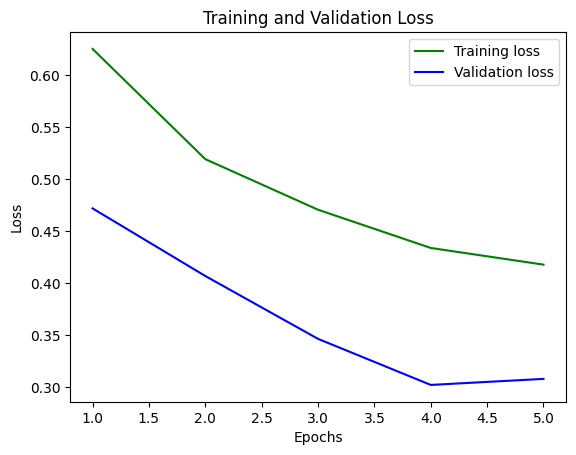

In [ ]:
# Plot training and validation loss
plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))

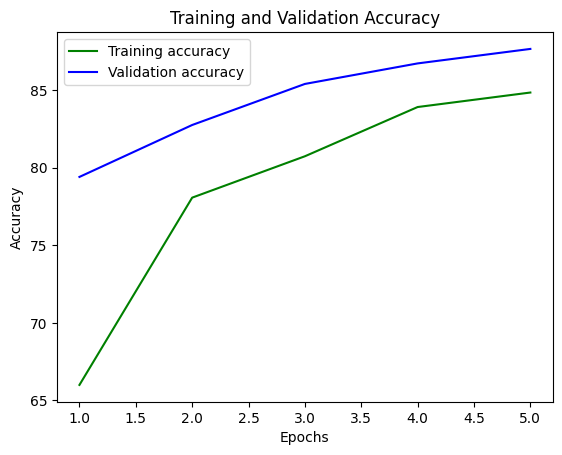

In [ ]:
# Plot training and validation accuracy
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))

In [ ]:
# Display the confusion matrix
print(confusion_matrix(true_labels, predicted_labels))

[[538  64]
 [ 95 589]]


True positive =  575
False positive =  38
False negative =  54
True negative =  619




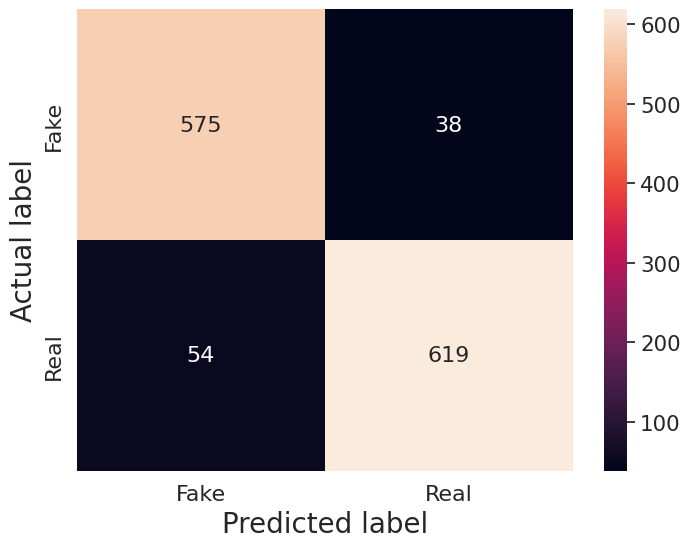

Calculated Accuracy 92.84603421461898


In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels)

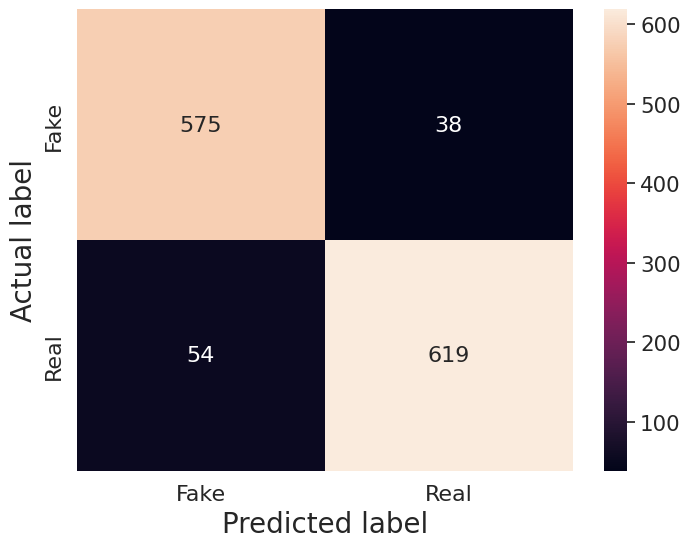

## Final Prediction code

In [ ]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize = transforms.Normalize(mean=-1 * np.divide(mean, std), std=np.divide([1, 1, 1], std))

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [ ]:
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length=60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        """
        for i,frame in enumerate(self.frame_extract(video_path)):
            if(i % a == first_frame):
                frames.append(self.transform(frame))
        """
        # if(len(frames)<self.count):
        #   for i in range(self.count-len(frames)):
        #         frames.append(self.transform(frame))
        #print("no of frames", self.count)
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)

    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

In [ ]:
def im_convert(tensor, video_file_name):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    # This image is not used
    # cv2.imwrite(os.path.join(settings.PROJECT_DIR, 'uploaded_images', video_file_name+'_convert_2.png'),image*255)
    return image

def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()


In [ ]:
def predict(model,img,path = './', video_file_name=""):
  fmap,logits = model(img.to('cuda'))
  img = im_convert(img[:,-1,:,:,:], video_file_name)
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  return [int(prediction.item()),confidence]

In [ ]:
video_file_path = "/content/drive/MyDrive/Project/Deepfake/test.mp4"

In [ ]:
# Example: Load the model
model = Model(2).cuda()
model_name = "your_model.pth"  # Adjust based on your actual model file
path_to_model = "/content/drive/MyDrive/Project/Deepfake/checkpoint_epoch_20.pt"
model.load_state_dict(torch.load(path_to_model))
model.eval()

Model(
  (resnext_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:
# Example: Load the video and preprocess frames
frames = []
cap = cv2.VideoCapture(video_file_path)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

In [ ]:
# Process frames using the model
video_dataset = validation_dataset([video_file_path], sequence_length=100,
                                  transform=train_transforms)
output = []

for i in range(0, len(video_dataset)):
    print("<=== | Started Prediction | ===>")
    prediction = predict(model, video_dataset[i])
    output.append(prediction)

<=== | Started Prediction | ===>
confidence of prediction: 98.51325750350952


In [ ]:
# Display the output with labels
for i, prediction in enumerate(output):
    label = "Real" if prediction[0] == 1 else "Fake"
    confidence = prediction[1]
    print(f"Prediction for sequence {i + 1}: {label} with confidence {confidence:.2f}%")


Prediction for sequence 1: Fake with confidence 98.51%
